<a href="https://colab.research.google.com/github/LuppeCh/F1EDA/blob/Cambio%2C-tablas/Exploraci%C3%B3n_de_Datos_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploración de datos

In [1]:
install.packages("dplyr")
install.packages("tidyr")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(dplyr)
library(ggplot2)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
wil <- read.csv("F12025-WILLIAMS.csv", header = TRUE, dec = ".", sep = "\t")

In [4]:
head(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,0,0,0,1,0,0.513507,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,0,0,1,1,0,1.449180,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,0,0,2,1,0,2.384850,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,0,0,3,1,0,3.320510,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,0,0,4,1,0,4.256180,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,0,0,5,1,0,5.194280,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
wil$carId <- "WIL"

In [6]:
tail(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,WIL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,WIL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,WIL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,WIL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,WIL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,WIL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Observamos que lapNum tiene un valor mayor al esperado (4), ya que arranca a contabilizar las vueltas desde 0, por lo que el lapNum = 5 corresponderia a la vuelta 6. Además observamos que los valores de muchas variables toman el valor "-1", lo cual es inconsistente en algunas variables como "lap_distance", por lo que aunque debemos eliminar todos los registros de esta vuelta, vamos a realizar un breve análisis que nos permita comprender que sucedió.

In [7]:
wil <- wil %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

Para trabajar más cómodos, decidimos eliminar todas aquellas columnas que no vamos a utilizar ni ahora ni a futuro.

In [8]:
inconsistencia <- wil %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,3237,3237,3237,0,3237,3237,3237


Creamos un pequeño dataset que nos permite ver cuantas de las variables númericas existentes en nuestro dataset tienen un valor igual a "-1". Al imprimirla observamos que 6 de las 8 variables tienen 3237 registros de este tipo. Sospechamos que cuando una de estas variables toma el valor -1, las otras 5 también.

In [9]:
sospechosas <- c(
  "lap_time",
  "lap_distance",
  "lap_time_invalid",
  "velocity_X",
  "velocity_Y",
  "velocity_Z"
)


conteo_sospechosas <- wil %>%
  summarise(
    cant_sospechosas = sum(if_all(all_of(sospechosas), ~ . == -1), na.rm = TRUE)
  ) %>%
  pull()

conteo_sospechosas

[1] 3237

Se confirma nuestra teoría. Además, por lo leído en el archivo de especificaciones de EA SPORTS F1, este valor suele significar que no se ha cruzado la línea de meta, lo que puede indicar que estos valores pertenezcan a:

1. Una vuelta de calentamiento.
2. Los metros que sigue recorriendo el automóvil antes de frenar, luego de cruzar la meta.

In [10]:
final_valido <- wil %>%
  filter(lapNum == 5) %>%
  group_by(lap_time_invalid) %>%
  summarise(
    N_Registros = n(),
    .groups = 'drop'
  )

  final_valido

lap_time_invalid,N_Registros
<int>,<int>
-1,3237
0,1057


Confirmamos que todos estos valores pertenecen a la vuelta 6 (lapNum = 5), lo que indicaria que todos estos registros se deben a la razón 2.

In [11]:
wil <- wil %>%
  filter(lapNum < 5)

Borramos esta vuelta.

In [12]:
mcl <- read.csv("F12025-MCLAREN.csv", header = TRUE, dec = ".", sep = "\t")

In [13]:
head(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,21,0,0,1,21,0.40625,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,21,0,1,1,21,1.41602,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,21,0,2,1,21,2.42578,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,21,0,3,1,21,3.43555,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,21,0,4,1,21,4.44531,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,21,0,5,1,21,5.45703,⋯,0,0,0,0,0,0,0,0,0,0


In [14]:
mcl$carId <- "MCL"

In [15]:
mcl$lapNum <- mcl$lapNum - 21

In [16]:
tail(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MCL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MCL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MCL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MCL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MCL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MCL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [17]:
mcl <- mcl %>%
  filter(lapNum < 5)

In [18]:
mcl <- mcl %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [19]:
red <- read.csv("F12025-REDBULL.csv", header = TRUE, dec = ".", sep = "\t")

In [20]:
head(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,16,0,0,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,16,0,1,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,16,0,2,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,16,0,3,1,16,3.82617,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,16,0,4,1,16,4.83984,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,16,0,5,1,16,5.85352,⋯,0,0,0,0,0,0,0,0,0,0


In [21]:
red$carId <-"RED"

In [22]:
red$lapNum <- red$lapNum - 16

In [23]:
tail(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,RED,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,RED,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,RED,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,RED,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,RED,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,RED,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [24]:
red <- red %>%
  filter(lapNum < 5)

In [25]:
red <- red %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [26]:
alp <- read.csv("F12025-ALPINE.csv", header = TRUE, dec = ".", sep = "\t")

In [27]:
head(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,10,0,0,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,10,0,1,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,10,0,2,1,10,2.62500,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,10,0,3,1,10,3.61719,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,10,0,4,1,10,4.60938,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,10,0,5,1,10,5.60156,⋯,0,0,0,0,0,0,0,0,0,0


In [28]:
alp$carId <- "ALP"

In [29]:
alp$lapNum <- alp$lapNum - 10

In [30]:
tail(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
30053,ALP,Interlagos,4294,6,6,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30054,ALP,Interlagos,4294,6,6,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30055,ALP,Interlagos,4294,6,6,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30056,ALP,Interlagos,4294,6,6,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30057,ALP,Interlagos,4294,6,6,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30058,ALP,Interlagos,4294,6,6,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [31]:
alp <- alp %>%
  filter(lapNum < 5)

In [32]:
alp <- alp %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [33]:
mer <- read.csv("F12025-MERCEDES.csv", header = TRUE, dec = ".", sep = "\t")

In [34]:
head(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,5,0,0,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,5,0,1,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,5,0,2,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,5,0,3,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,5,0,4,1,5,4.41357,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,5,0,5,1,5,5.48145,⋯,0,0,0,0,0,0,0,0,0,0


In [35]:
mer$carId <-"MER"

In [36]:
mer$lapNum <- mer$lapNum - 5

In [37]:
tail(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MER,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MER,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MER,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MER,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MER,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MER,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [38]:
mer <- mer %>%
  filter(lapNum < 5)

In [39]:
mer <- mer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [40]:
mer <- mer %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ))

In [41]:
fer <- read.csv("F12025-FERRARI.csv", header = TRUE, dec = ".", sep = "\t")

In [42]:
head(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,31,0,0,1,31,0.93750,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,31,0,1,1,31,1.80313,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,31,0,2,1,31,2.66875,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,31,0,3,1,31,3.53438,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,31,0,4,1,31,4.40000,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,31,0,5,1,31,5.26562,⋯,0,0,0,0,0,0,0,0,0,0


In [43]:
fer$carId <- "FER"

In [44]:
fer$lapNum <- fer$lapNum - 31

In [45]:
tail(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
21465,FER,Interlagos,4294,4,4,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21466,FER,Interlagos,4294,4,4,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21467,FER,Interlagos,4294,4,4,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21468,FER,Interlagos,4294,4,4,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21469,FER,Interlagos,4294,4,4,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21470,FER,Interlagos,4294,4,4,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


En este caso si tenemos la cantidad correcta de vueltas, pero como podemos ver hay muchisimos valores "-1", por lo que debemos borrar esta vuelta y generarla de manera artificial.

In [46]:
fer <- fer %>%
  filter(lapNum < 4)

In [47]:
fer <- fer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [48]:
vueltas_anuladas_fer <- fer %>%
  group_by(lapNum) %>%
  summarise(lap_time_invalid = max(lap_time_invalid))

Para generar de forma artificial la quinta vuelta, debemos realizarlo promediando los valores de las vueltas validas, por lo que visualizamos cuales son (las que tienen lap_time_valid = 0)

In [49]:
vueltas_anuladas_fer

lapNum,lap_time_invalid
<dbl>,<int>
0,0
1,1
2,1
3,0


Solamente podemos trabajar con la vuelta 1 y 4.

In [50]:
vueltas_validas <- fer %>%
  filter(lapNum %in% c(0, 3))

In [51]:
vuelta_5 <- vueltas_validas %>%
  group_by(binIndex) %>%
  summarise(
    lap_distance = mean(lap_distance, na.rm = TRUE),
    lap_time = mean(lap_time, na.rm = TRUE),
    velocity_X = mean(velocity_X, na.rm = TRUE),
    velocity_Y = mean(velocity_Y, na.rm = TRUE),
    velocity_Z = mean(velocity_Z, na.rm = TRUE),

    carId = "FER",
    lap_time_invalid = 0
  ) %>%

  ungroup()%>%

  mutate(
    lapNum = 4
  )

Las filtramos en el dataset "vueltas_validas" y construimos la "vuelta_5" calculando los promedios en la variables indicadas, despues le pasamos el valor del id, que la vuelta es valida y que es la número 5.

In [52]:
fer <- bind_rows(fer, vuelta_5)

La agregamos a nuestro dataset de ferrari.

In [53]:
telemetria <- bind_rows(fer, red, mcl, mer, alp, wil)

Únimos los 6 datasets en uno único.

In [54]:
telemetria <- telemetria %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ),
    track_lenght = 4294
    )

Creamos la columna sector, indicando el valor que toma según el binIndex.

In [55]:
telemetria <- telemetria %>%
  mutate(
    velocity_total_ms = sqrt(
      velocity_X^2 +
      velocity_Y^2 +
      velocity_Z^2
    ),

    velocidad = velocity_total_ms * 3.6
  )

telemetria <- telemetria %>%
  select(-velocity_total_ms)

In [56]:
inconsistencia_global <- telemetria %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia_global

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z,track_lenght,velocidad
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


In [57]:
telemetria <- telemetria %>%
  mutate(lap_number = lapNum + 1)

In [58]:
unique_invalid <- unique(telemetria$lap_time_invalid)
unique_invalid

[1] 0 1

In [59]:
porcentaje_invalido <- telemetria %>%
  group_by(carId, lapNum) %>%
  summarise(
    total_registros = n(),
    obs_invalidas = sum(lap_time_invalid == 1, na.rm = TRUE),
    porcentaje_invalido = (obs_invalidas / total_registros) * 100
  ) %>%
  ungroup() %>%
  arrange(desc(porcentaje_invalido), carId, lapNum)

porcentaje_invalido

`summarise()` has grouped output by 'carId'. You can override using the
`.groups` argument.


carId,lapNum,total_registros,obs_invalidas,porcentaje_invalido
<chr>,<dbl>,<int>,<int>,<dbl>
ALP,0,4294,3746,87.23801
RED,1,4294,3658,85.18864
MCL,4,4294,3544,82.53377
RED,0,4294,2791,64.99767
ALP,1,4294,2541,59.17559
RED,3,4294,2241,52.18910
WIL,4,4294,2044,47.60130
WIL,1,4294,2042,47.55473
WIL,3,4294,2033,47.34513


In [60]:
vueltas_a_invalidar <- c(
  "ALP_0", "RED_1", "MCL_4", "RED_0", "ALP_1", "RED_3",
  "WIL_4", "WIL_1", "WIL_3", "FER_1", "FER_2", "ALP_4")

telemetria_vueltas_invalidadas <- telemetria %>%
  mutate(lap_id = paste(carId, lapNum, sep = "_")) %>%
  mutate(
    lap_time_invalid = if_else(lap_id %in% vueltas_a_invalidar, 1, lap_time_invalid)) %>%
  select(-lap_id)

In [61]:
registros <- nrow(telemetria_vueltas_invalidadas)
print(paste("cant. registros:", registros))

escuderias <- unique(telemetria_vueltas_invalidadas$carId)
print(escuderias)

cant_lap <- unique(telemetria_vueltas_invalidadas$lapNum)
print(cant_lap)

cant_lap <- unique(telemetria_vueltas_invalidadas$lap_number)
print(cant_lap)

any(is.na(telemetria_vueltas_invalidadas))

[1] "cant. registros: 128820"
[1] "FER" "RED" "MCL" "MER" "ALP" "WIL"
[1] 0 1 2 3 4
[1] 1 2 3 4 5


[1] FALSE

In [62]:
summary(telemetria_vueltas_invalidadas)

    carId               lapNum     lap_time      lap_distance      
 Length:128820      Min.   :0   Min.   : 0.00   Min.   :   0.0312  
 Class :character   1st Qu.:1   1st Qu.:17.39   1st Qu.:1073.5850  
 Mode  :character   Median :2   Median :34.08   Median :2146.9850  
                    Mean   :2   Mean   :37.37   Mean   :2146.9966  
                    3rd Qu.:3   3rd Qu.:58.95   3rd Qu.:3220.5300  
                    Max.   :4   Max.   :83.37   Max.   :4294.0000  
 lap_time_invalid    binIndex      velocity_X       velocity_Y     
 Min.   :0.0      Min.   :   0   Min.   : 3.316   Min.   :-9.7585  
 1st Qu.:0.0      1st Qu.:1073   1st Qu.:48.901   1st Qu.:-0.1395  
 Median :0.0      Median :2146   Median :65.286   Median : 0.2474  
 Mean   :0.4      Mean   :2146   Mean   :62.746   Mean   : 0.2773  
 3rd Qu.:1.0      3rd Qu.:3220   3rd Qu.:78.749   3rd Qu.: 0.8548  
 Max.   :1.0      Max.   :4293   Max.   :87.822   Max.   :12.2492  
   velocity_Z          sector           track_le

Verificamos que haya la misma cantidad de registros para cada vehiculo.

In [63]:
registros_por_vehiculo <- telemetria_vueltas_invalidadas %>%
  group_by(carId) %>%
  summarise(cant_registros = n())

registros_por_vehiculo

carId,cant_registros
<chr>,<int>
ALP,21470
FER,21470
MCL,21470
MER,21470
RED,21470
WIL,21470


In [64]:
noisy_data_ <- telemetria_vueltas_invalidadas %>%
  group_by(carId, lapNum) %>%
  summarise(
    conteo_total = n(),

    rango_correcto = min(binIndex) == 0 & max(binIndex) == 4293,
    duplicados = conteo_total - n_distinct(binIndex),

    .groups = 'drop'
  )

noisy_data_

carId,lapNum,conteo_total,rango_correcto,duplicados
<chr>,<dbl>,<int>,<lgl>,<int>
ALP,0,4294,TRUE,0
ALP,1,4294,TRUE,0
ALP,2,4294,TRUE,0
ALP,3,4294,TRUE,0
ALP,4,4294,TRUE,0
FER,0,4294,TRUE,0
FER,1,4294,TRUE,0
FER,2,4294,TRUE,0
FER,3,4294,TRUE,0


In [65]:
test_tiempo_estricto <- telemetria_vueltas_invalidadas %>%
  group_by(carId, lapNum) %>%
  mutate(
    falla_tiempo = lap_time <= lag(lap_time)
  ) %>%
  summarise(
    cant_tiempo_nocreciente = sum(falla_tiempo, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  filter(cant_tiempo_nocreciente > 0)

test_tiempo_estricto

carId,lapNum,cant_tiempo_nocreciente
<chr>,<dbl>,<int>
ALP,0,2
ALP,1,5
ALP,2,2
ALP,3,2
ALP,4,4
FER,0,1
FER,1,4
FER,2,2
FER,3,3


In [66]:
options(repr.plot.width = 20, repr.plot.height = 14)

#Actividad 2

Elabore un gráfico que muestre el tiempo por vuelta para cada uno de los vehículos. En el eje de las abscisas (X), se representarán las vueltas, mientras que en el eje de las ordenadas (Y) se plasmará el tiempo empleado por cada vehículo en cada vuelta.

In [67]:
install.packages("gridExtra")
install.packages("grid")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘grid’ is a base package, and should not be updated”


In [68]:
lap_times_summary <- telemetria_vueltas_invalidadas %>%
  group_by(carId, lap_number) %>%
  summarise(total_lap_time = max(lap_time, na.rm = TRUE), .groups = 'drop')

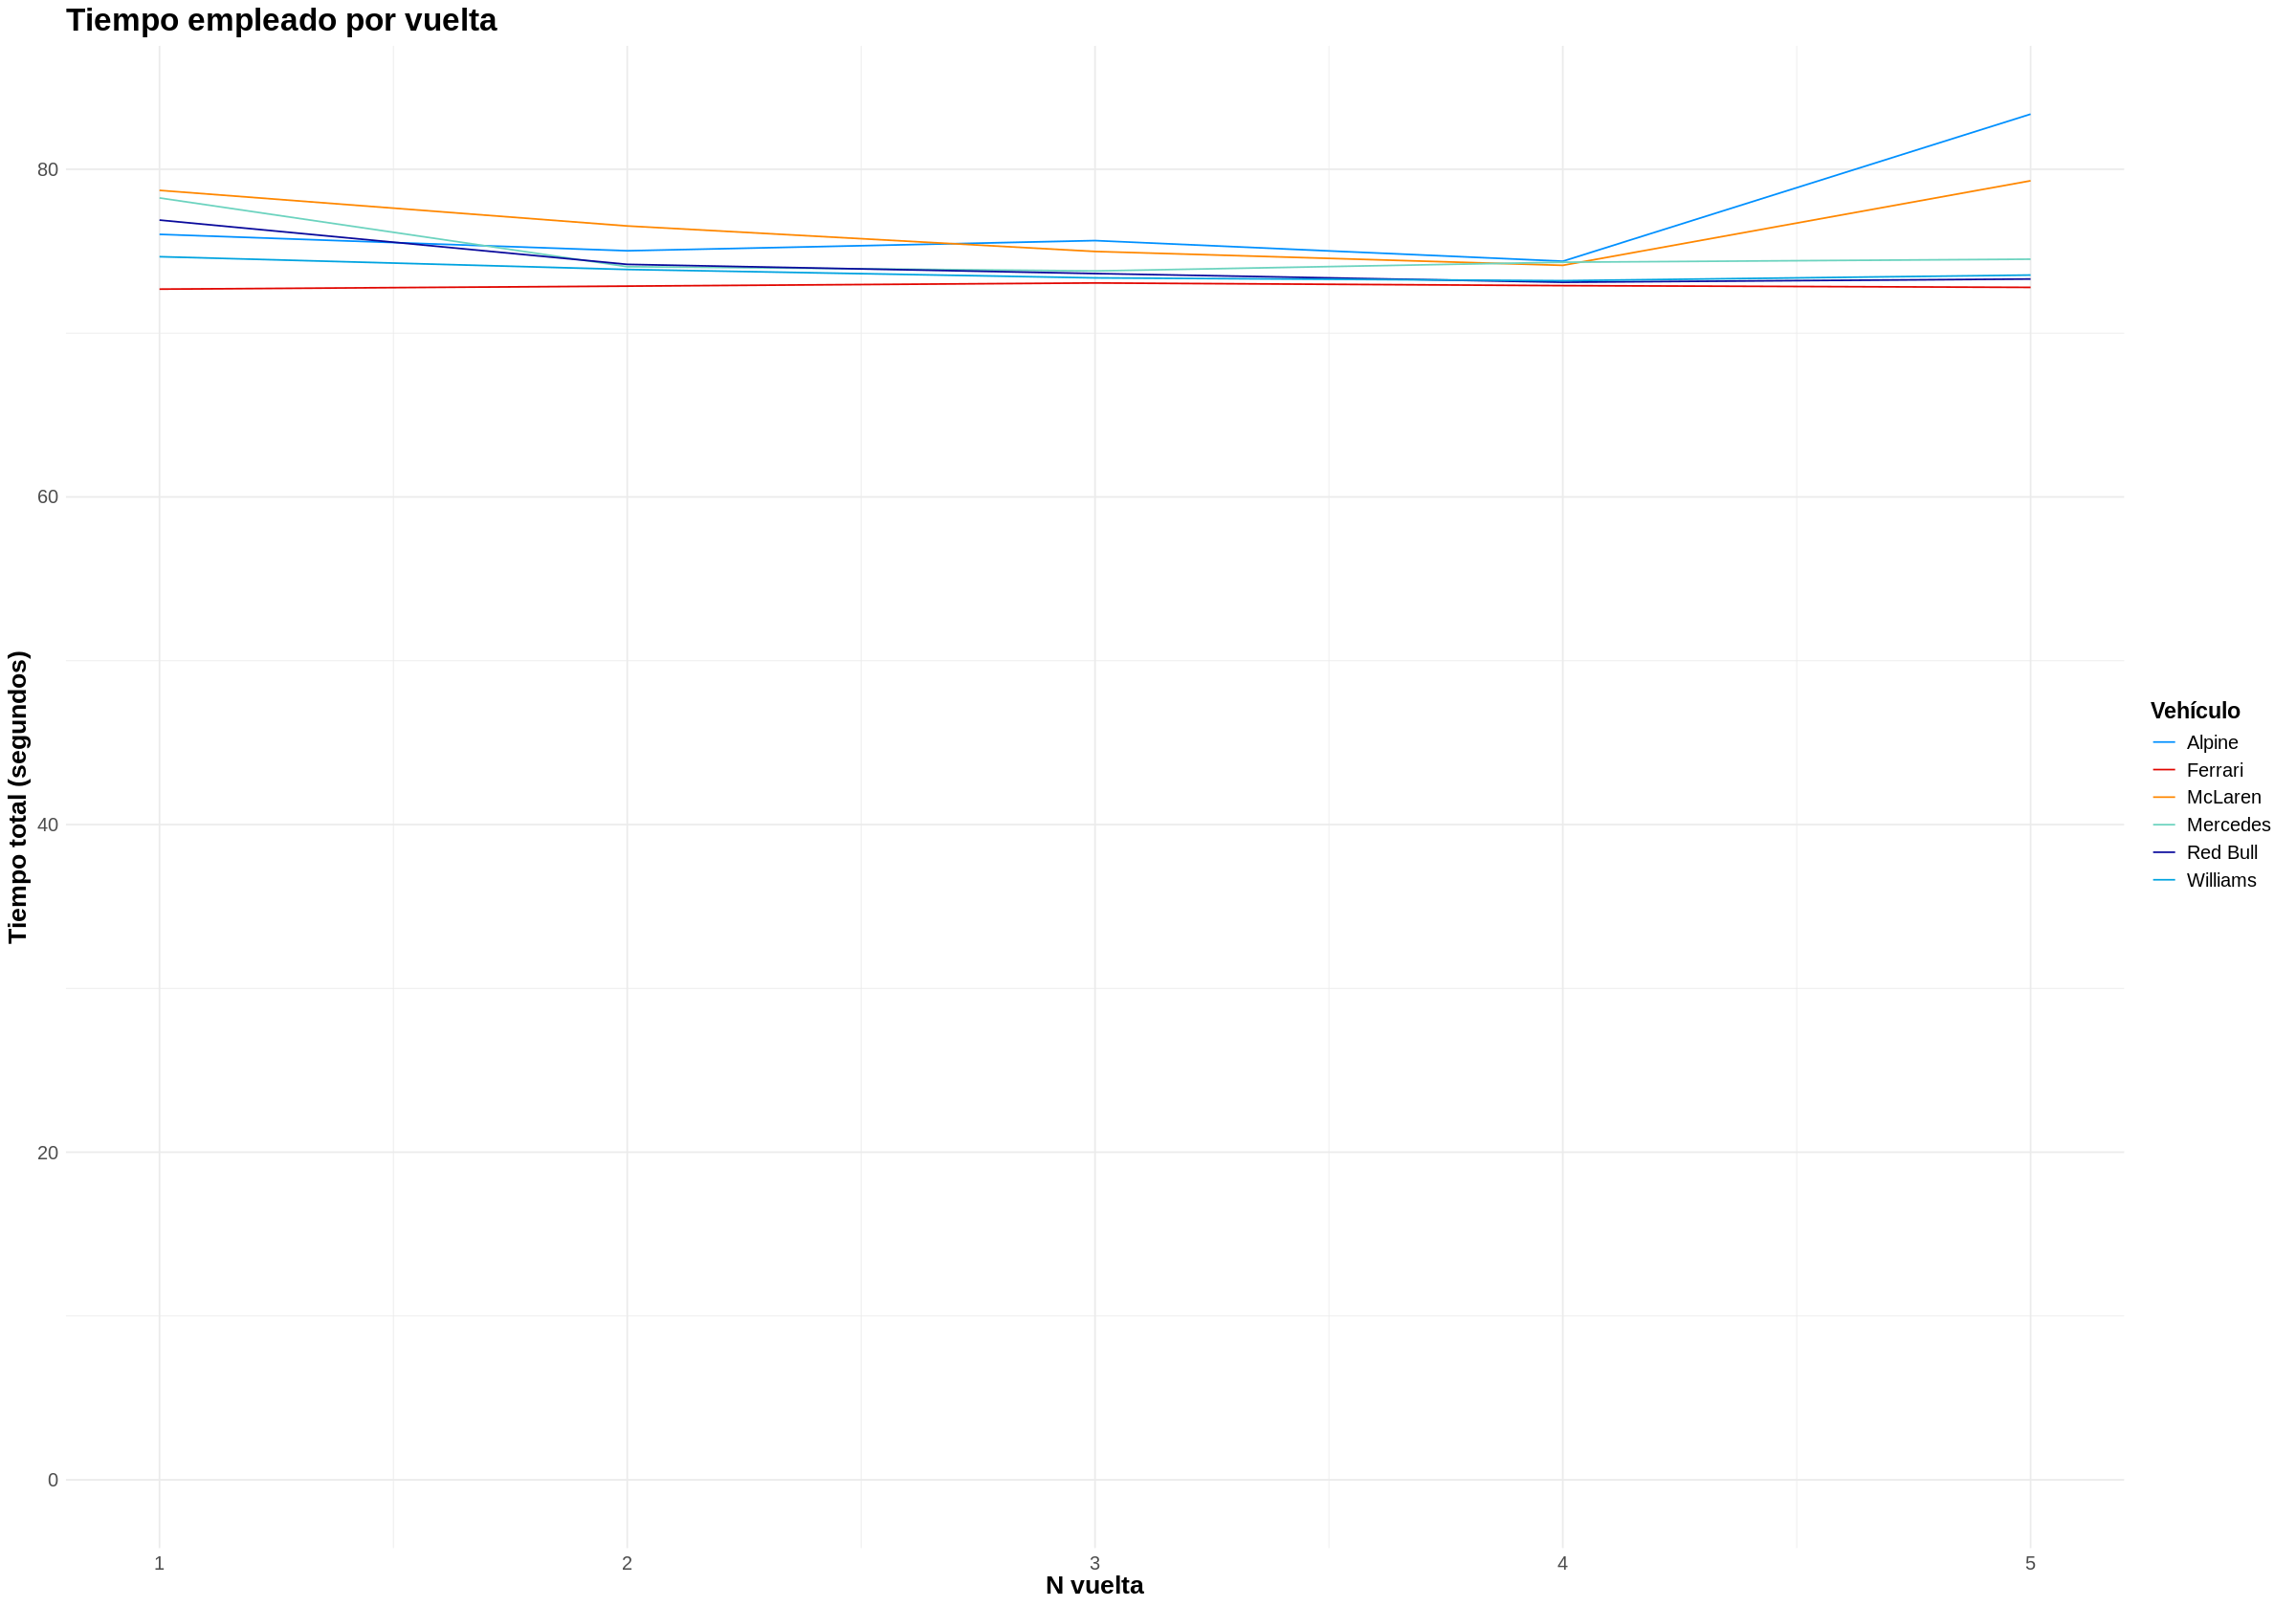

In [69]:
colores_f1 <- c(
  "FER" = "#E10600",
  "RED" = "#0A0A9C",
  "MCL" = "#FF8700",
  "MER" = "#6CD3BF",
  "ALP" = "#0090FF",
  "WIL" = "#00A3E0"
)

full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

full_color_map <- setNames(colores_f1, full_team_names[names(colores_f1)])

ggplot(lap_times_summary_full, aes(x = lap_number, y = total_lap_time, color = full_carId)) +
  geom_line() +
  scale_color_manual(values = full_color_map, labels = full_team_names) +
  labs(
    title = "Tiempo empleado por vuelta",
    x = "N vuelta",
    y = "Tiempo total (segundos)",
    color = "Vehículo"
  ) +
  ylim(0, NA) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold"),
    legend.text = element_text(size = 12)
  )

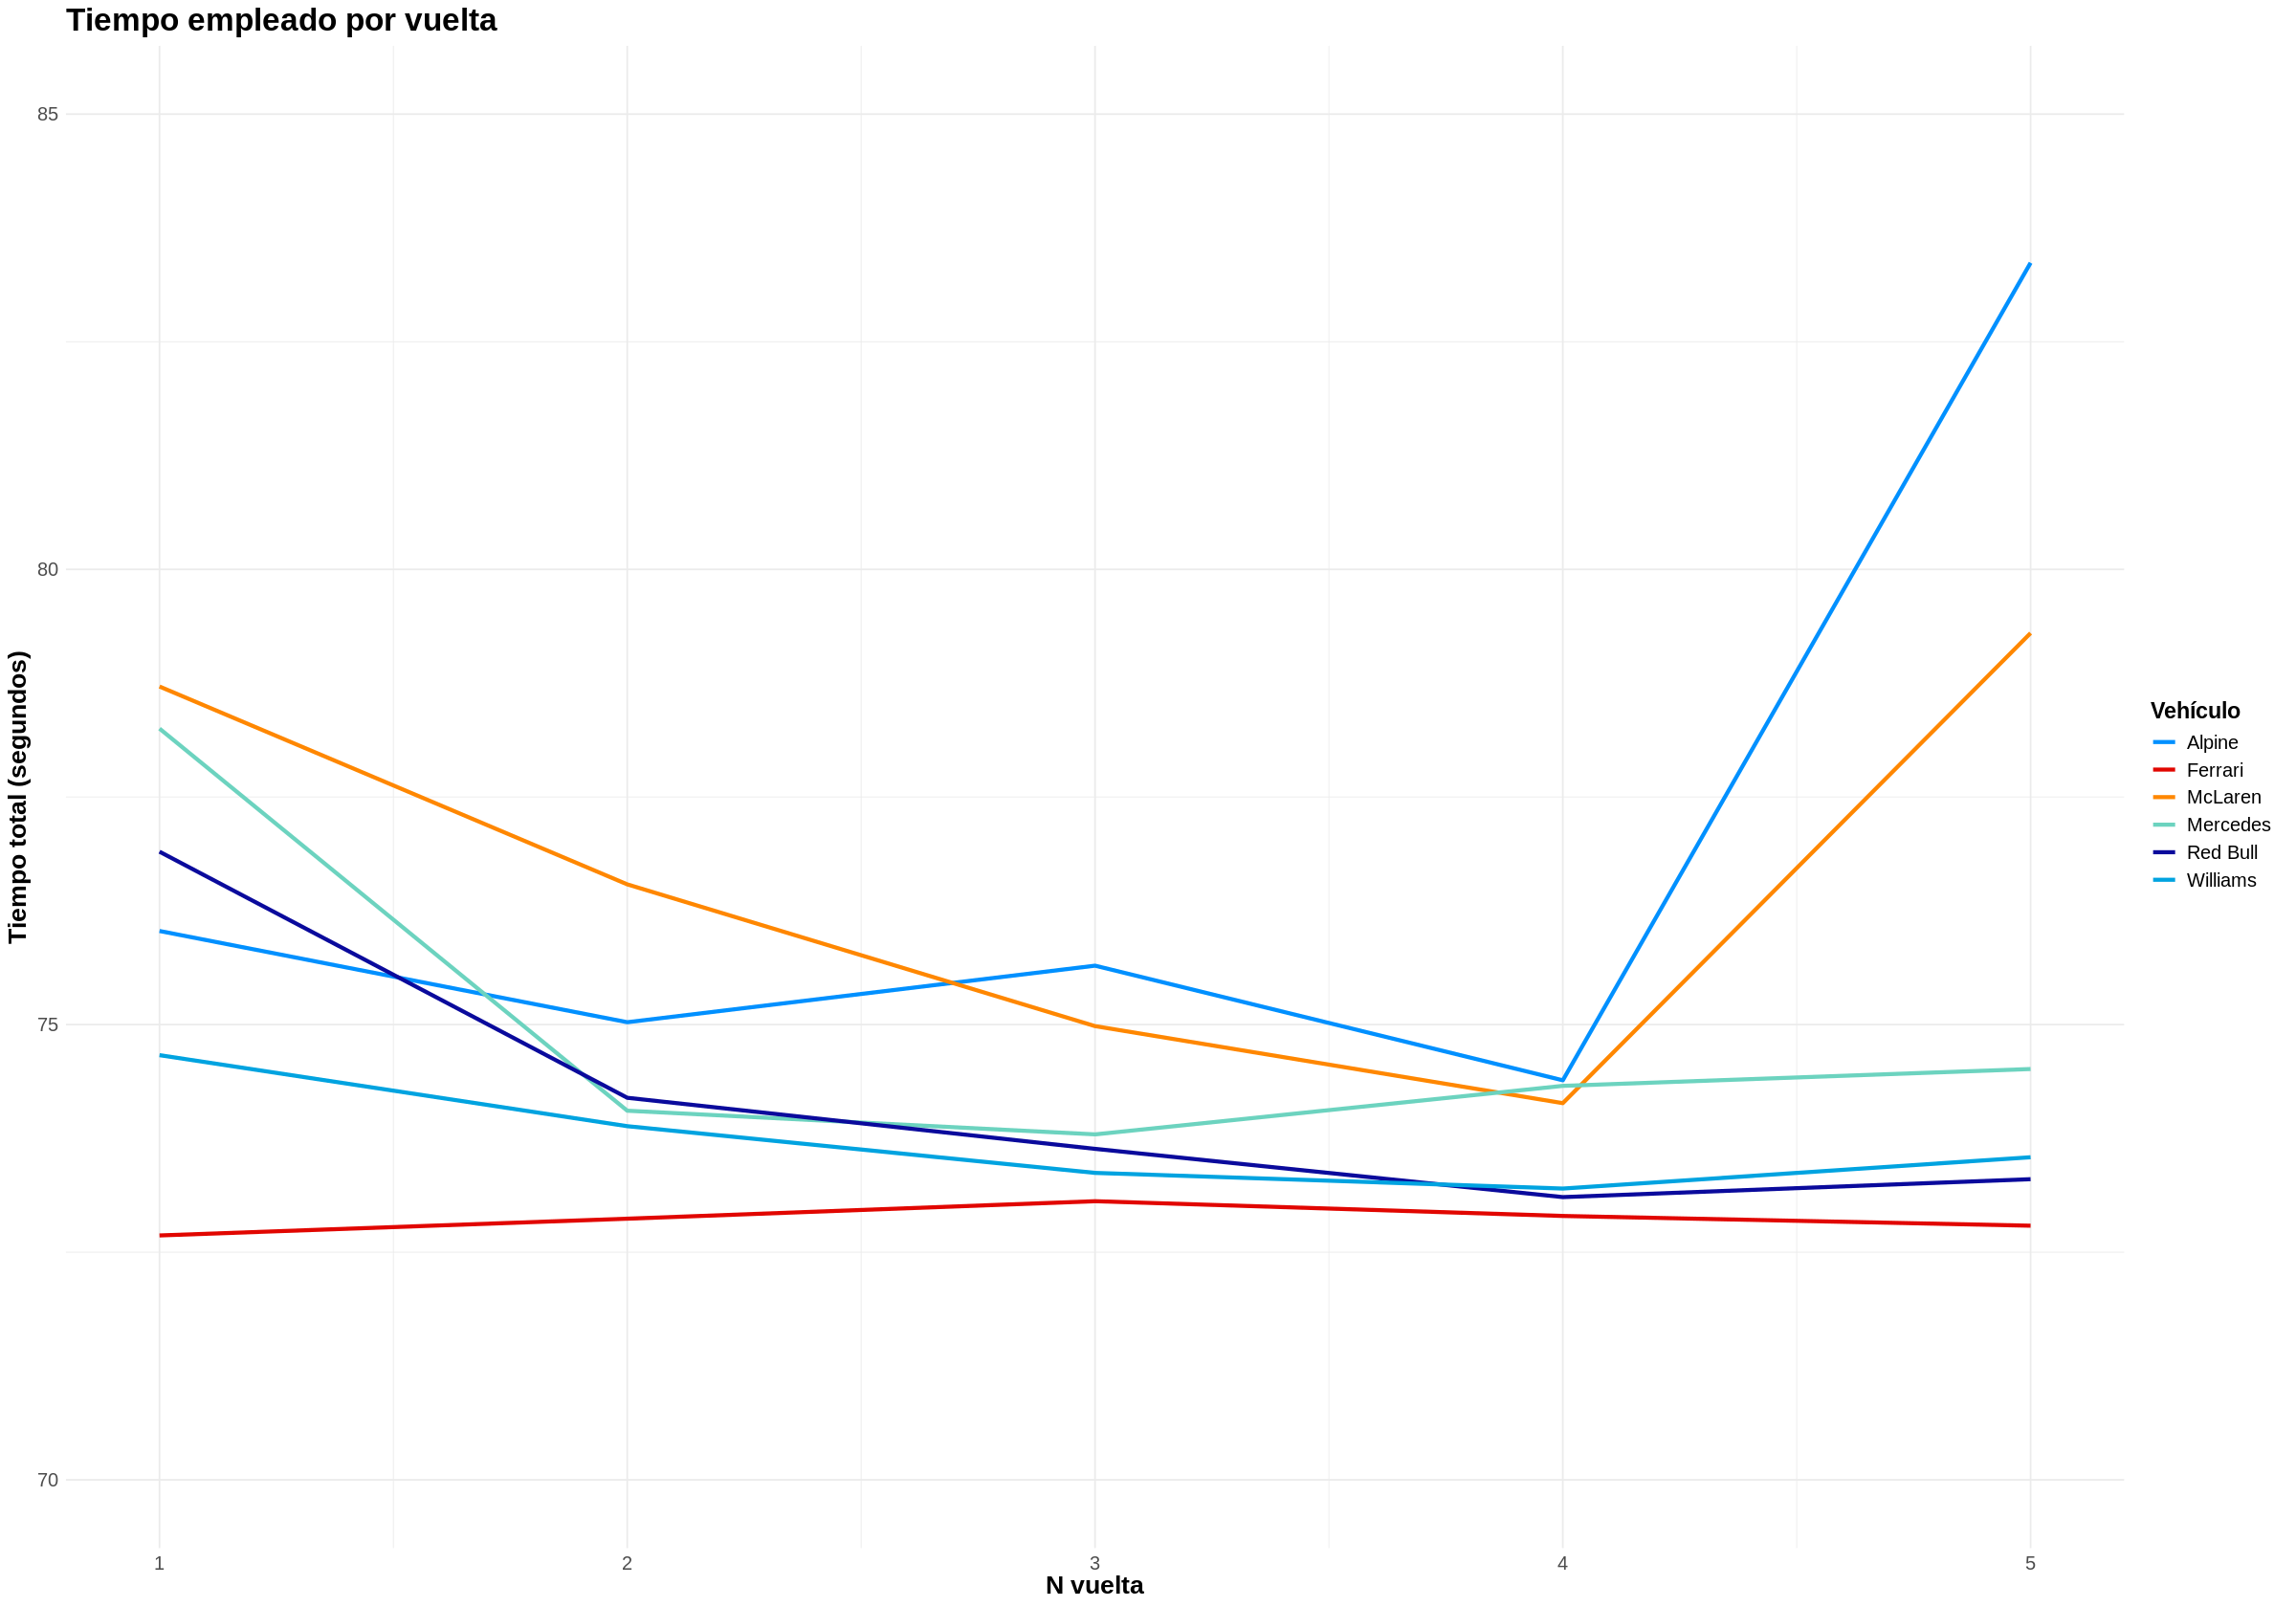

In [70]:
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

full_color_map <- setNames(colores_f1, full_team_names[names(colores_f1)])

ggplot(lap_times_summary_full, aes(x = lap_number, y = total_lap_time, color = full_carId)) +
  geom_line(linewidth = 1.2) +
  scale_color_manual(values = full_color_map, labels = full_team_names) +
  labs(
    title = "Tiempo empleado por vuelta",
    x = "N vuelta",
    y = "Tiempo total (segundos)",
    color = "Vehículo"
  ) +
  ylim(70, 85) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    legend.title = element_text(size = 14, face = "bold"),
    legend.text = element_text(size = 12)
  )

In [114]:
lap_times_summary_ordered <- lap_times_summary %>%
  arrange(desc(total_lap_time))

lap_times_summary_ordered

carId,lap_number,total_lap_time
<chr>,<dbl>,<dbl>
ALP,5,83.367
MCL,5,79.300
MCL,1,78.713
MER,1,78.251
RED,1,76.899
MCL,2,76.540
ALP,1,76.028
ALP,3,75.647
ALP,2,75.026


El gráfico de nos permite observar el rendimiento de cada escudería a lo largo de cinco vueltas.


*   **Ferrari** y **Red Bull** demuestran ser las escuderías con los tiempos de vuelta más consistentes y rápidos en general, manteniéndose alrededor de los 72-73 segundos por vuelta.

*   **Mercedes** también exhibe un rendimiento sólido y consistente, con tiempos de vuelta ligeramente superiores a Ferrari y Red Bull, pero muy estables.

*   **McLaren** y **Williams** muestran tiempos de vuelta competitivos en las primeras vueltas, pero Williams presenta una leve tendencia a aumentar sus tiempos en las últimas vueltas válidas.

*   **Alpine** presenta una anomalía significativa en la vuelta 5, donde su tiempo total de vuelta se dispara a 83.4 segundos, mientras que el resto de sus vueltas están en el rango de 74-76 segundos.

*   La **consistencia** es una característica notable para la mayoría de las escuderías en sus vueltas válidas (1 a 4), lo que indica un rendimiento estable bajo condiciones de carrera normales.

#Actividad 3

Represente gráficamente la información correspondiente a los tiempos de vuelta para cada vehículo mediante diagramas de caja (boxplots) y diagrama de violín.

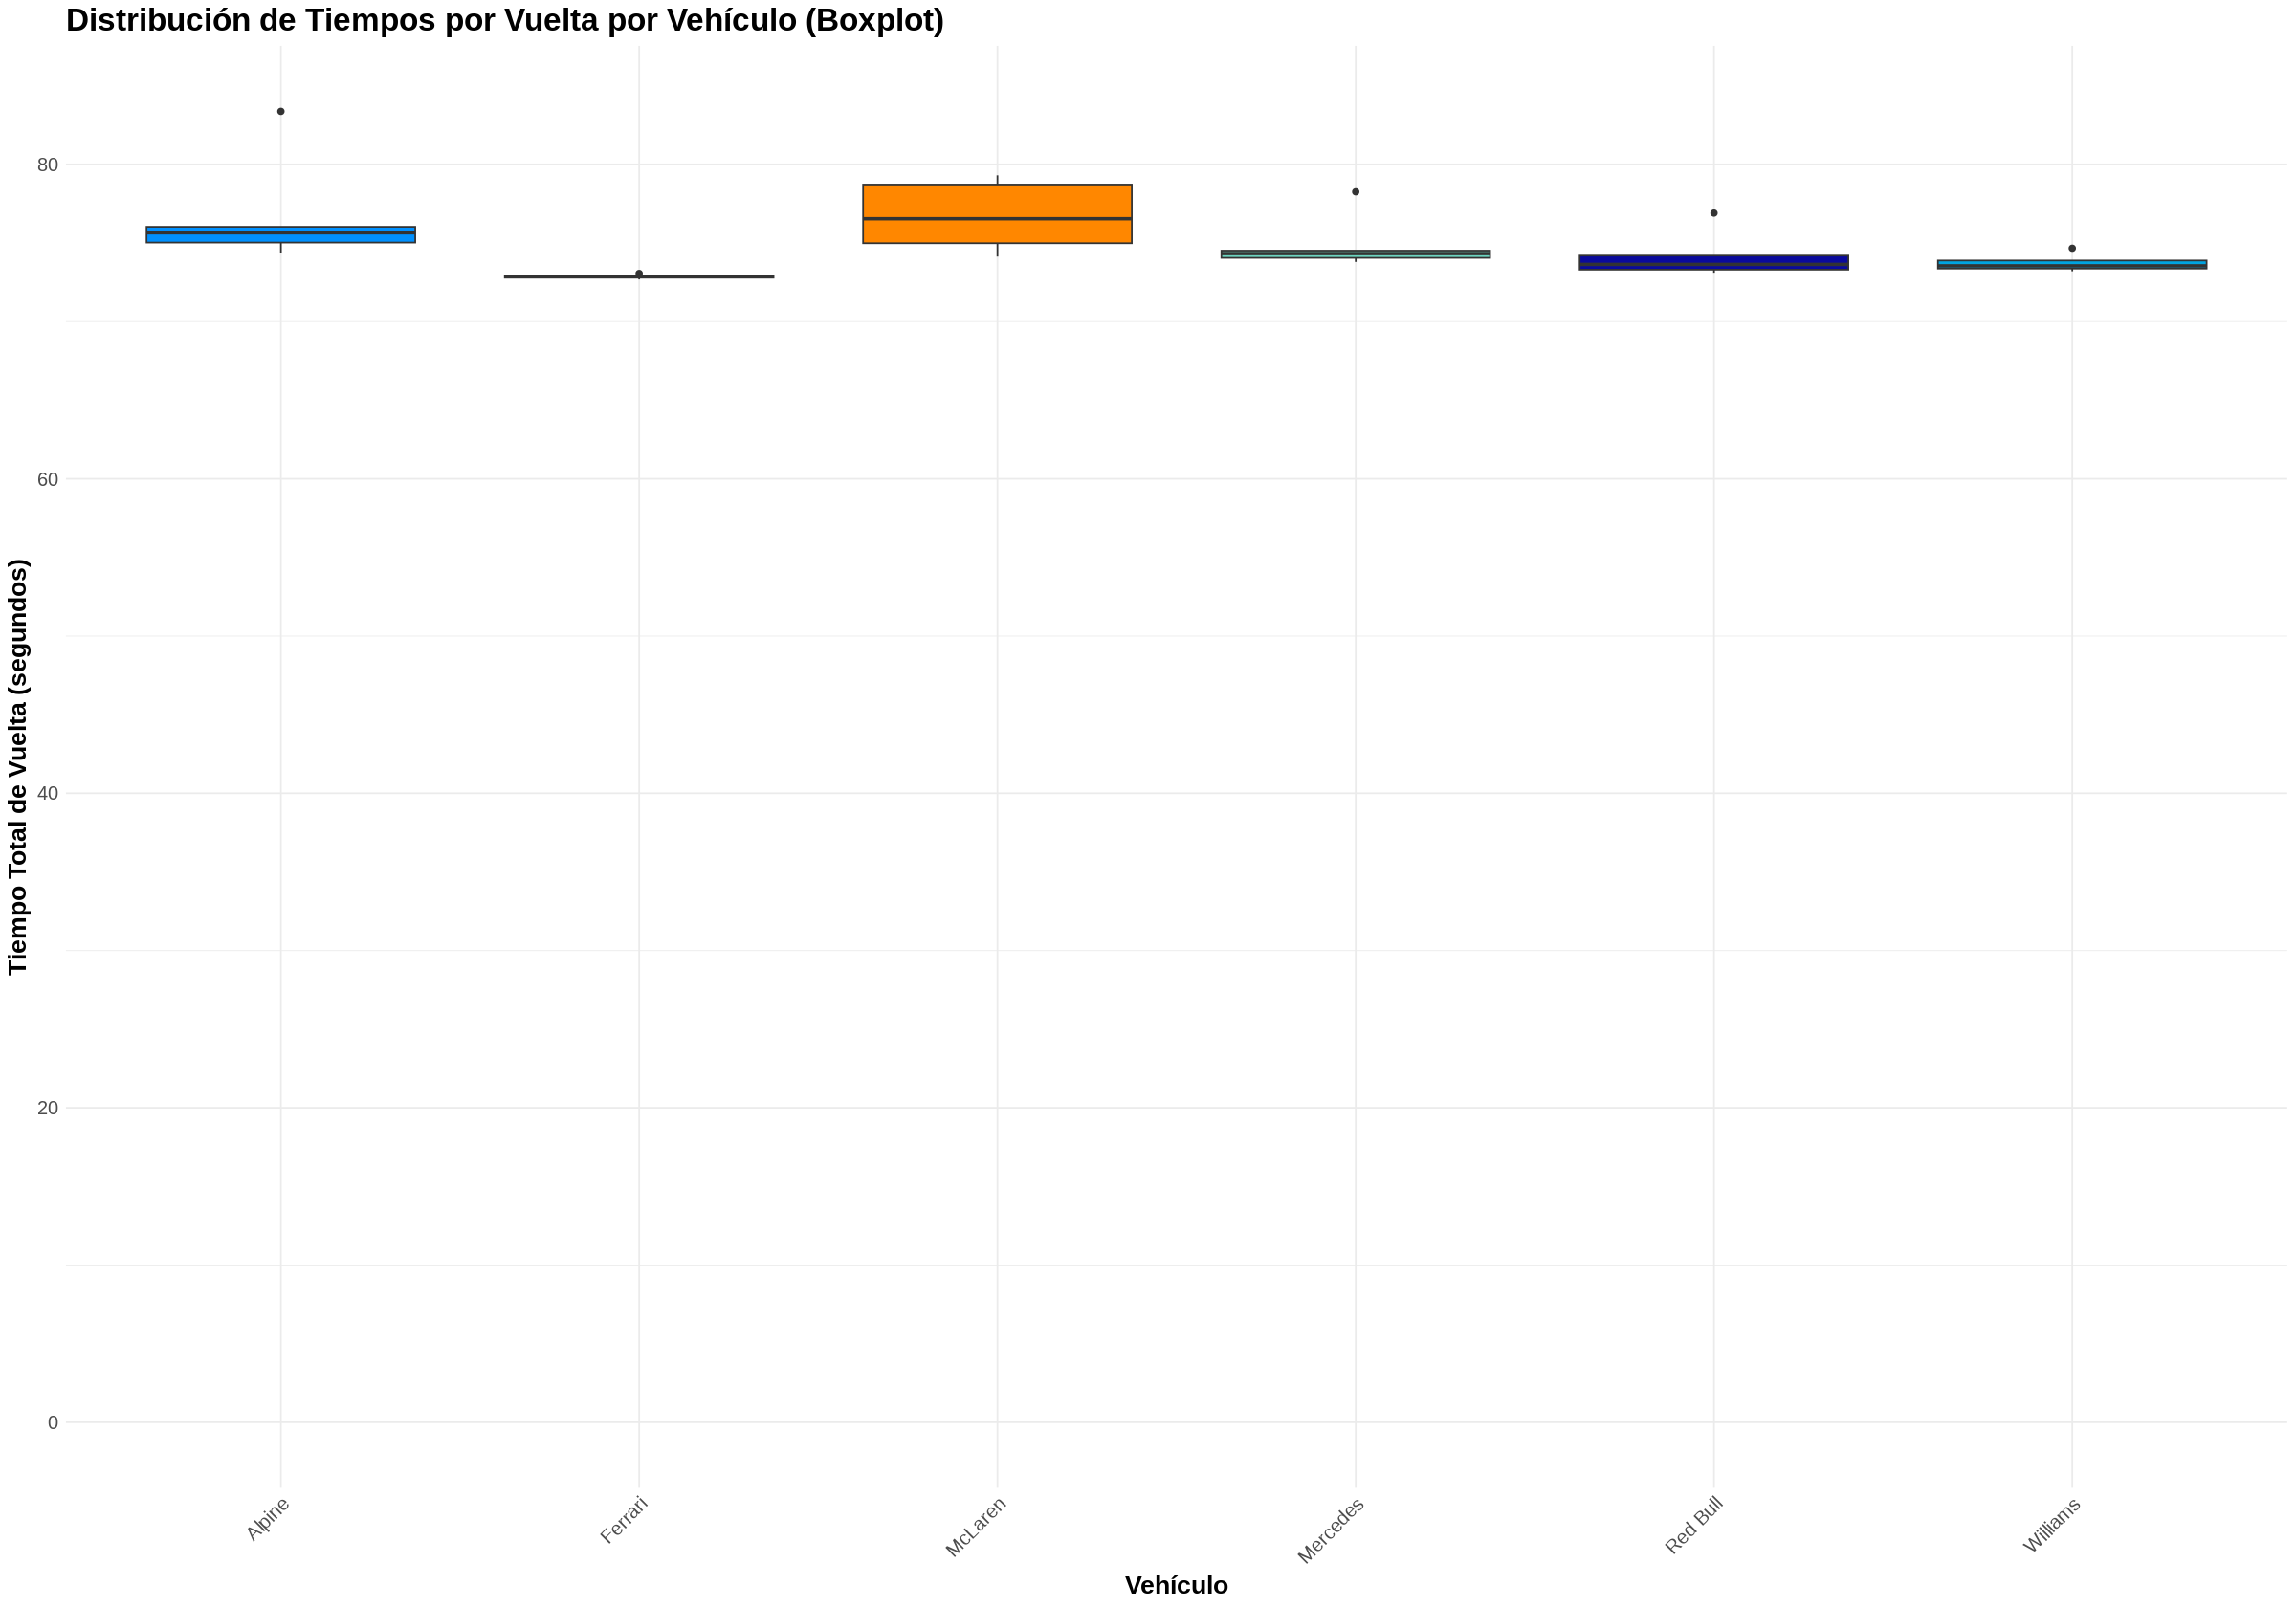

In [90]:
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

ggplot(lap_times_summary_full, aes(x = full_carId, y = total_lap_time, fill = carId)) +
  geom_boxplot() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Distribución de Tiempos por Vuelta por Vehículo (Boxplot)",
    x = "Vehículo",
    y = "Tiempo Total de Vuelta (segundos)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12)
  ) +
  expand_limits(y = 0)

En este gráfico dejamos la escala real en el eje y (del 0 al valor máximo)

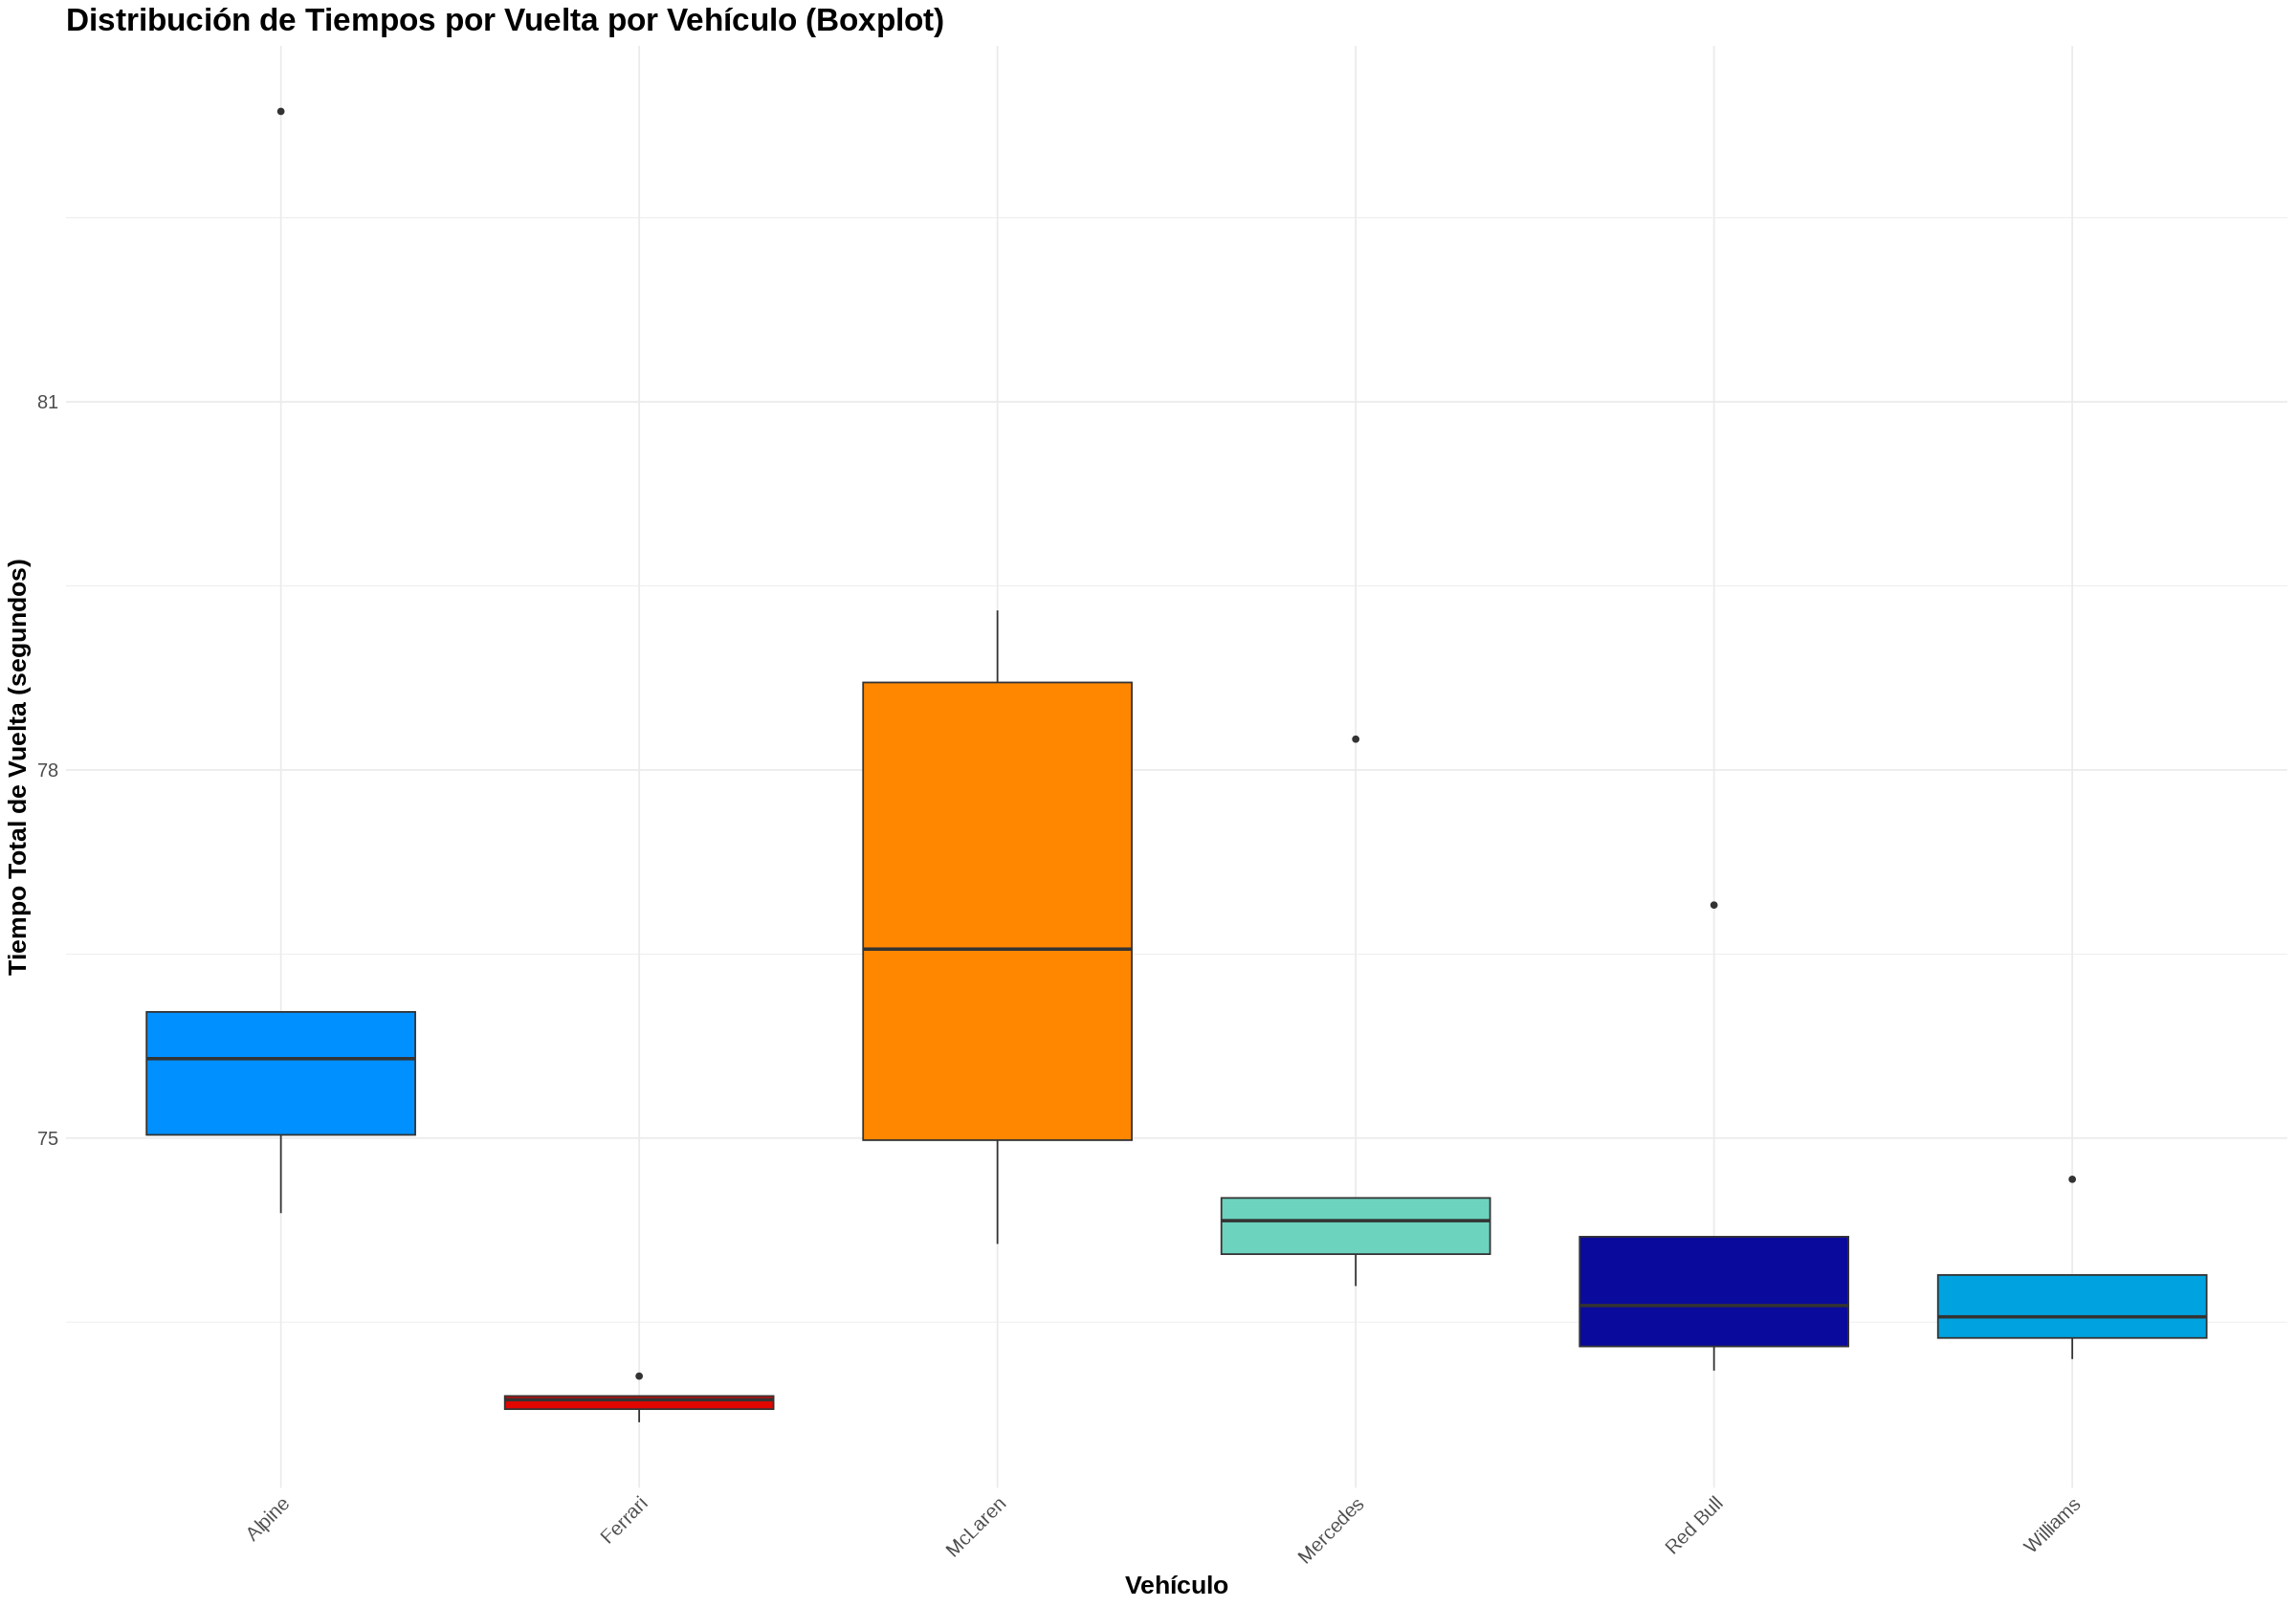

In [91]:
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

ggplot(lap_times_summary_full, aes(x = full_carId, y = total_lap_time, fill = carId)) +
  geom_boxplot() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Distribución de Tiempos por Vuelta por Vehículo (Boxplot)",
    x = "Vehículo",
    y = "Tiempo Total de Vuelta (segundos)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12)
  )

En este gráfico, la escala esta agrandada en el eje y (del valor mín al valor máx)

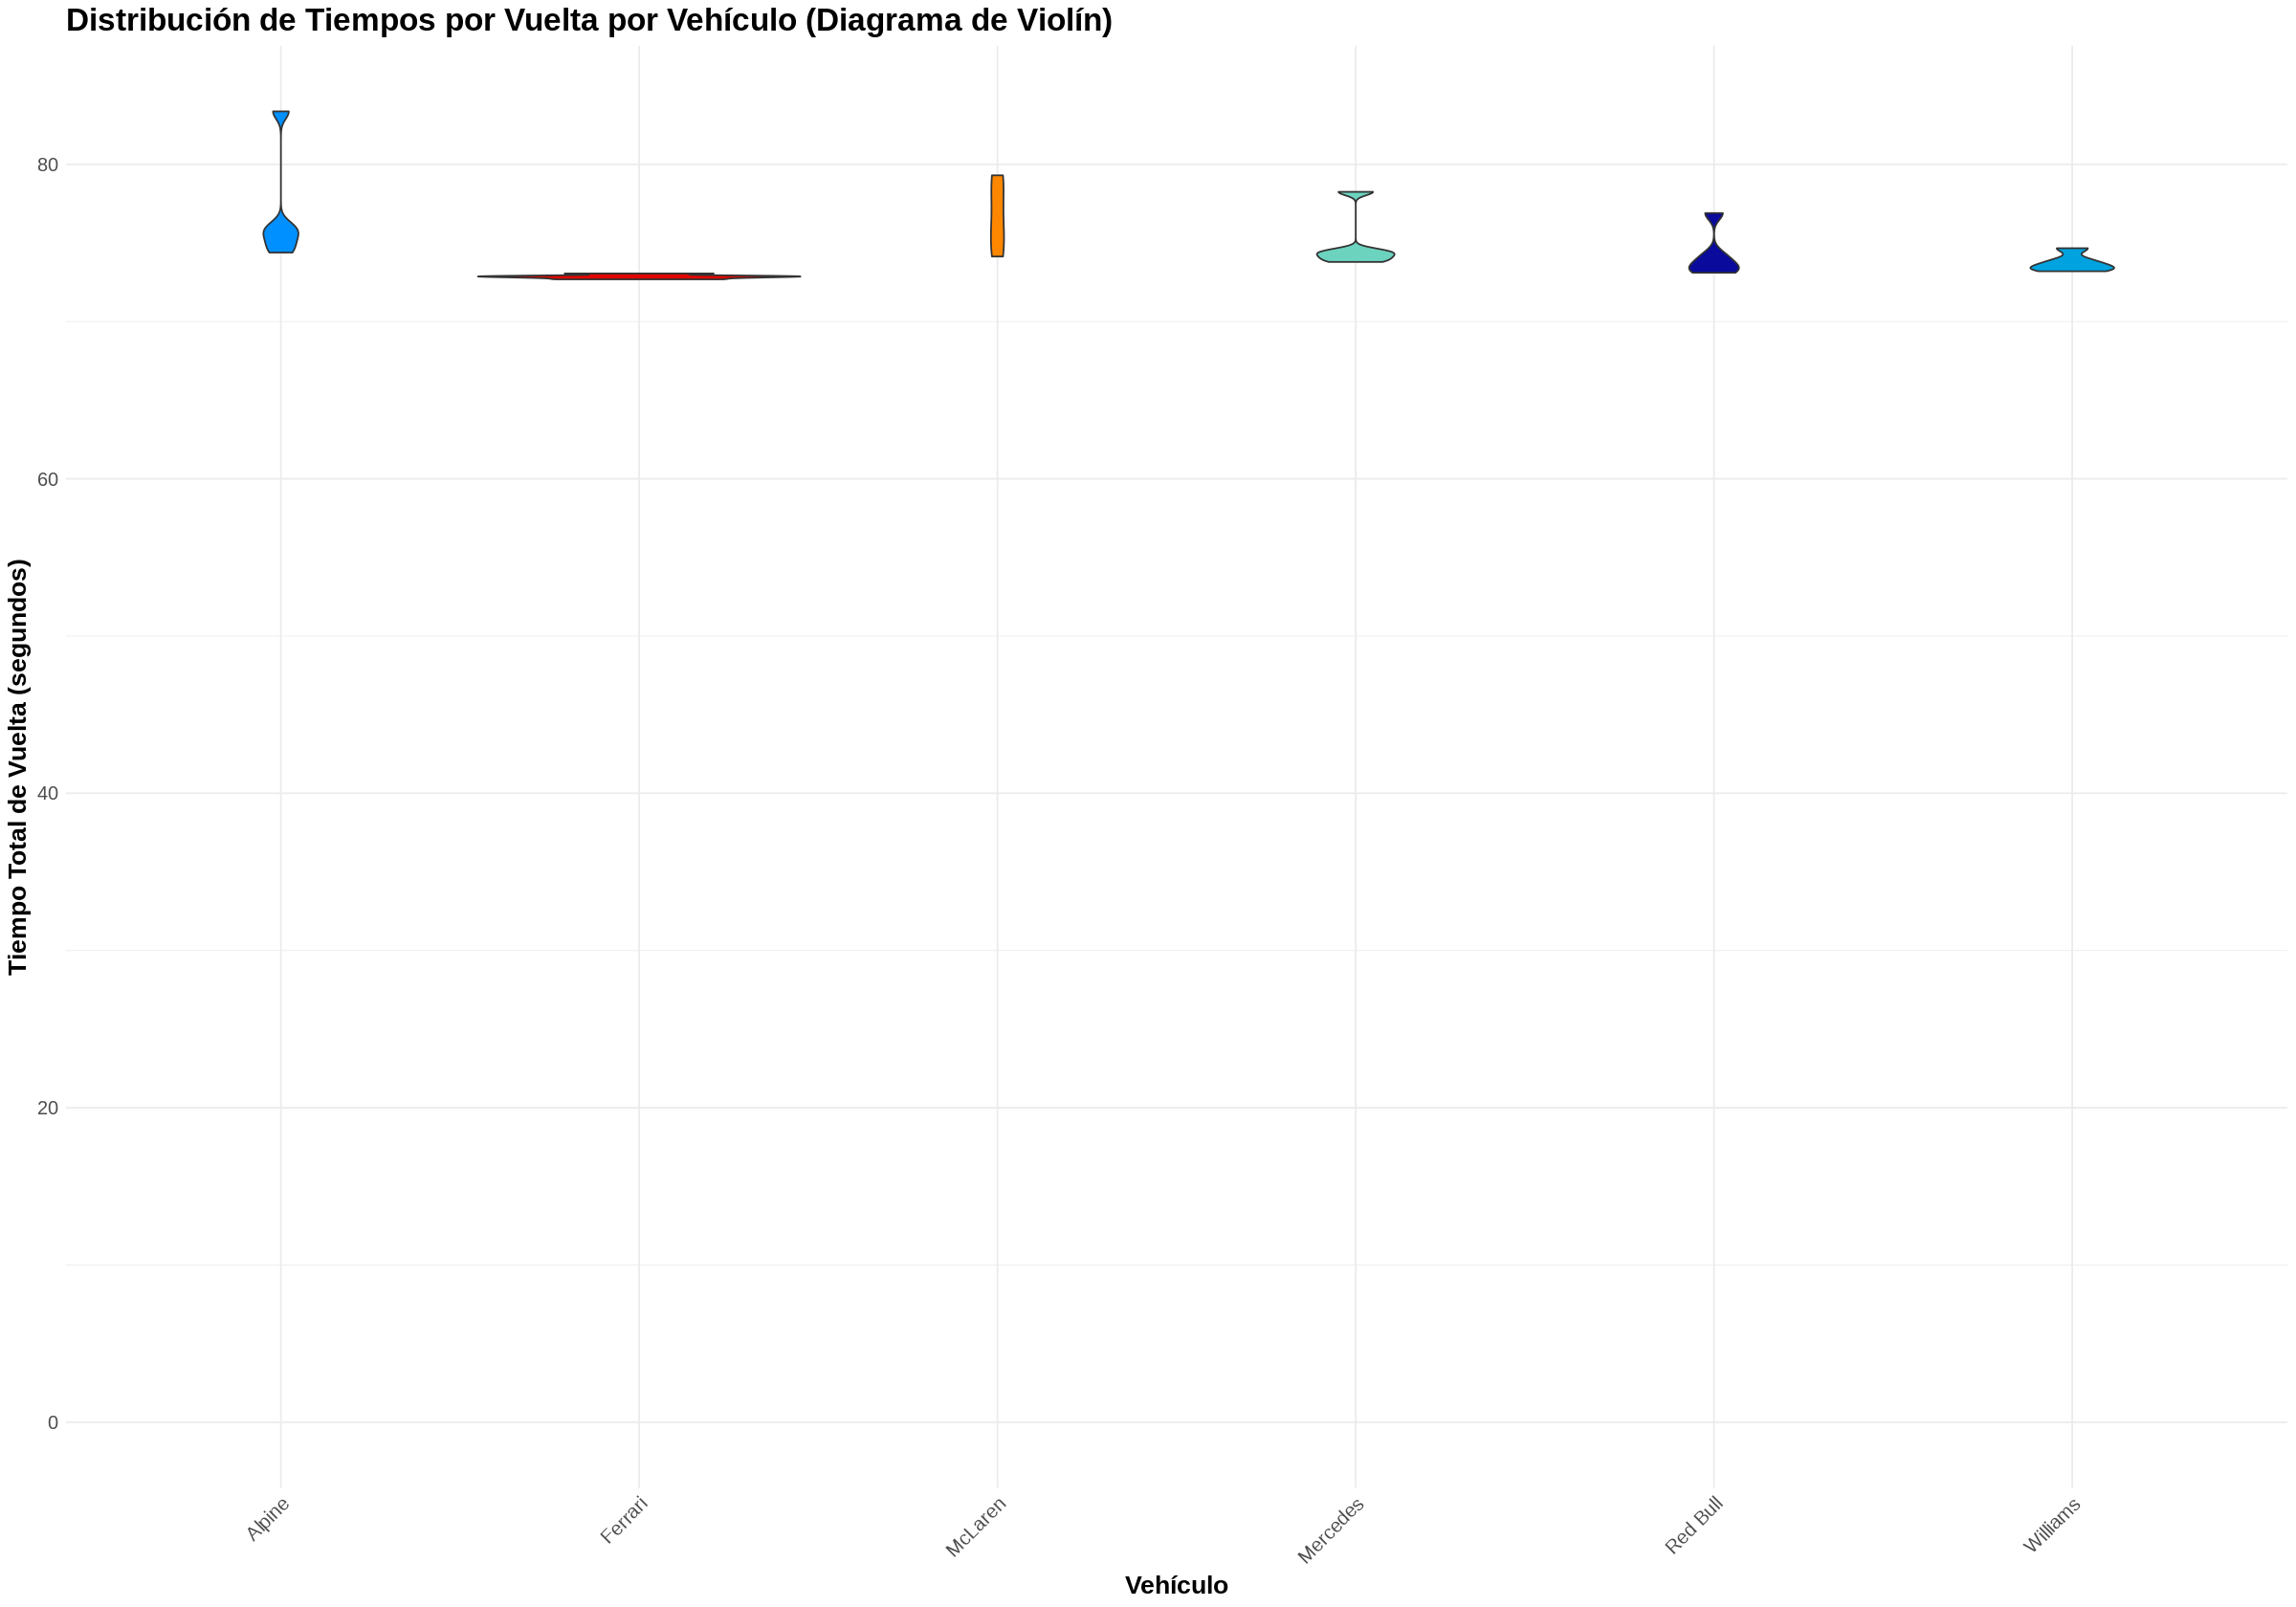

In [74]:
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

ggplot(lap_times_summary_full, aes(x = full_carId, y = total_lap_time, fill = carId)) +
  geom_violin() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Distribución de Tiempos por Vuelta por Vehículo (Diagrama de Violín)",
    x = "Vehículo",
    y = "Tiempo Total de Vuelta (segundos)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12)
  ) +
 expand_limits(y = 0)


En este gráfico dejamos la escala real en el eje y (del 0 al valor máximo)

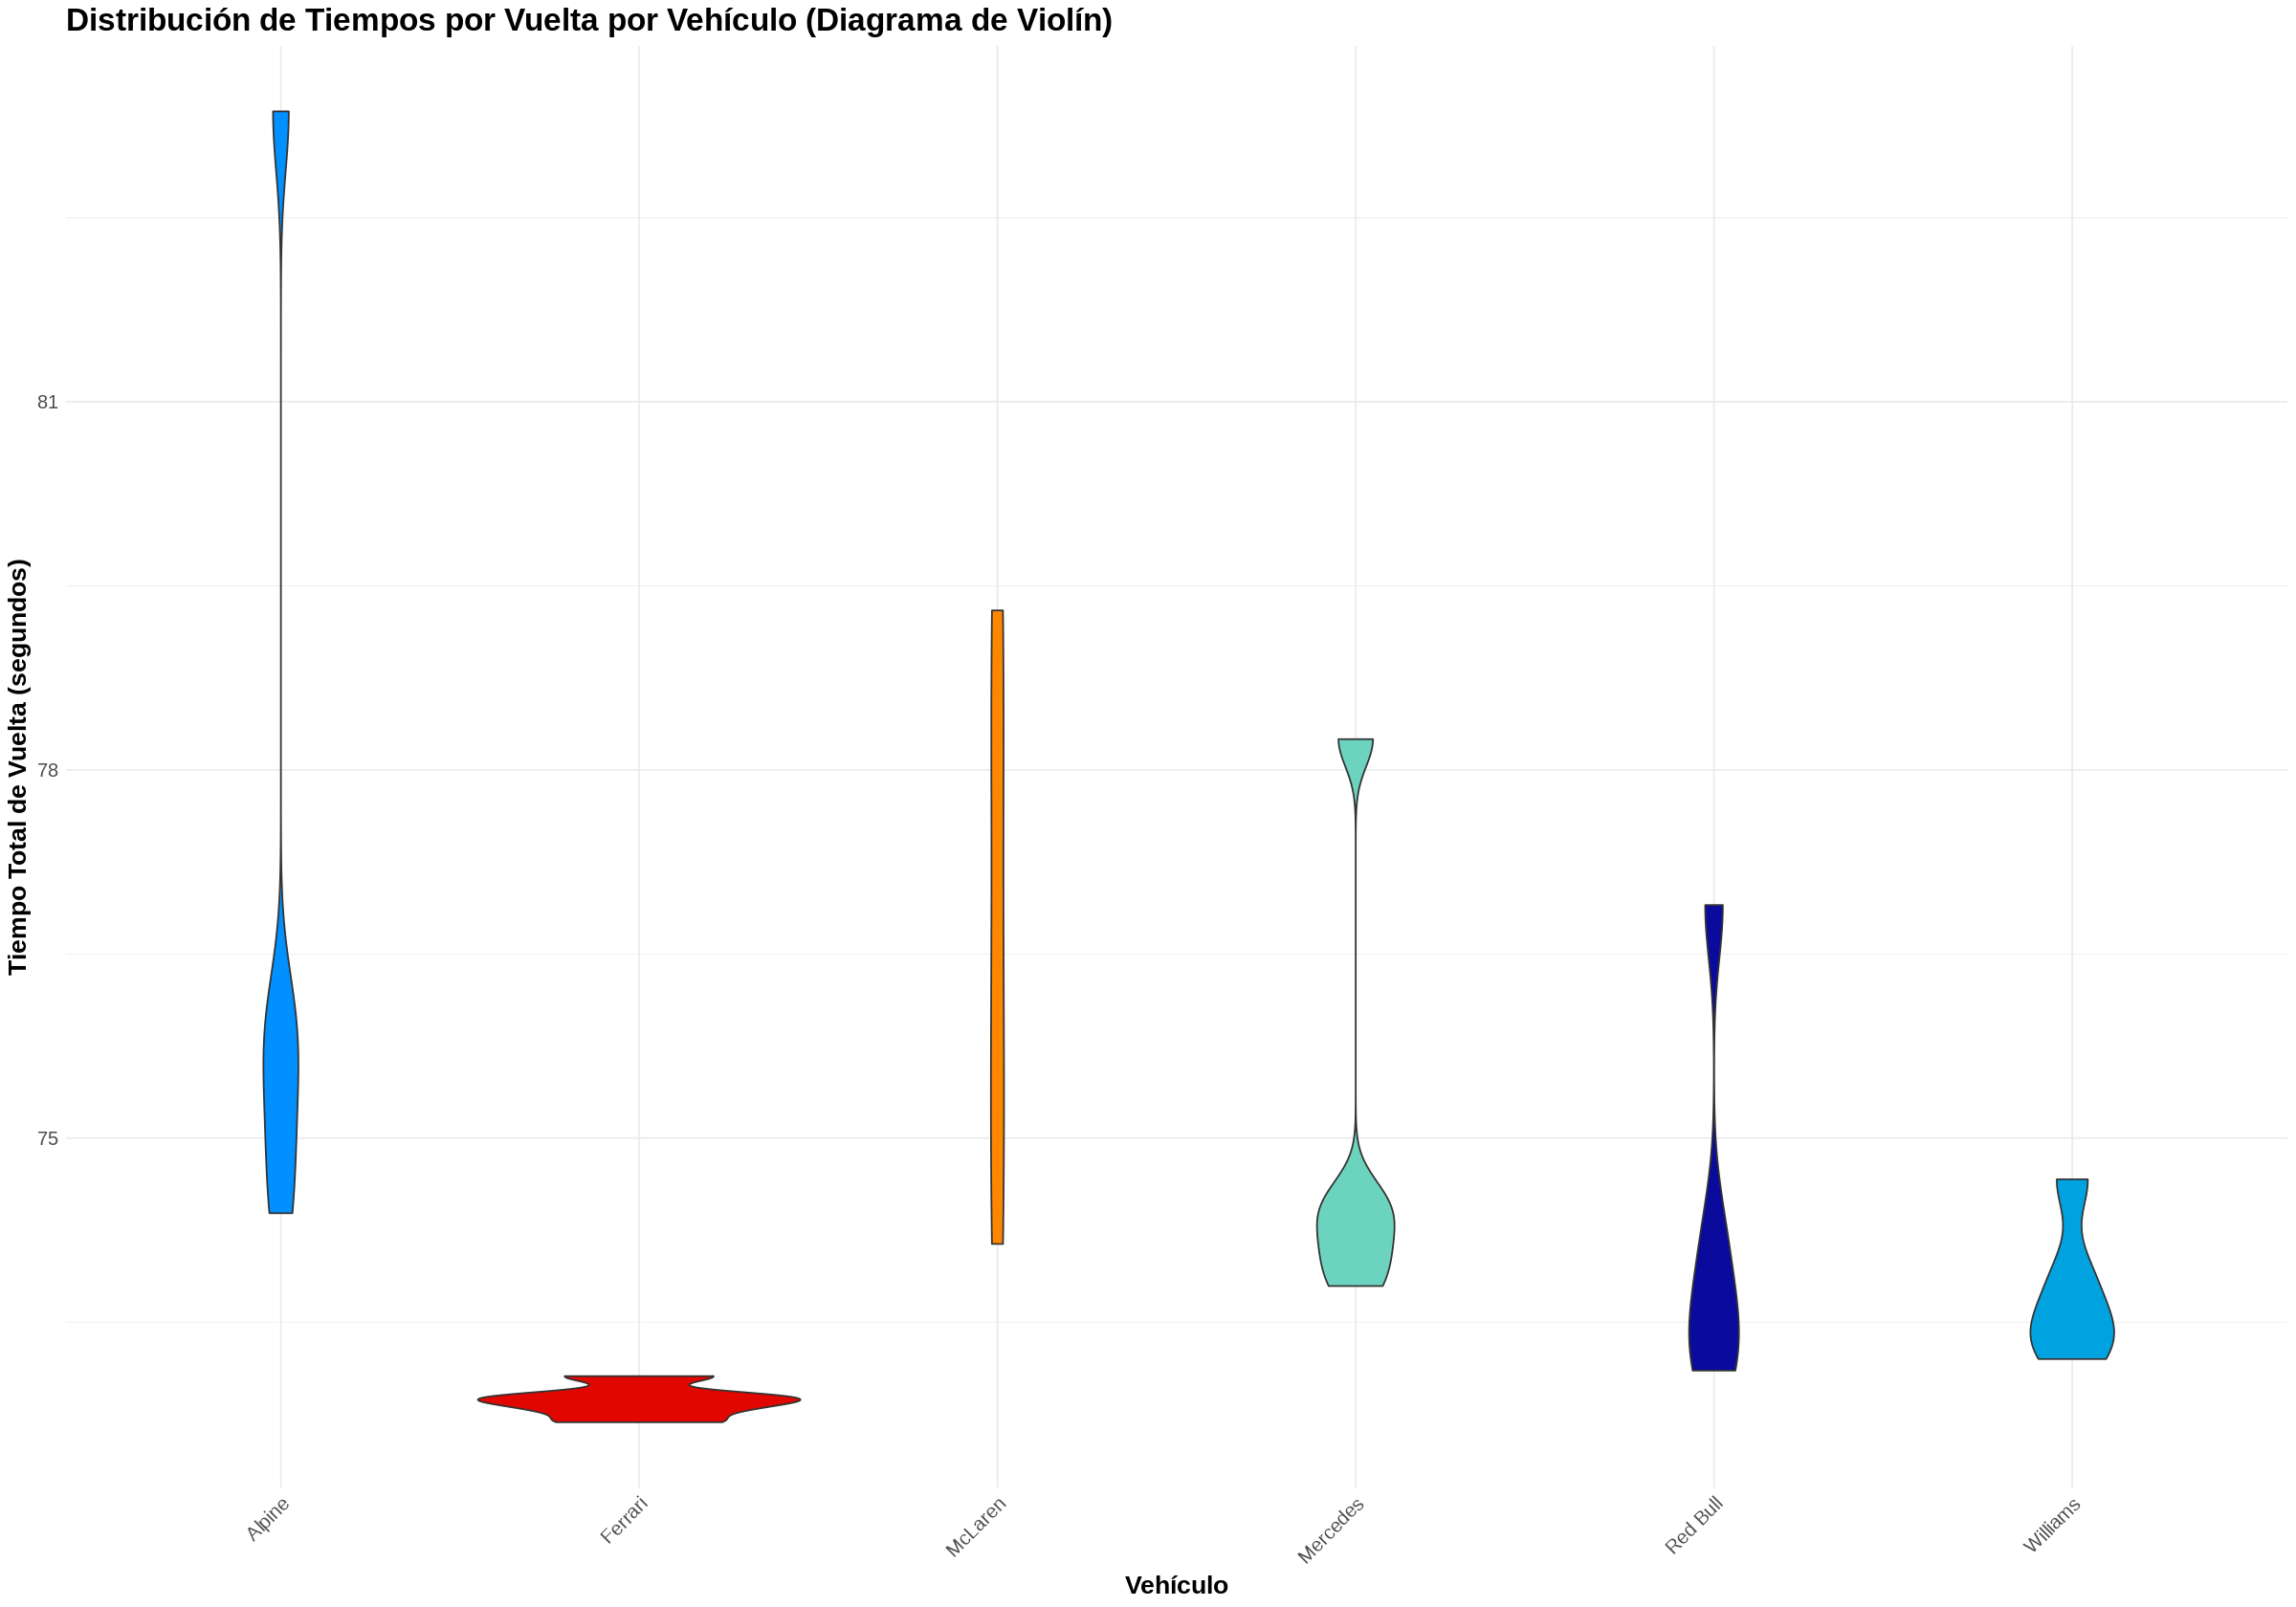

In [109]:
lap_times_summary_full <- lap_times_summary %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

ggplot(lap_times_summary_full, aes(x = full_carId, y = total_lap_time, fill = carId)) +
  geom_violin() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Distribución de Tiempos por Vuelta por Vehículo (Diagrama de Violín)",
    x = "Vehículo",
    y = "Tiempo Total de Vuelta (segundos)"
  ) +
  theme_minimal() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 20, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 12)
  )

In [119]:
lap_times_summary_ordered <- lap_times_summary_full %>%
  arrange(desc(total_lap_time))

lap_times_summary_ordered

carId,lap_number,total_lap_time,full_carId
<chr>,<dbl>,<dbl>,<chr>
ALP,5,83.367,Alpine
MCL,5,79.300,McLaren
MCL,1,78.713,McLaren
MER,1,78.251,Mercedes
RED,1,76.899,Red Bull
MCL,2,76.540,McLaren
ALP,1,76.028,Alpine
ALP,3,75.647,Alpine
ALP,2,75.026,Alpine


En este gráfico, la escala esta agrandada en el eje y (del valor mín al valor máx)

El diagrama de violín es similar al boxplot, pero añade una representación de la densidad de probabilidad de los datos, lo que permite observar la forma de la distribución y la moda (picos de densidad) de los tiempos de vuelta para cada vehículo.
Por otro lado, yendo al análisis de los datos en sí, podemos concluír que;
Ferrari y Williams son los que menos distribución tienen, todos sus tiempos se mantuvieron dentro de un rango específico, mientras que todo el resto muestra valores más dispersos.
En el caso de Alpine, como fue anteriormente mencionado, da un salto de sus tiempos anteriores(Más consistentes) a 83.4.
En el caso de Mercedes y Redbull, también vemos que sus datos están dispersos, aunque no de forma tan extrema como Alpine.
Por último, McClaren parece tener una distribución simétrica - la diferencia entre un tiempo y otro es muy similar, haciendo que tanto en el boxplot como en el violín se vean uniformes sus representaciones gráficas.

#Actividad 4

Elabore un cuadro donde se muestre para cada uno de los vehículos, el mejor tiempo de vuelta (lap_time), el mejor tiempo registrado en cada uno de los sectores y la velocidad máxima registrada en cada uno de los vehículos. El gráfico debe estar ordenado en base al mejor tiempo de vuelta del más rápido al más lento.

In [115]:
best_lap_overall <- lap_times_summary %>%
  group_by(carId) %>%
  summarise(best_lap_time = min(total_lap_time, na.rm = TRUE))

sector_times_raw <- telemetria %>%
  filter(binIndex %in% c(1430, 2861, 4293)) %>%
  select(carId, lap_number, binIndex, lap_time) %>%
  arrange(carId, lap_number, binIndex)

sector_times_pivot <- sector_times_raw %>%
  pivot_wider(
    names_from = binIndex,
    values_from = lap_time,
    names_prefix = "bin_"
  )

sector_times_calculated <- sector_times_pivot %>%
  mutate(
    sector1_time = bin_1430,
    sector2_time = bin_2861 - bin_1430,
    sector3_time = bin_4293 - bin_2861
  ) %>%
  select(carId, lap_number, sector1_time, sector2_time, sector3_time)

best_sector_times <- sector_times_calculated %>%
  group_by(carId) %>%
  summarise(
    best_sector1 = min(sector1_time, na.rm = TRUE),
    best_sector2 = min(sector2_time, na.rm = TRUE),
    best_sector3 = min(sector3_time, na.rm = TRUE)
  )

max_velocity_overall <- telemetria %>%
  group_by(carId) %>%
  summarise(max_velocity = max(velocidad, na.rm = TRUE))

summary_table <- best_lap_overall %>%
  left_join(best_sector_times, by = "carId") %>%
  left_join(max_velocity_overall, by = "carId") %>%
  arrange(best_lap_time)

summary_table

carId,best_lap_time,best_sector1,best_sector2,best_sector3,max_velocity
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FER,72.684,21.6900,28.7750,22.000,315.8166
RED,73.105,21.6807,29.3407,21.991,316.1590
WIL,73.199,21.7920,29.0250,22.011,316.1489
MER,73.794,21.9200,29.7240,22.100,316.0714
MCL,74.137,22.1480,29.6665,22.198,315.7055
ALP,74.388,22.1647,29.8417,22.126,315.3745




Este cuadro nos permite comparar el rendimiento de cada escudería para poder entender que:

- Excepto Alpine, todos los demás corredores tuvieron la misma velocidad; 316.
- Ferrari es el que mejor tiempo tuvo en general respecto de todos los demás.
- En el sector 3 fue donde menos variarion los tiempos, que puede deberse a la forma en la que el circuito de Interlagos está diseñado (22.0 - 22.2).
- Por lo recién explicado, el circuito dos es el que más curvas y complicaciones tiene, por lo que es lógico que en general todos los corredores hayan tardado más que en otros sectores y haya variado de forma más notoria el tiempo (28.8 - 29.8).
- A pesar de lo mostrado en otros sectores, en el sector 1 fue donde hubo más variabilidad (72.7 - 74.4).

#Actividad 5
Elabore un gráfico que represente las variaciones en las posiciones de cada una de los pilotos a lo largo de la carrera. En el eje de las abscisas (X) se deben mostrar las vueltas, mientras que en el eje de las ordenadas (Y) se indicará la posición ocupada por cada escudería.

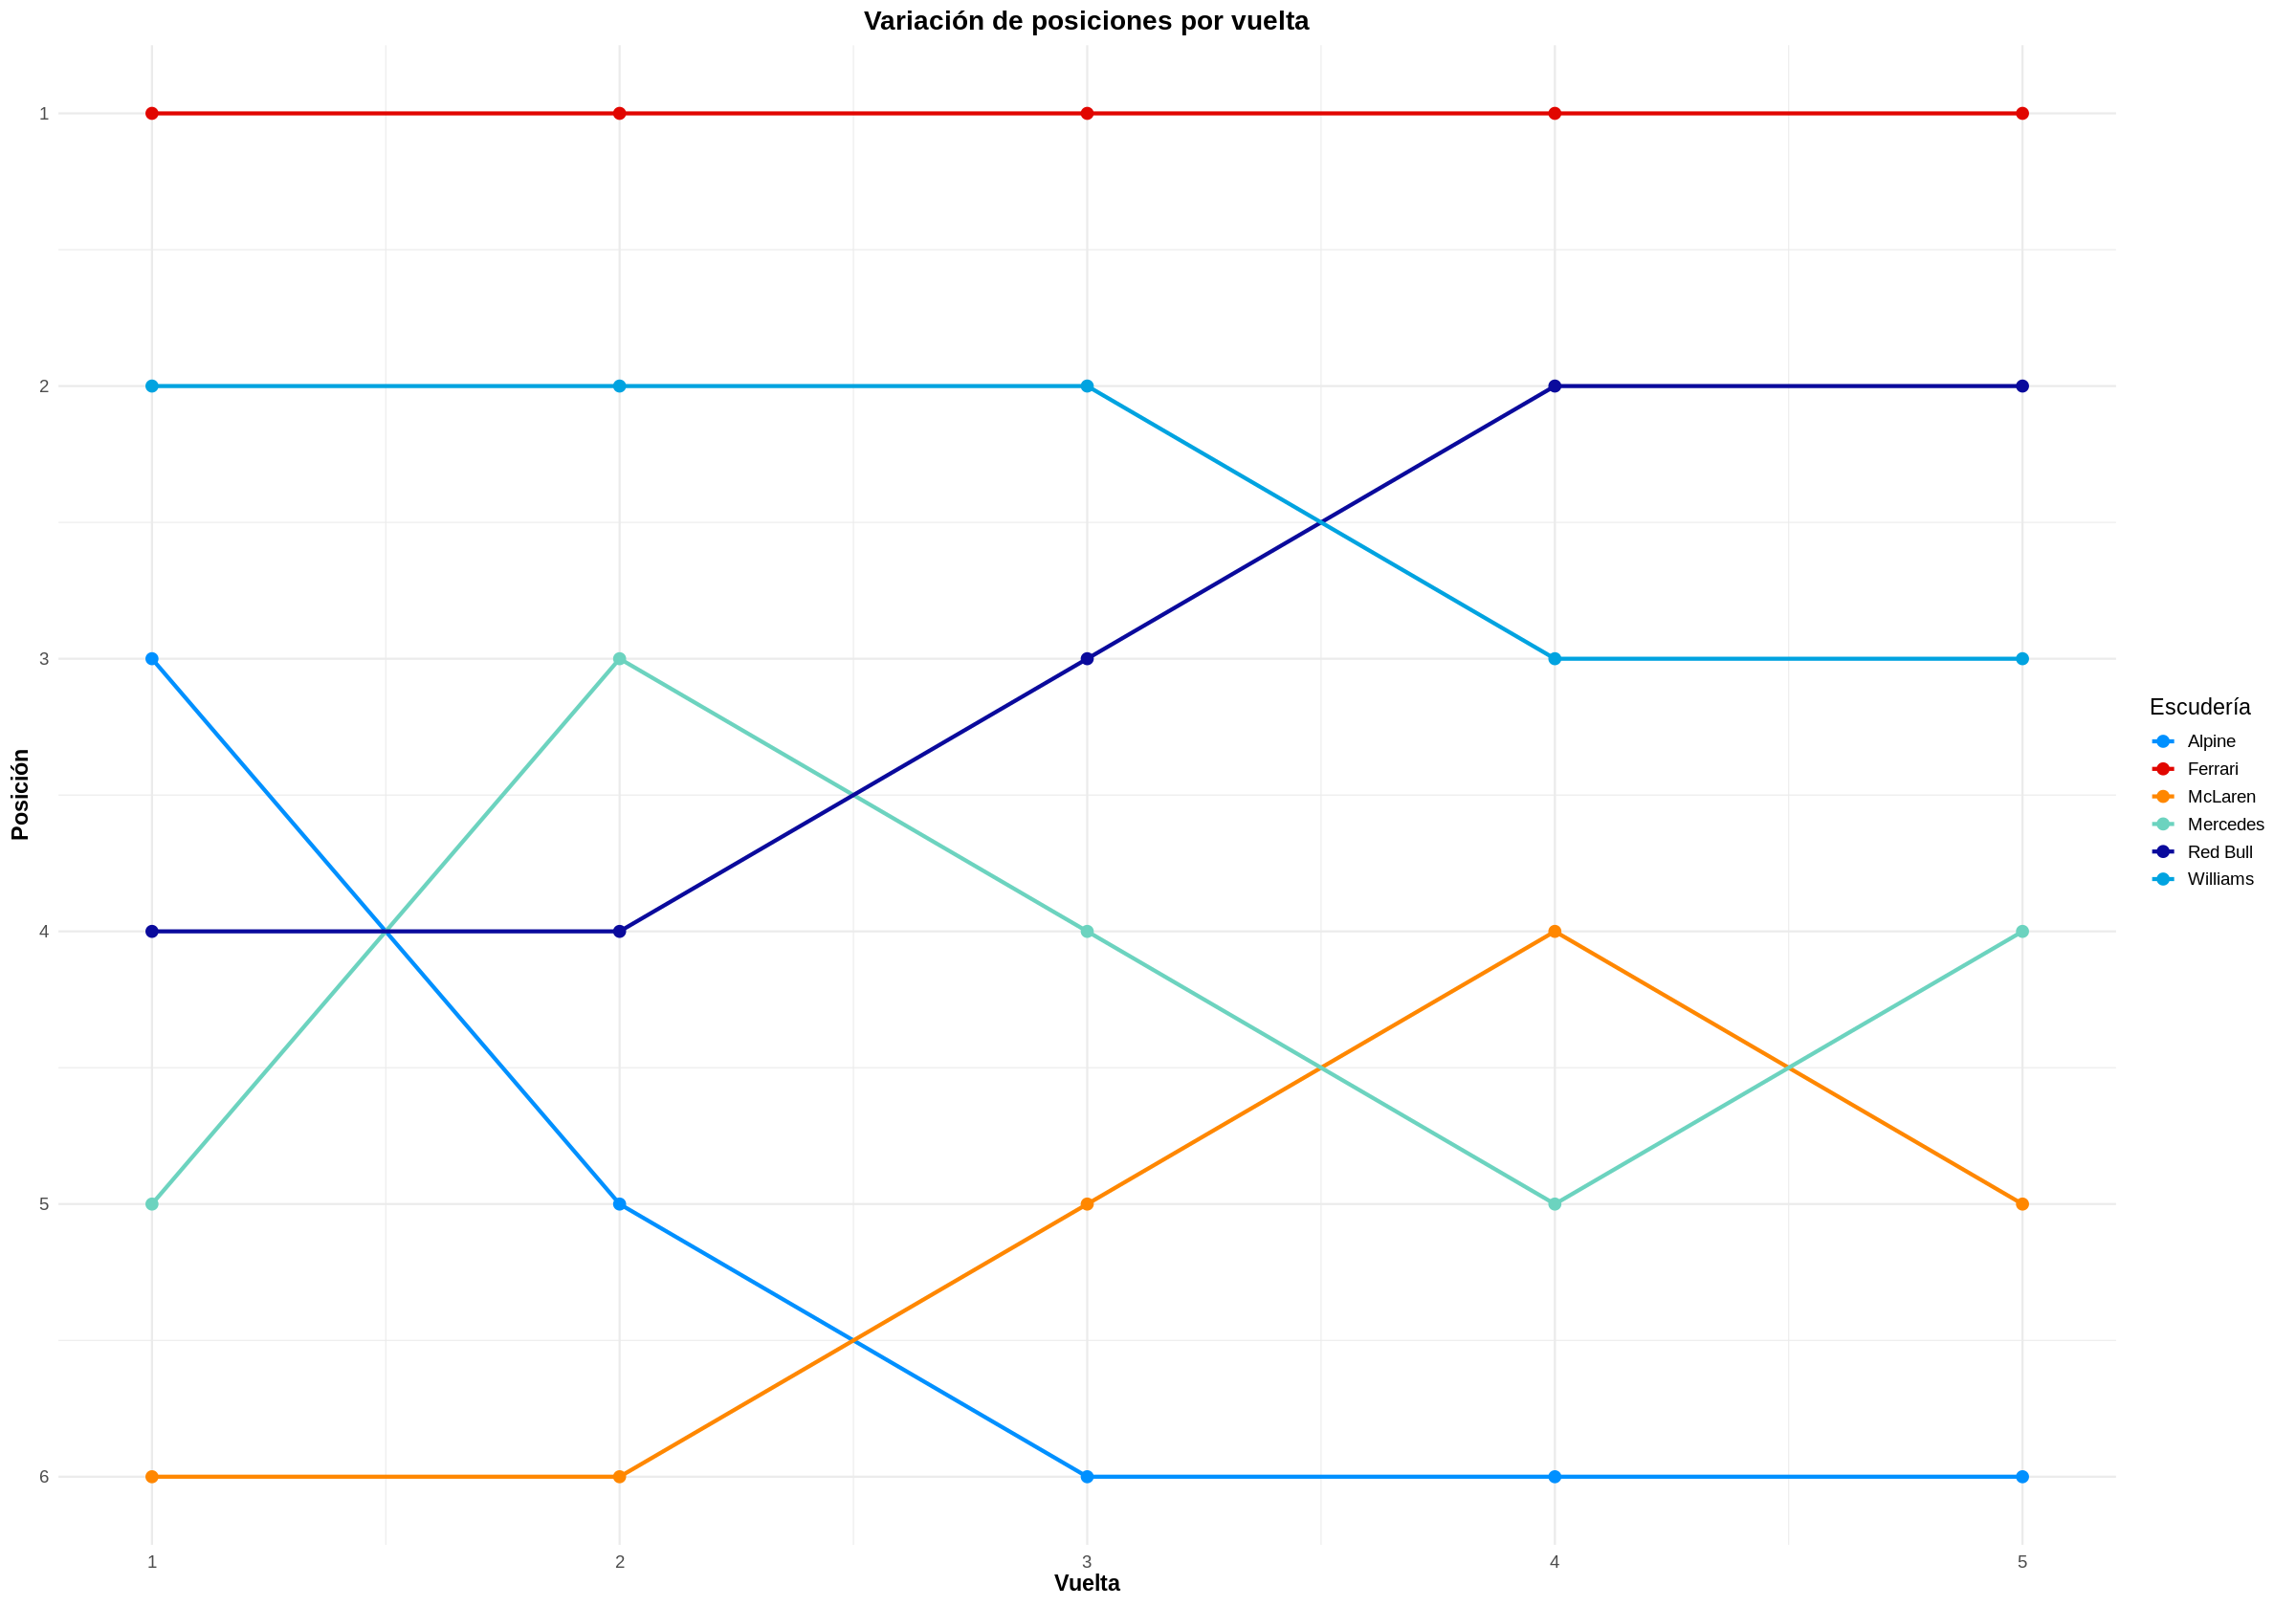

In [110]:
lap_positions <- lap_times_summary %>%
  group_by(lap_number) %>%
  arrange(total_lap_time, .by_group = TRUE) %>%
  mutate(position = row_number()) %>%
  ungroup()

ggplot(lap_positions,
       aes(x = lap_number,
           y = position,
           color = carId,
           group = carId)) +
  geom_line(size = 1.2) +
  geom_point(size = 3) +
  scale_y_reverse(breaks = 1:6) +
  scale_x_continuous(breaks = 1:5) +
  scale_color_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Variación de posiciones por vuelta",
    x = "Vuelta",
    y = "Posición",
    color = "Escudería"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title   = element_text(face = "bold", hjust = 0.5),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "right"
  )

Ferrari mantiene la primera posición en todas las vueltas, mostrando el mejor rendimiento y la mayor consistencia.

Mercedes mejora vuelta a vuelta y termina consolidándose en el segundo lugar, de P4 a P2.

Alpine se mantiene estable entre P2 y P3, con buen ritmo general.

Red Bull pierde rendimiento a lo largo de la carrera, cayendo de P3 a P6.
Williams y McLaren muestran variabilidad, alternando posiciones sin una tendencia clara.

#Actividad 6
Elabore un gráfico que muestre la velocidad máxima para cada uno de los vehículos, ordenado desde el más rápido al más lento. En el eje de las abscisas (X), se representarán los vehículos, mientras que en el eje de las ordenadas (Y) se plasmará la velocidad máxima por cada vehículo.

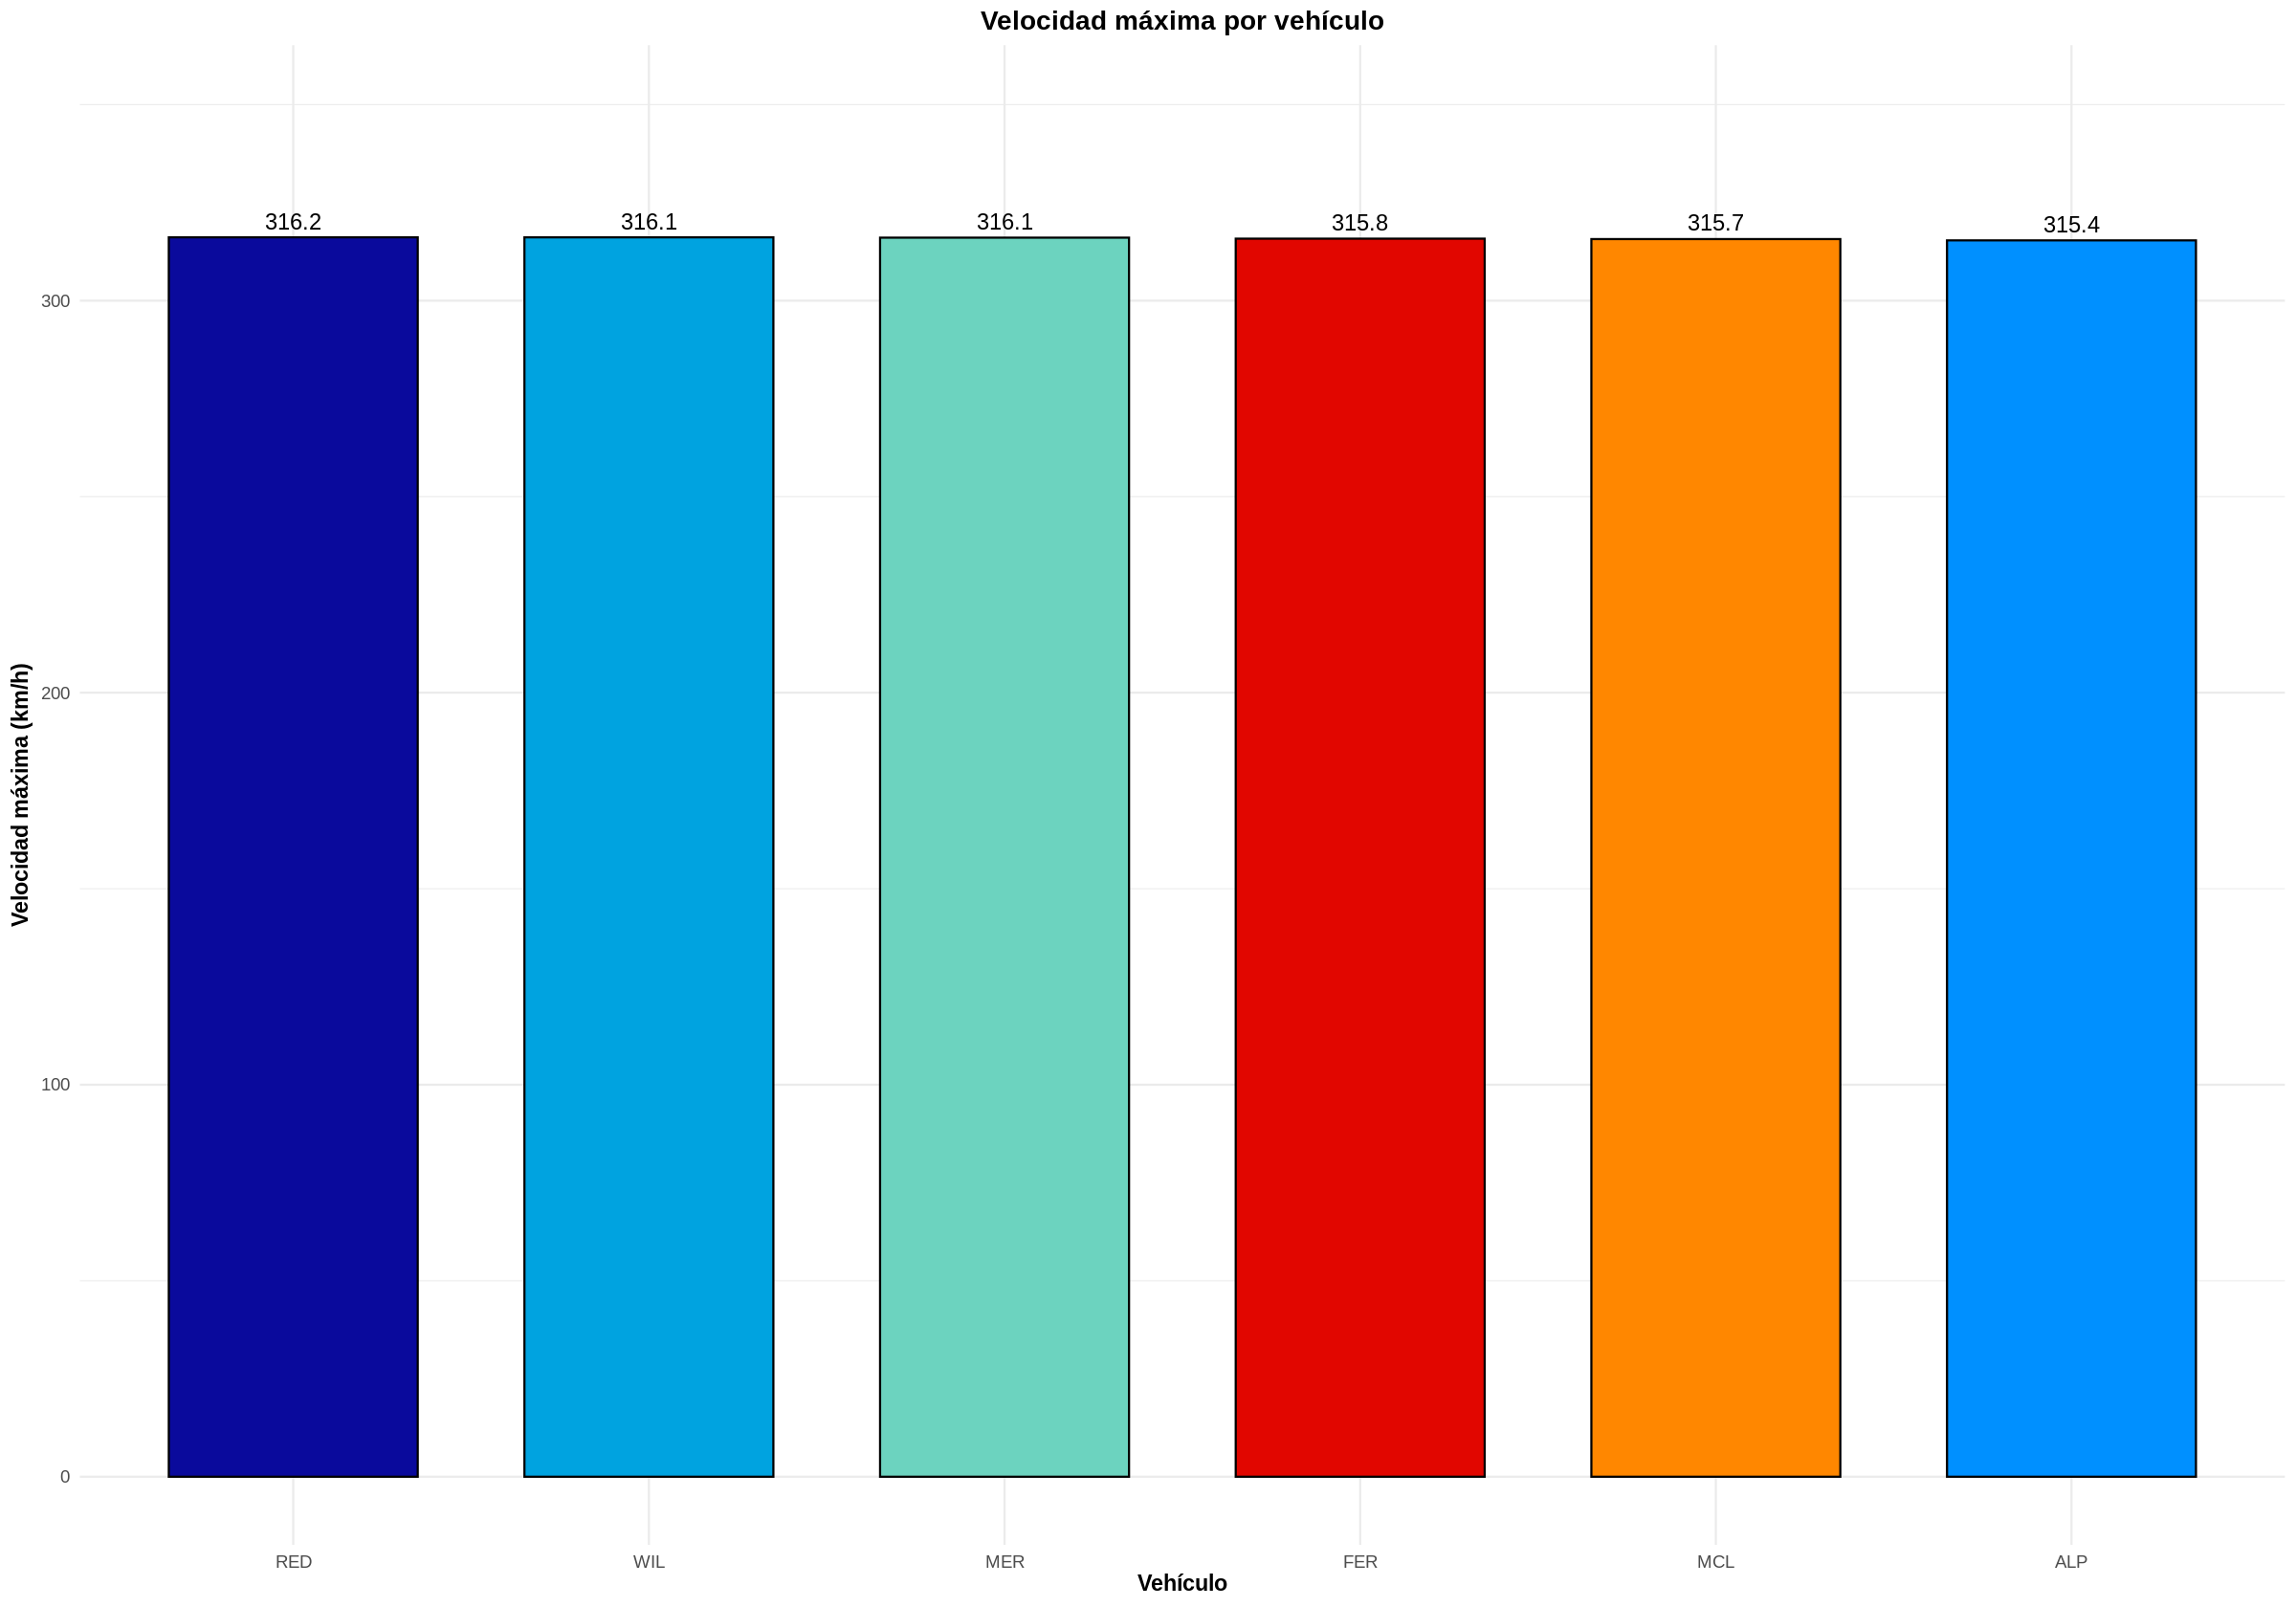

In [94]:
vel_plot <- summary_table %>%
  select(carId, max_velocity) %>%
  arrange(desc(max_velocity)) %>%
  mutate(carId = factor(carId, levels = carId))

ggplot(vel_plot, aes(x = carId, y = max_velocity, fill = carId)) +
  geom_col(color = "black", width = 0.7) +
  geom_text(aes(label = round(max_velocity, 1)),
            vjust = -0.5,
            size = 5) +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Velocidad máxima por vehículo",
    x = "Vehículo",
    y = "Velocidad máxima (km/h)"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title  = element_text(face = "bold", hjust = 0.5),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    legend.position = "none"
  ) +
  ylim(0, max(vel_plot$max_velocity) * 1.1)

Las velocidades máximas registradas muestran diferencias prácticamente diminutas entre los seis vehículos, con un rango menor a 1 km/h entre el más rápido y el más lento. Red Bull (RED) alcanza la mayor velocidad punta, seguido muy de cerca por Williams (WIL) y Mercedes (MER). Ferrari (FER), McLaren (MCL) y Alpine (ALP) completan la tabla con valores prácticamente equivalentes.

En general, los resultados indican que ninguno de los autos presenta una ventaja clara en rectas, lo que sugiere configuraciones aerodinámicas similares o un trazado que no favorece grandes diferencias en velocidad máxima.

#Actividad 7
 Represente gráficamente la información correspondiente a las máximas velocidades por vuelta para cada vehículo mediante diagramas de caja (boxplots) y diagrama de violín. Gráfico similar al punto 2. Son dos gráficos por separado.

In [79]:
vel_max_vuelta <- telemetria_vueltas_invalidadas %>%
  group_by(carId, lap_number) %>%
  summarise(max_speed_lap = max(velocidad, na.rm = TRUE), .groups = "drop")

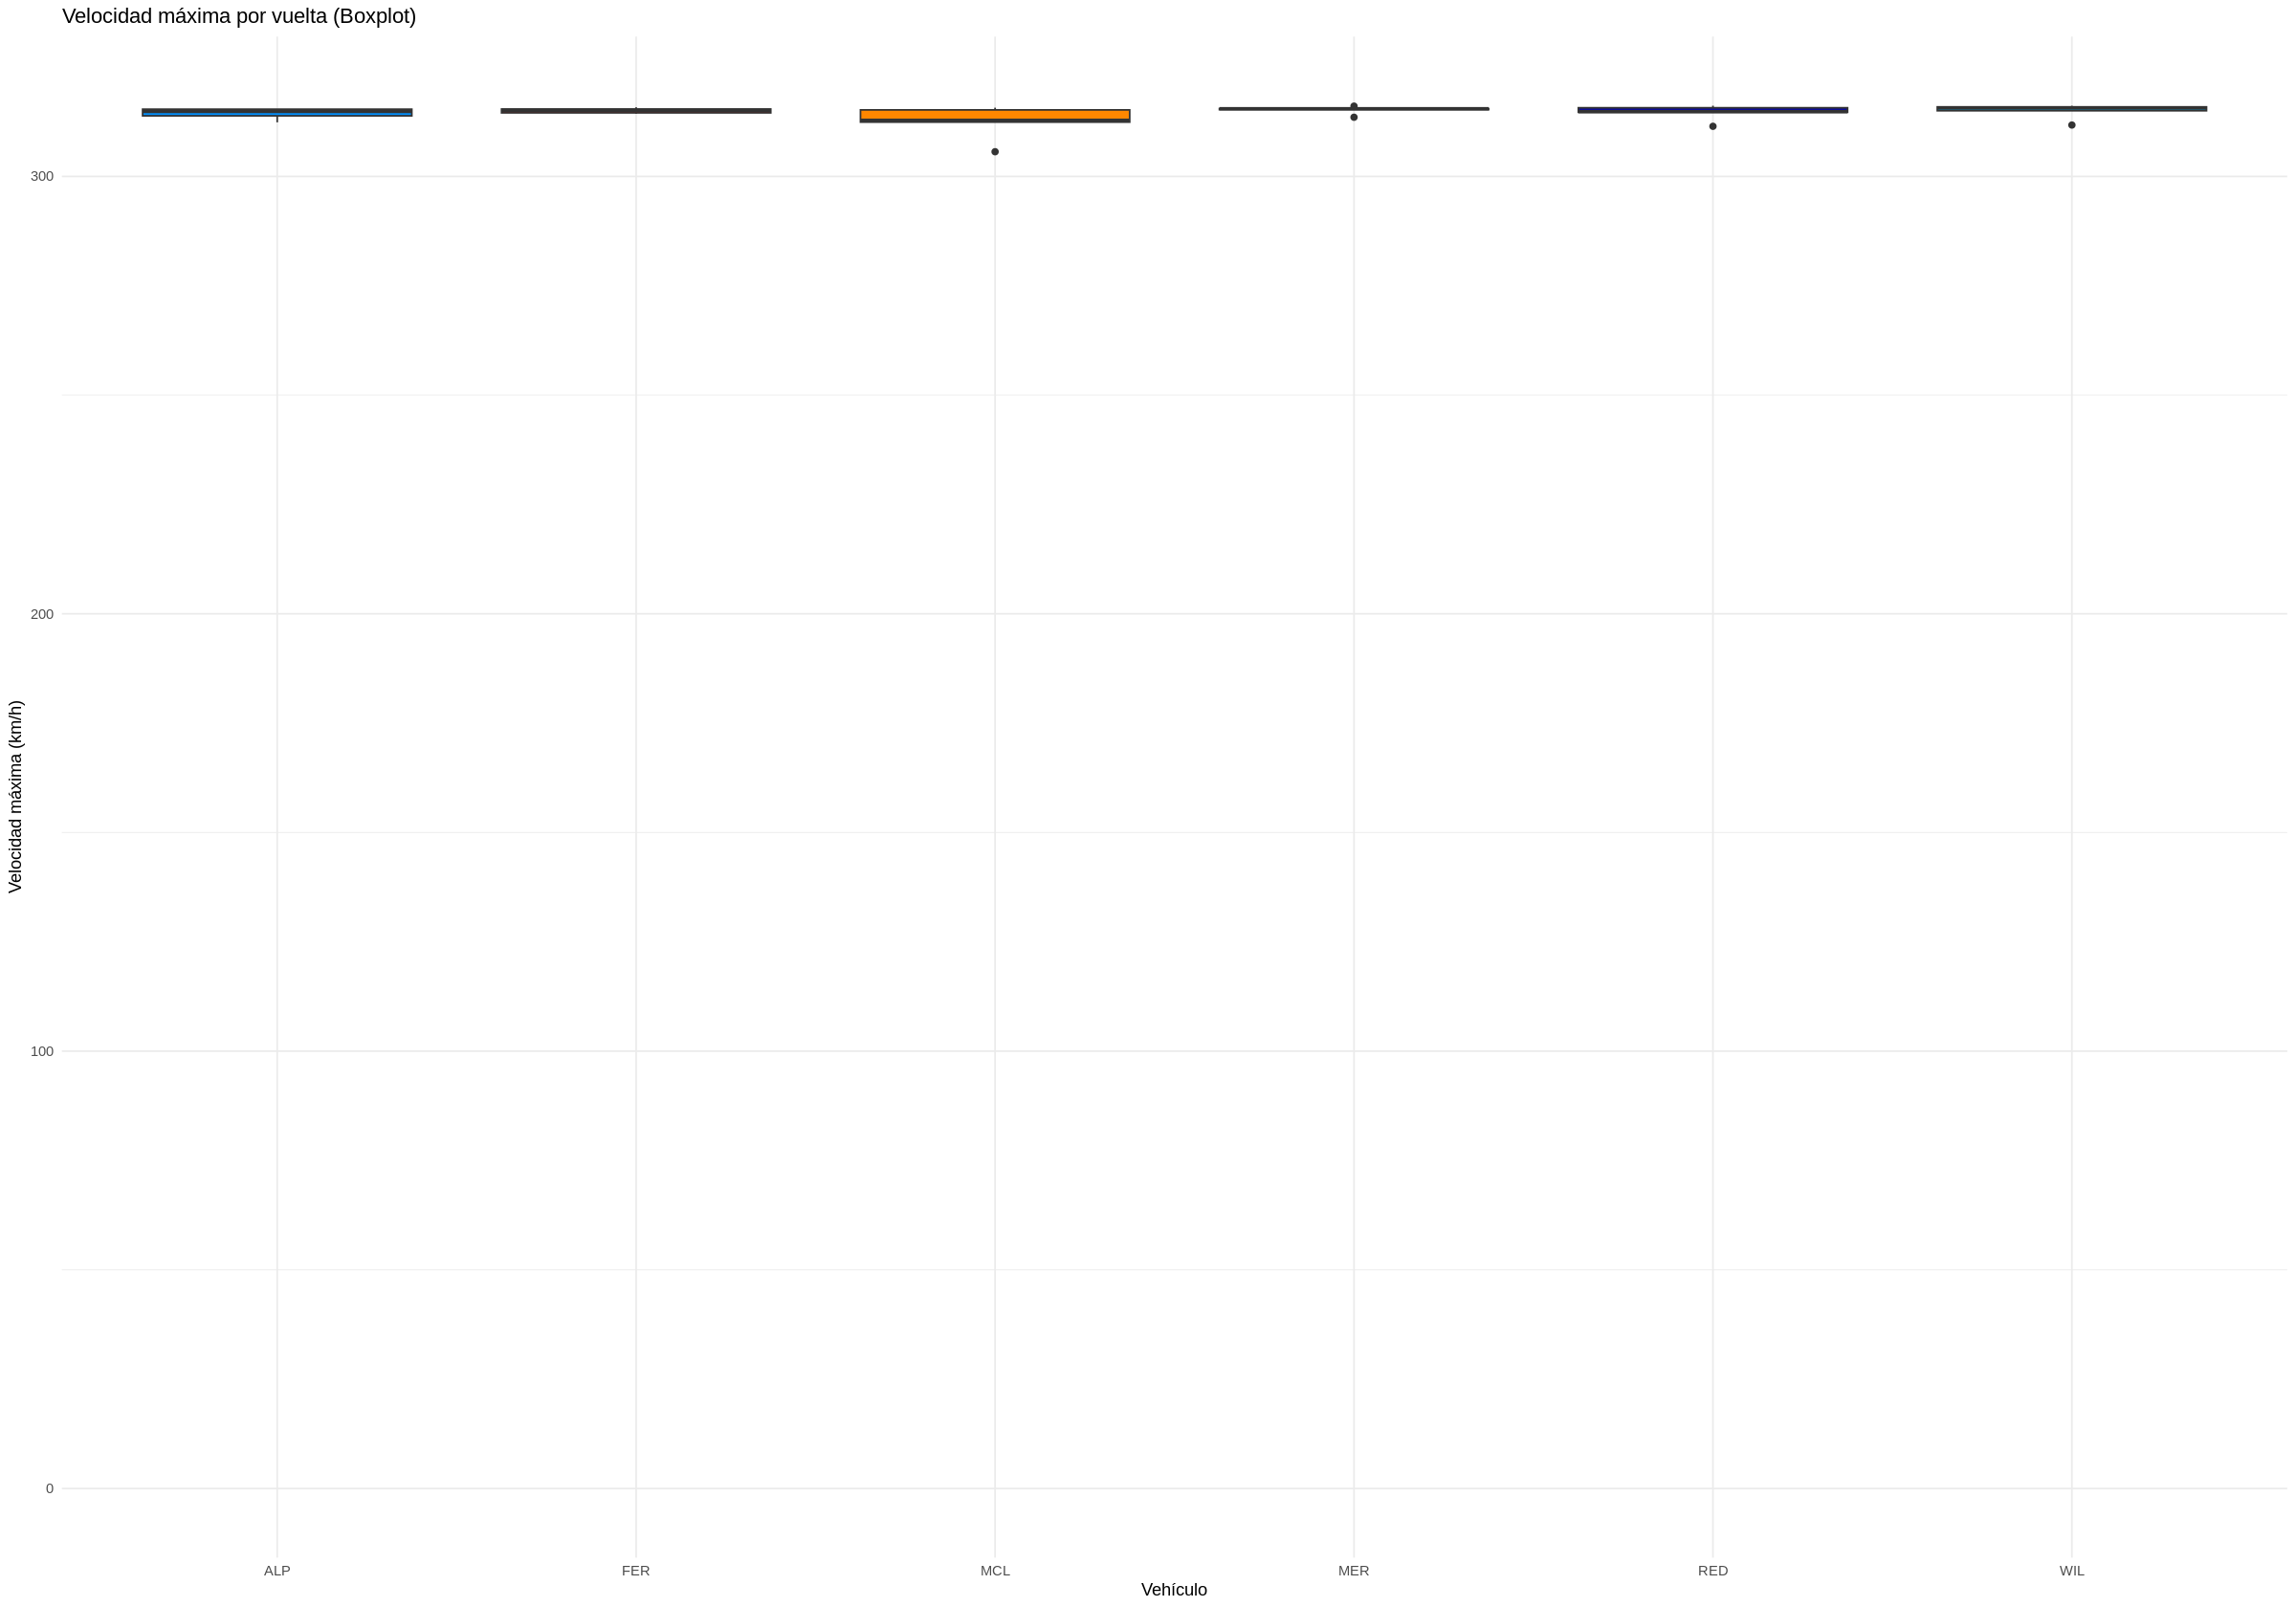

In [95]:
ggplot(vel_max_vuelta, aes(x = carId, y = max_speed_lap, fill = carId)) +
  geom_boxplot() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Velocidad máxima por vuelta (Boxplot)",
    x = "Vehículo",
    y = "Velocidad máxima (km/h)"
  ) +
  theme_minimal() +
  theme(legend.position = "none") +
  expand_limits(y = 0)

En este gráfico dejamos la escala real en el eje y (del 0 al valor máximo)

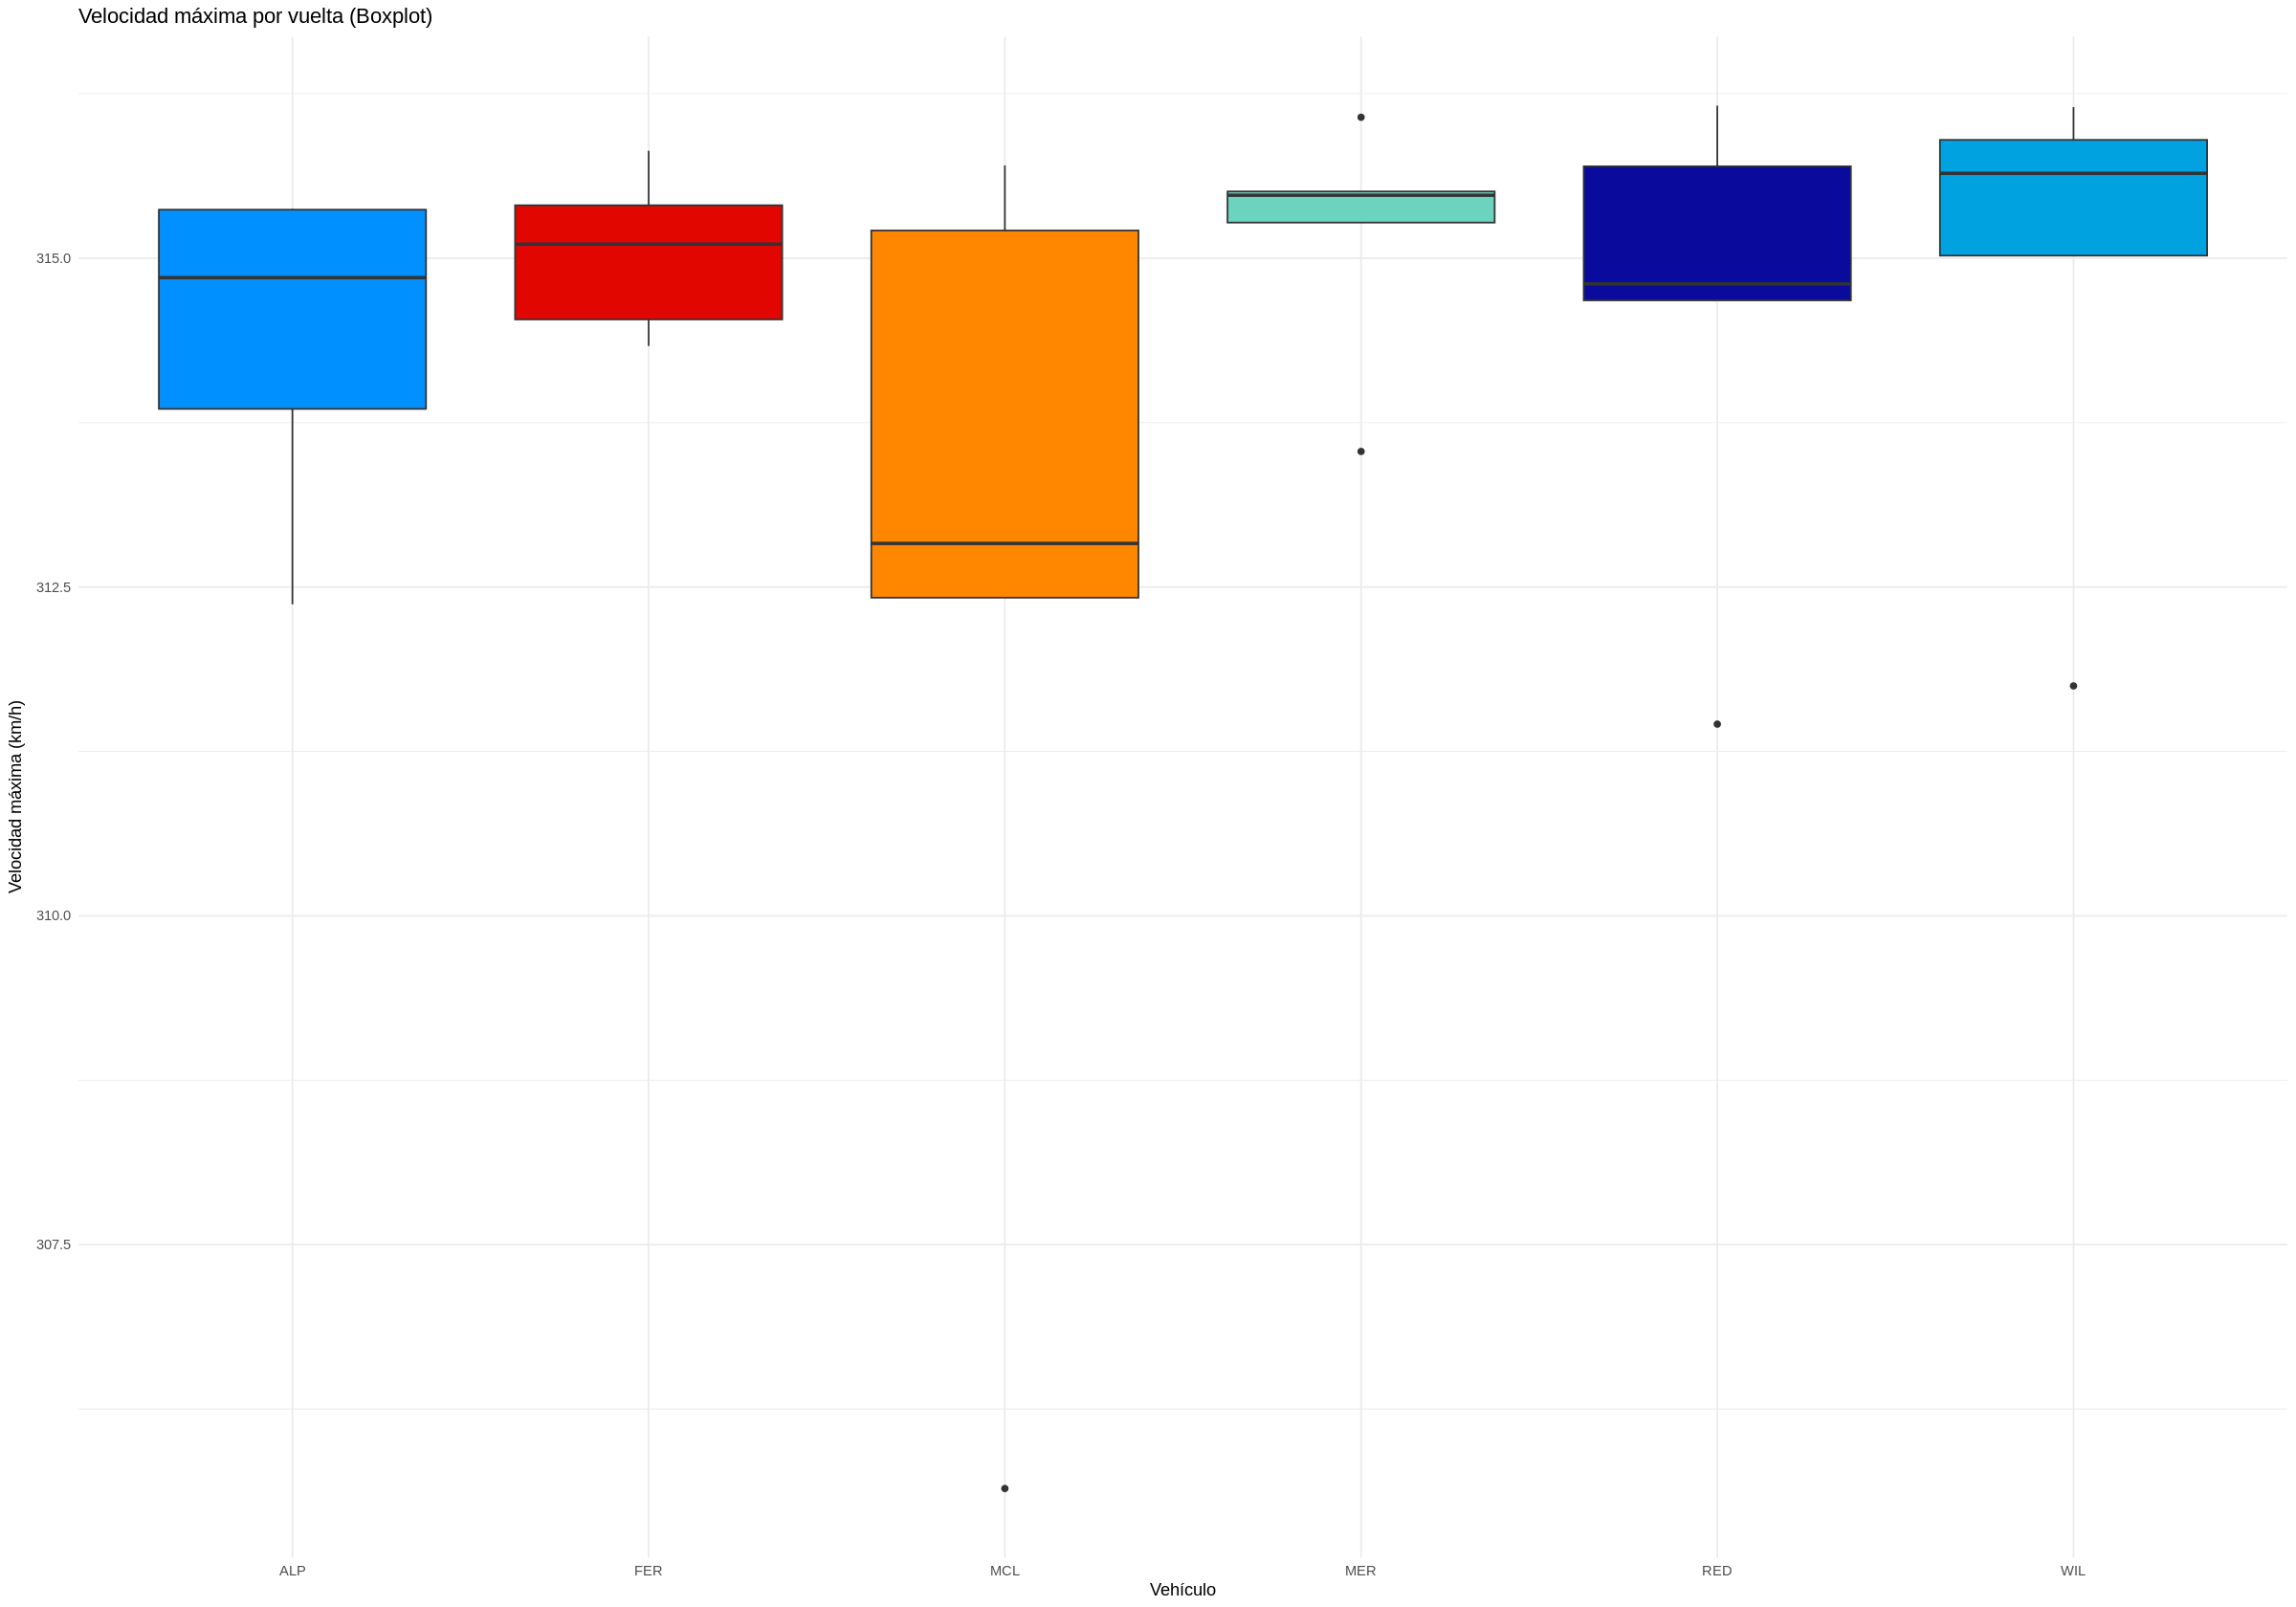

In [96]:
ggplot(vel_max_vuelta, aes(x = carId, y = max_speed_lap, fill = carId)) +
  geom_boxplot() +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Velocidad máxima por vuelta (Boxplot)",
    x = "Vehículo",
    y = "Velocidad máxima (km/h)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

En este gráfico, la escala esta agrandada en el eje y (del valor mín al valor máx)

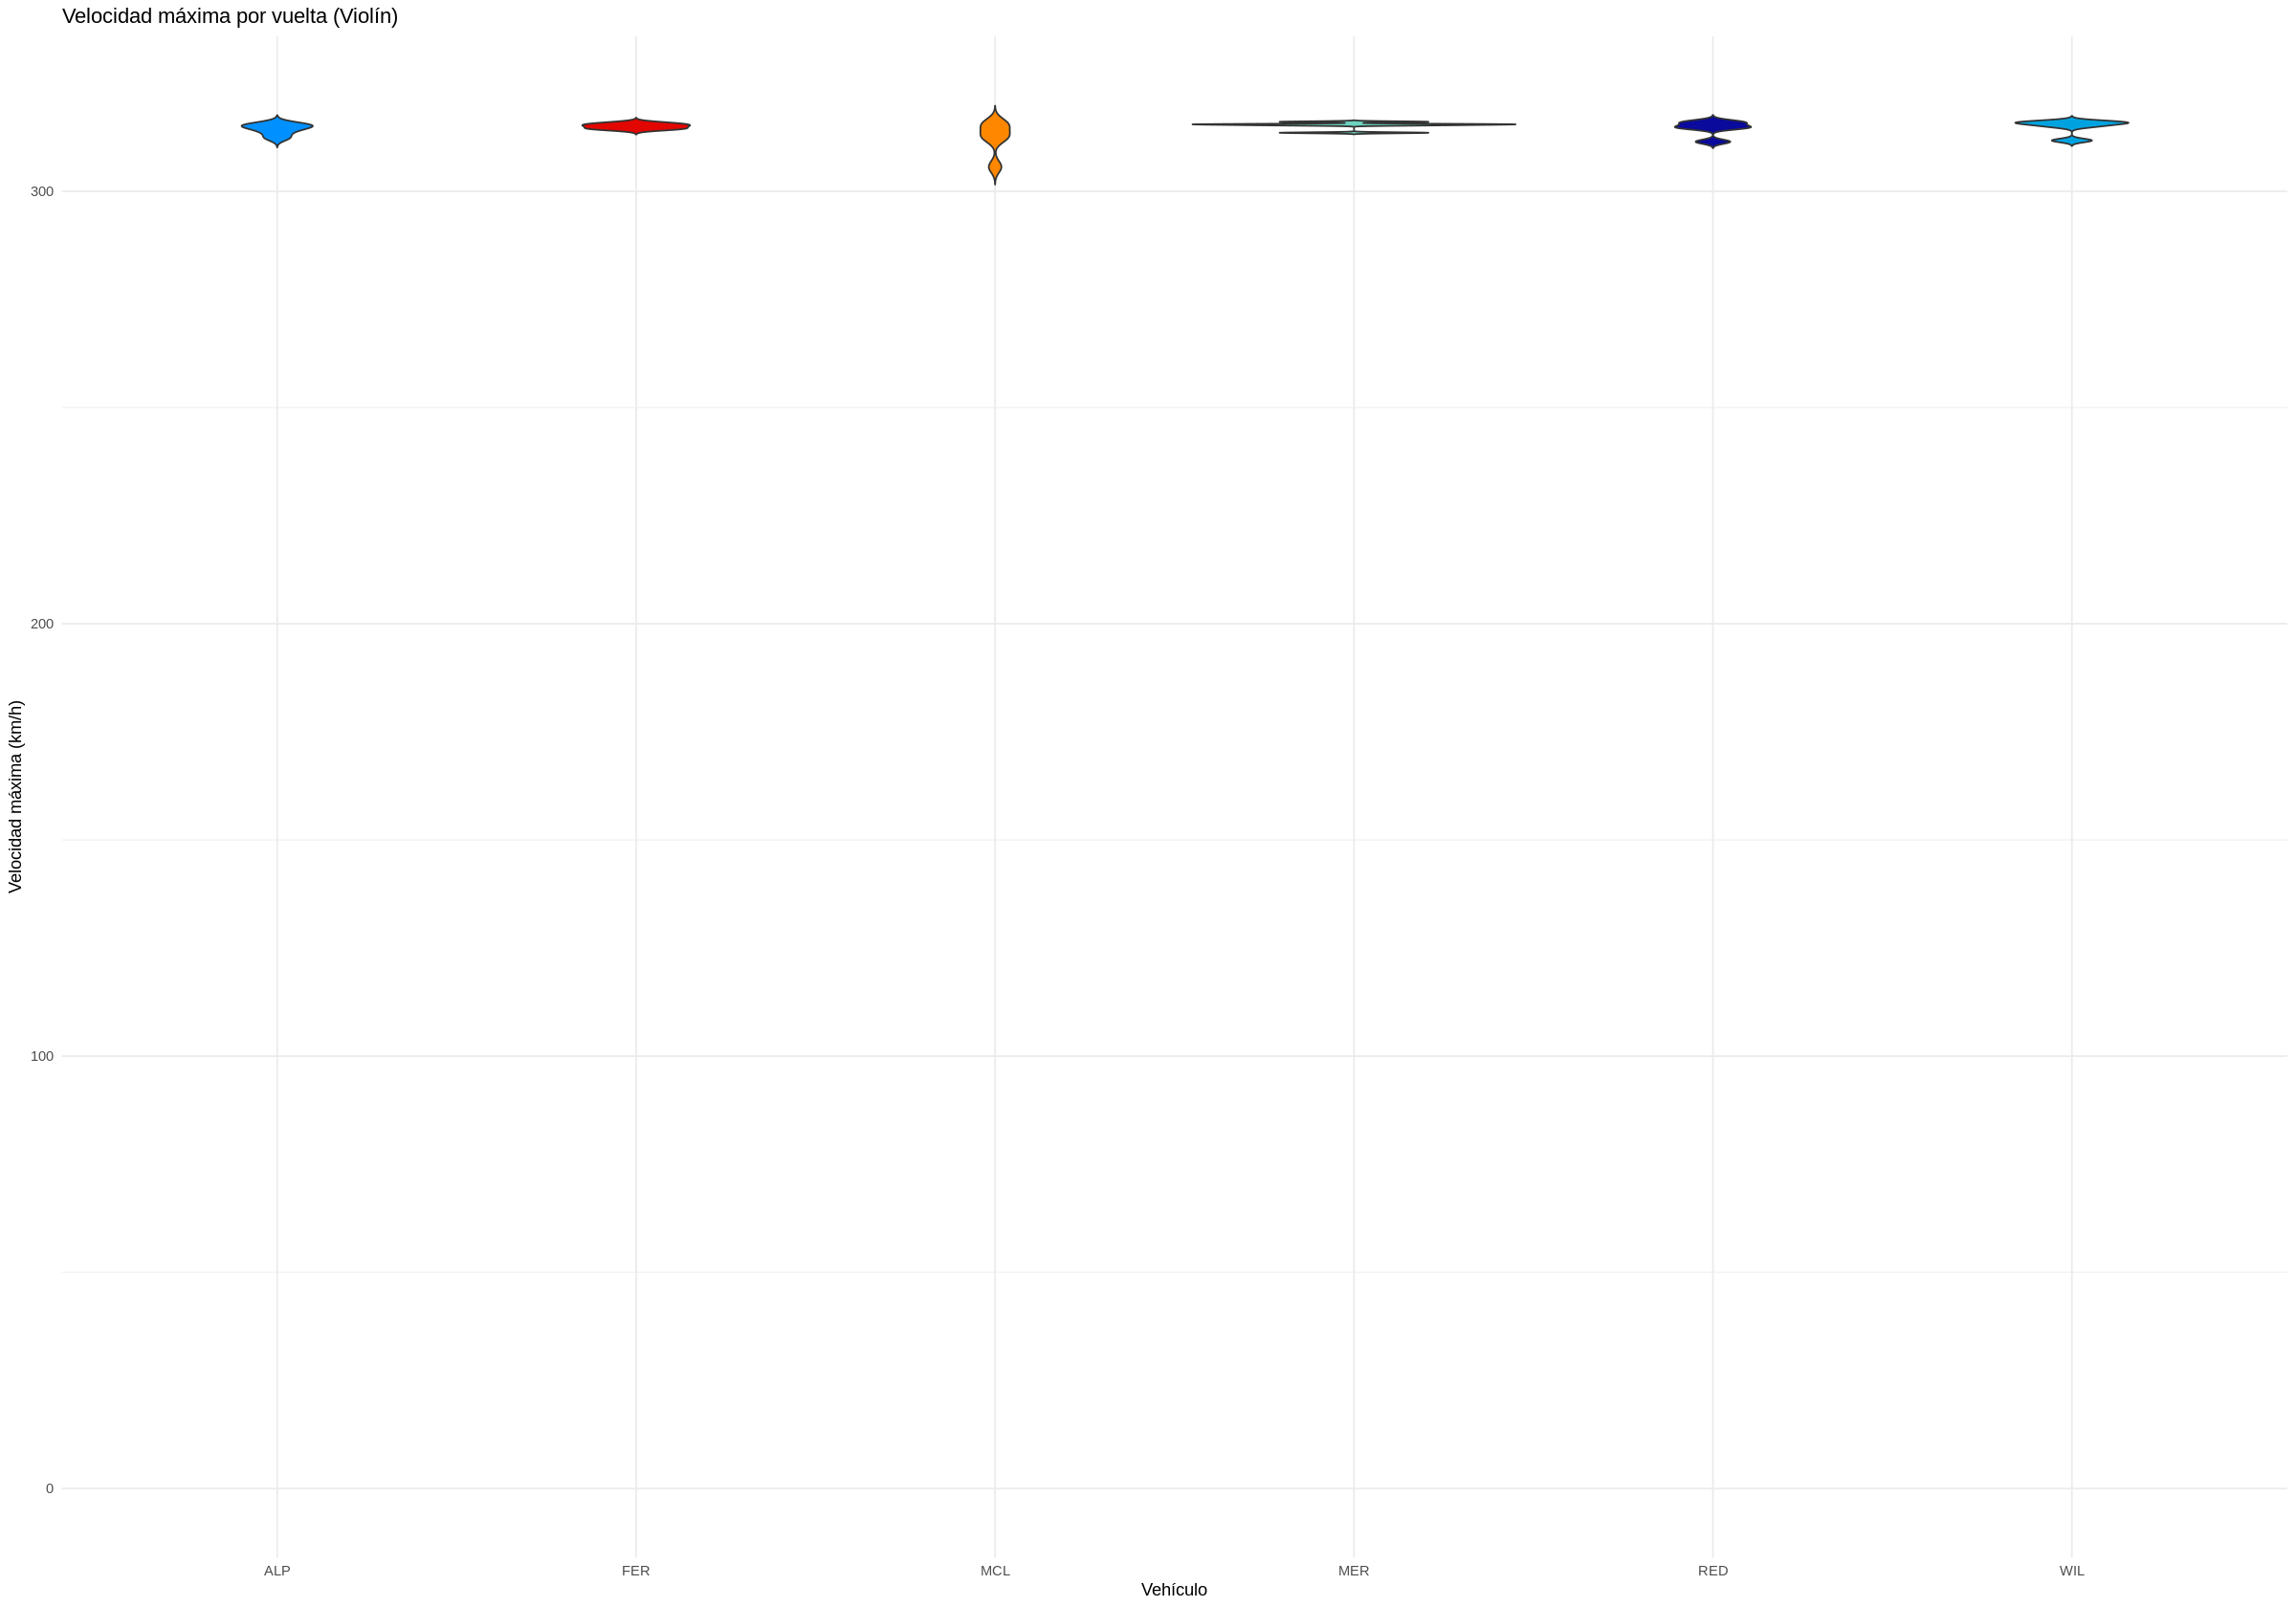

In [97]:
ggplot(vel_max_vuelta, aes(x = carId, y = max_speed_lap, fill = carId)) +
  geom_violin(trim = FALSE) +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Velocidad máxima por vuelta (Violín)",
    x = "Vehículo",
    y = "Velocidad máxima (km/h)"
  ) +
  theme_minimal() +
  theme(legend.position = "none") +
  expand_limits(y = 0)

En este gráfico dejamos la escala real en el eje y (del 0 al valor máximo)

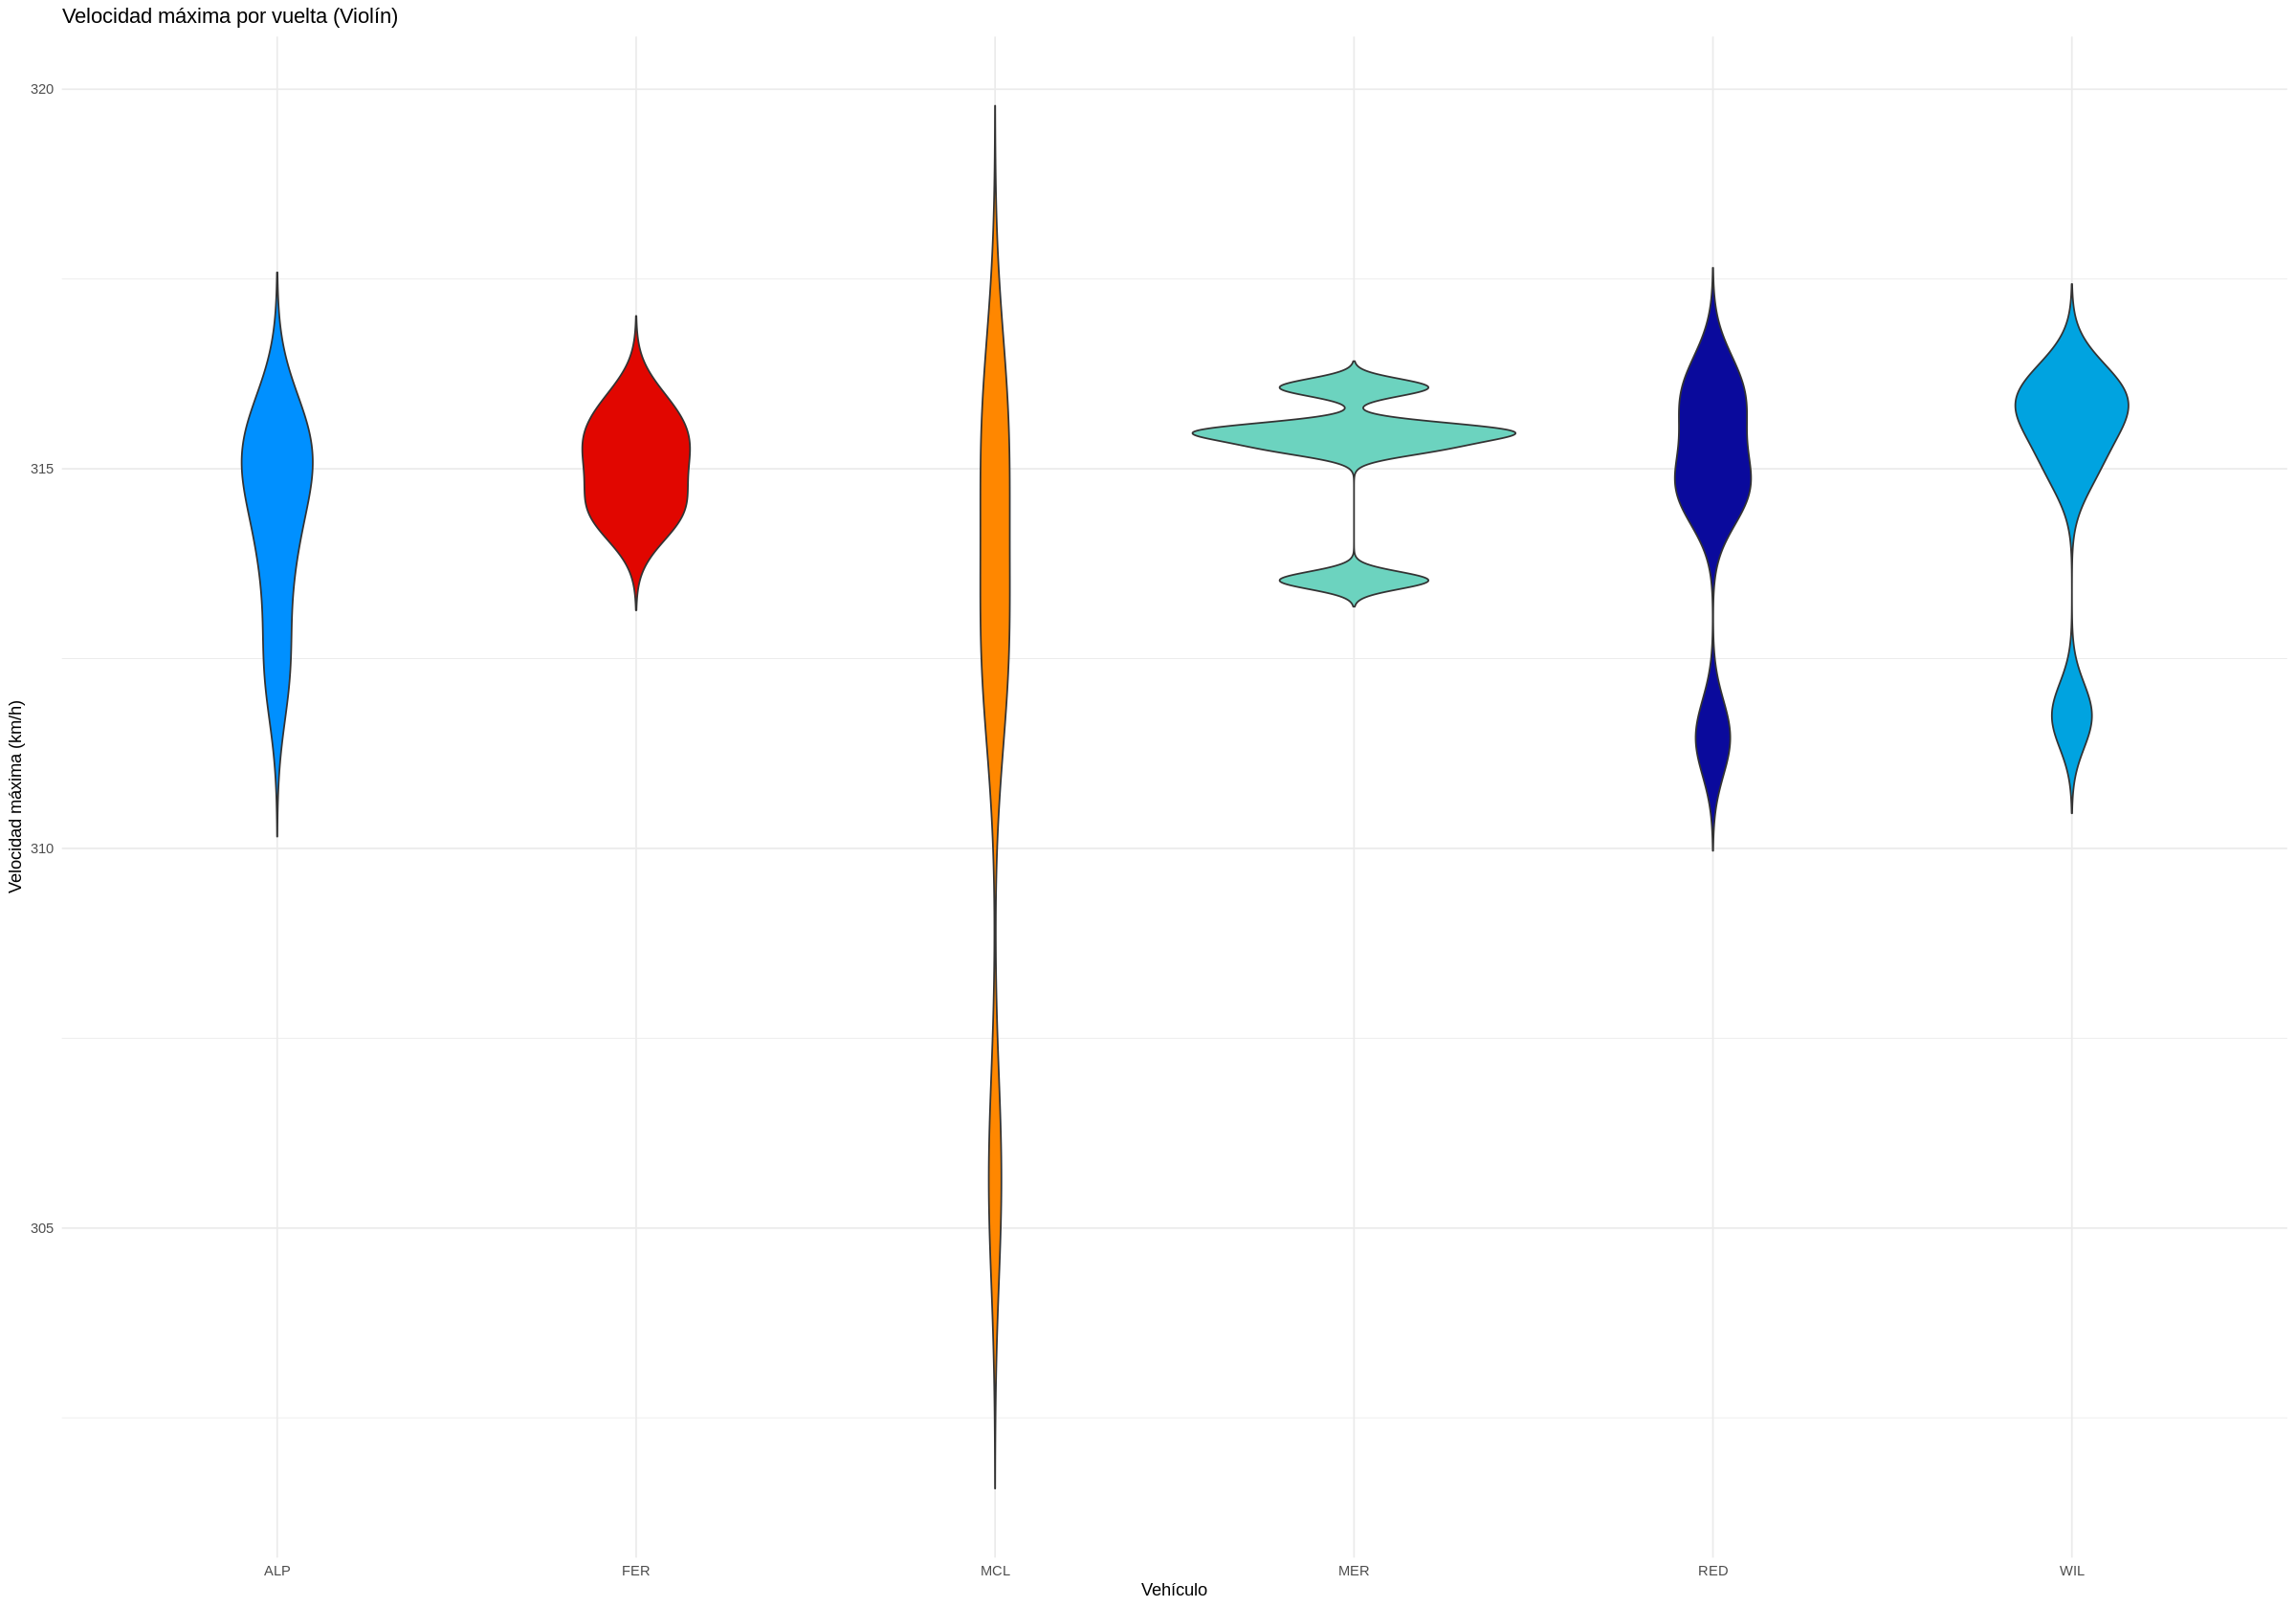

In [98]:
ggplot(vel_max_vuelta, aes(x = carId, y = max_speed_lap, fill = carId)) +
  geom_violin(trim = FALSE) +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Velocidad máxima por vuelta (Violín)",
    x = "Vehículo",
    y = "Velocidad máxima (km/h)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

In [125]:
lap_times_summary_ordered <- vel_max_vuelta %>%
  arrange(max_speed_lap)

lap_times_summary_ordered

carId,lap_number,max_speed_lap
<chr>,<dbl>,<dbl>
MCL,1,305.6458
RED,1,311.4575
WIL,1,311.7480
ALP,1,312.3685
MCL,2,312.4189
MCL,5,312.8311
MER,1,313.5304
ALP,2,313.8539
FER,1,314.3328


En este gráfico, la escala esta agrandada en el eje y (del valor mín al valor máx)

#Actividad 8

Elabore un gráfico que muestren los mejores tiempos para cada uno de los vehículos en cada uno de los sectores, ordenando los tiempos de menor a mayor. En el eje de las abscisas (X), se representarán los vehículos, mientras que en el eje de las ordenadas (Y) se plasmará el tiempo empleado por cada.


 Generando Gráfico 7 (Sectores Separados)...


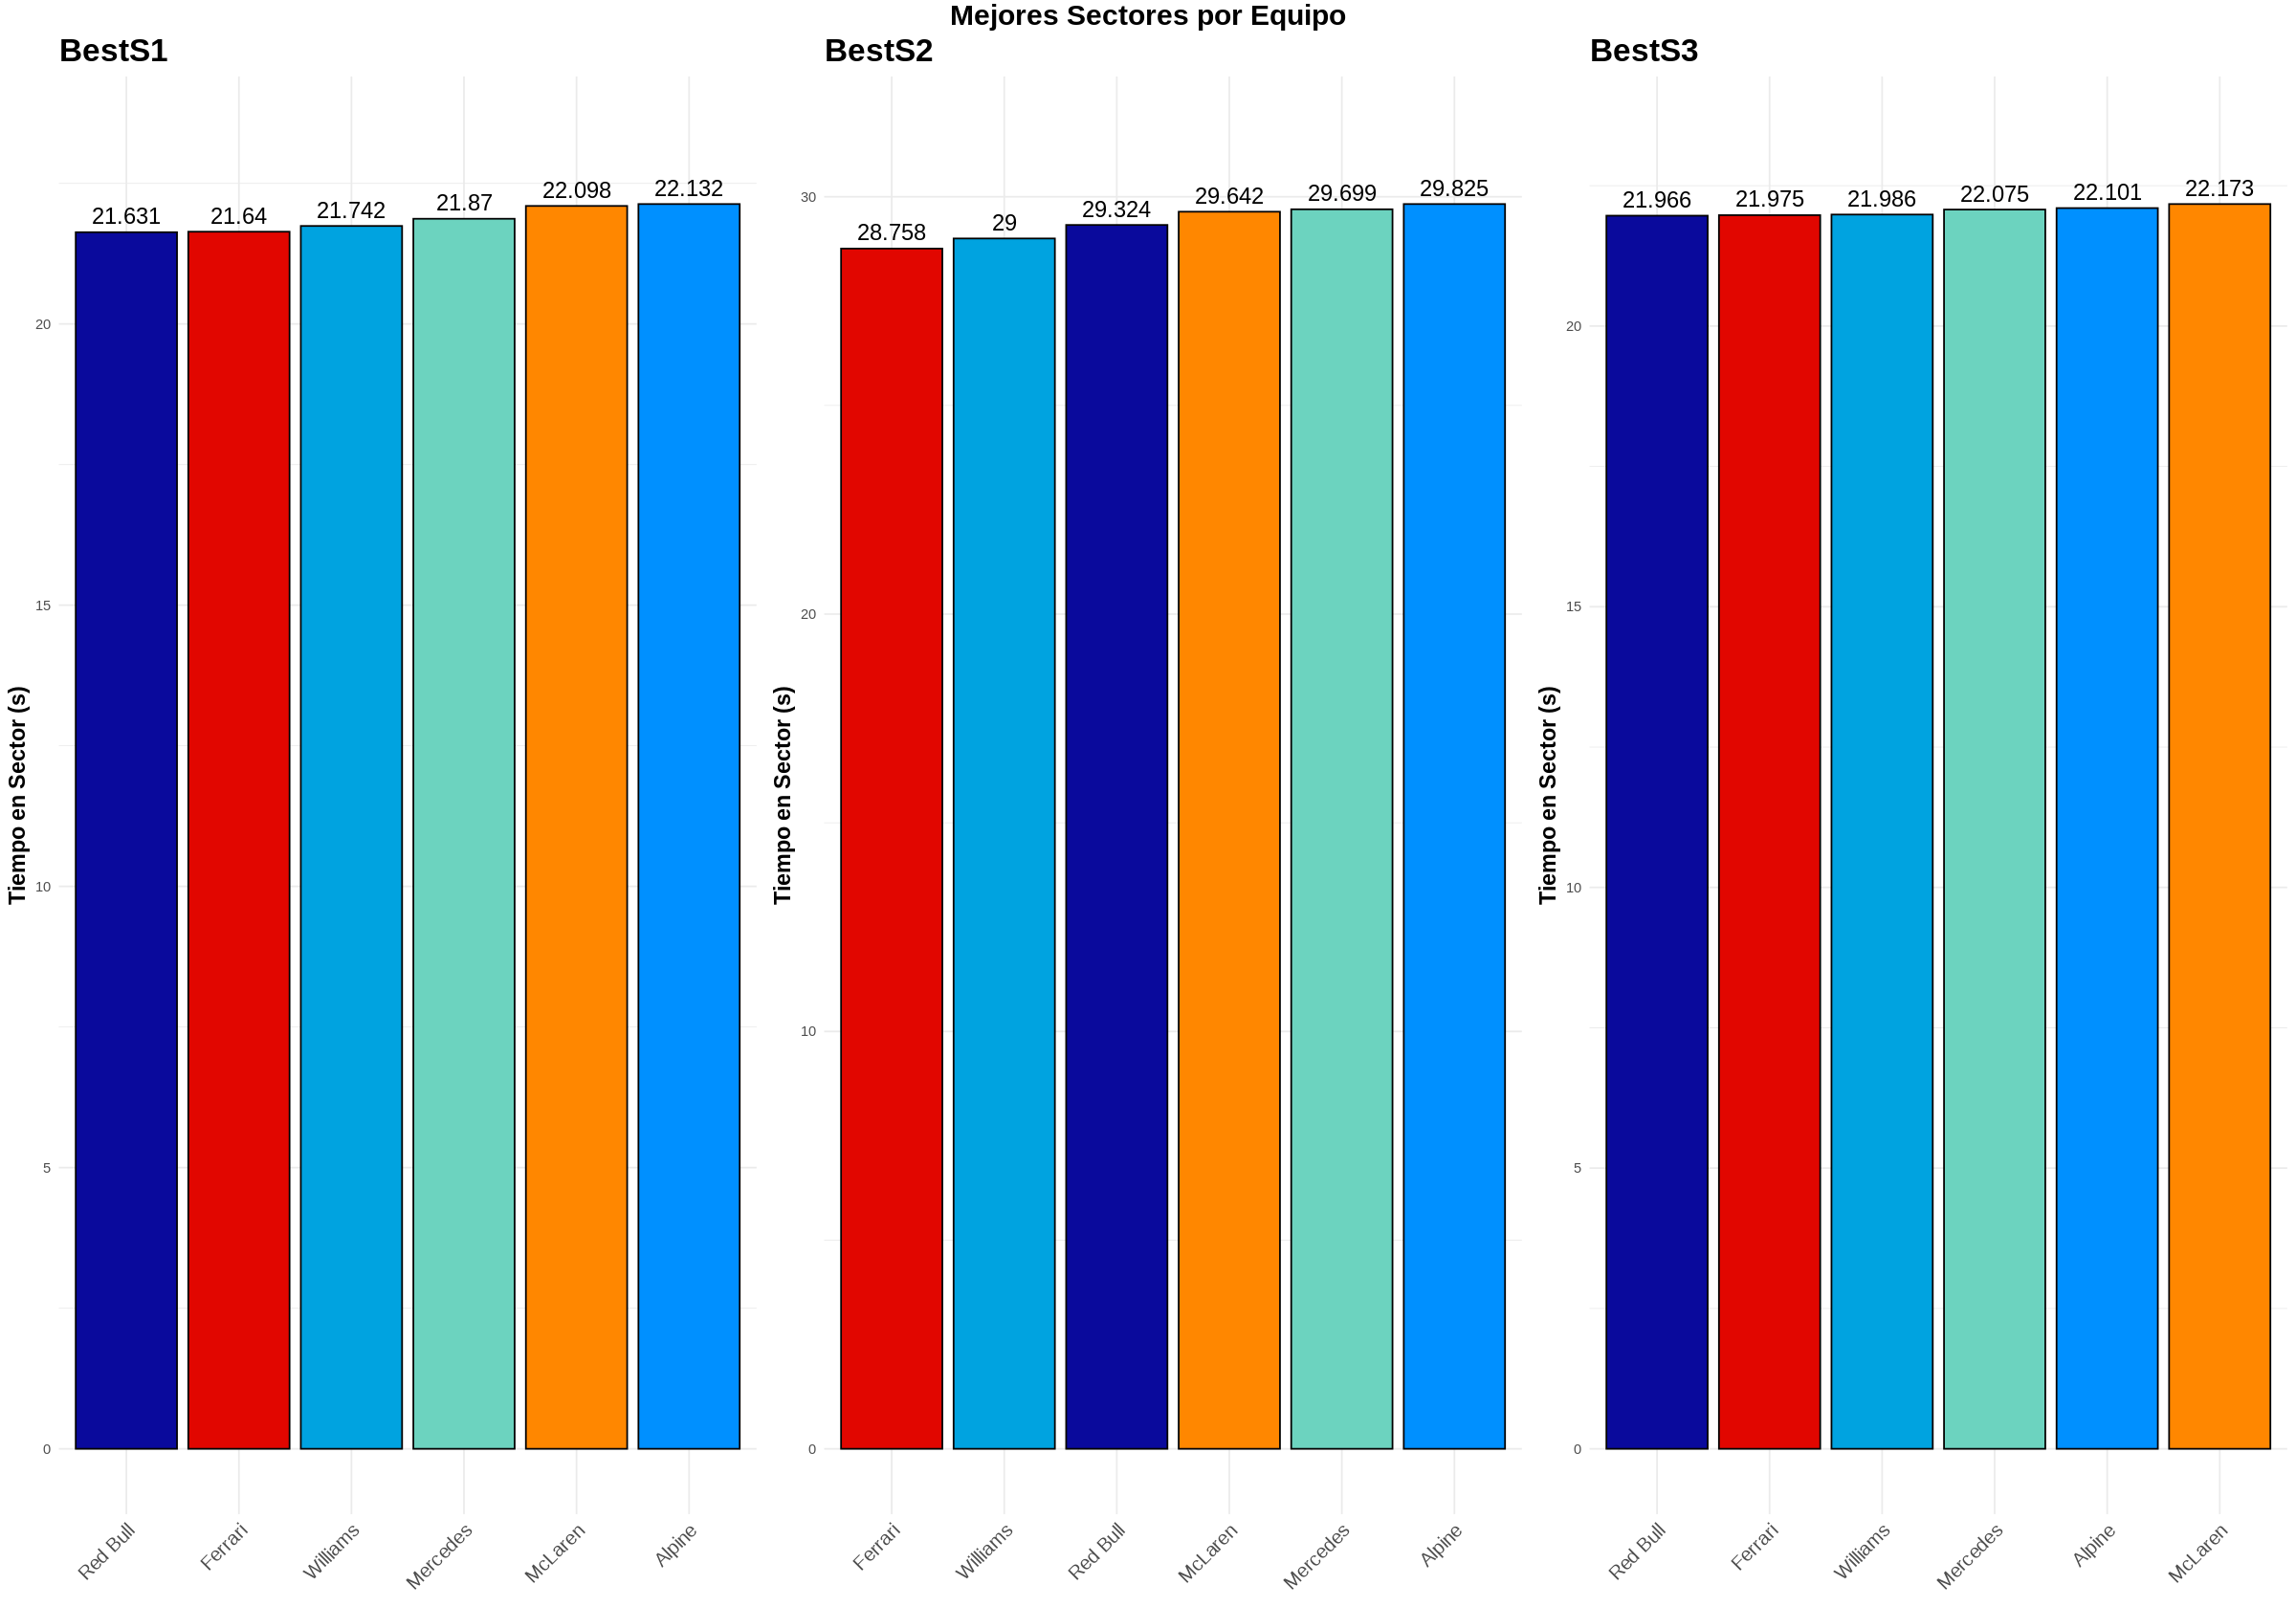

In [99]:
best_sector_times <- telemetria_vueltas_invalidadas %>%
  group_by(carId, lap_number, sector) %>%
  summarise(
    sector_time = max(lap_time, na.rm = TRUE) - min(lap_time, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  group_by(carId, sector) %>%
  summarise(
    best_sector_time = min(sector_time, na.rm = TRUE),
    .groups = 'drop'
  )

tabla_mejores <- best_sector_times %>%
  pivot_wider(names_from = sector, values_from = best_sector_time, names_prefix = "Best")

sectores_long <- tabla_mejores %>%
  select(carId, BestS1, BestS2, BestS3) %>%
  pivot_longer(cols = -carId, names_to = "Sector", values_to = "Tiempo") %>%
  mutate(full_carId = recode(carId, !!!full_team_names))

plot_sector <- function(data, sec) {
  df_s <- data %>% filter(Sector == sec)
  ggplot(df_s, aes(x = reorder(full_carId, Tiempo), y = Tiempo, fill = carId)) +
    geom_col(color="black") +
    geom_text(aes(label=round(Tiempo,3)), vjust=-0.5, size=5) +
    scale_fill_manual(values = colores_f1, labels = full_team_names) +
    coord_cartesian(ylim = c(0, max(df_s$Tiempo, na.rm = TRUE)*1.05)) +
    labs(title = sec, x = NULL, y = "Tiempo en Sector (s)") +
    theme_minimal() +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
          axis.title.y = element_text(size = 14, face = "bold"),
          plot.title = element_text(size = 20, face = "bold"))
}

cat("\n Generando Gráfico 7 (Sectores Separados)...\n")
p_s1 <- plot_sector(sectores_long, "BestS1")
p_s2 <- plot_sector(sectores_long, "BestS2")
p_s3 <- plot_sector(sectores_long, "BestS3")

grid.arrange(p_s1, p_s2, p_s3, ncol = 3,
             top = textGrob("Mejores Sectores por Equipo",
                            gp = gpar(fontsize = 18, fontface = "bold")))

### Cuadro 1: Resumen de Tiempos de Vuelta Promedio y Distribución

In [85]:
lap_time_descriptive_stats <- lap_times_summary_full %>%
  group_by(carId, full_carId) %>%
  summarise(
    Media_Tiempo_Vuelta = mean(total_lap_time, na.rm = TRUE),
    Mediana_Tiempo_Vuelta = median(total_lap_time, na.rm = TRUE),
    Min_Tiempo_Vuelta = min(total_lap_time, na.rm = TRUE),
    Max_Tiempo_Vuelta = max(total_lap_time, na.rm = TRUE),
    Desviacion_Estandar = sd(total_lap_time, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  arrange(Media_Tiempo_Vuelta)
lap_time_descriptive_stats

carId,full_carId,Media_Tiempo_Vuelta,Mediana_Tiempo_Vuelta,Min_Tiempo_Vuelta,Max_Tiempo_Vuelta,Desviacion_Estandar
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FER,Ferrari,72.8602,72.868,72.684,73.060,0.1389647
WIL,Williams,73.7322,73.543,73.199,74.664,0.5791931
RED,Red Bull,74.2274,73.635,73.105,76.899,1.5496384
MER,Mercedes,74.9876,74.327,73.794,78.251,1.8444957
MCL,McLaren,76.7346,76.540,74.137,79.300,2.2554845
ALP,Alpine,76.8912,75.647,74.388,83.367,3.6733539


En este grafico no podemos analizar con exactitud que equipo salió victorioso, ni que equipo fue el mas rápido en su totalidad, sin embargo podemos ver a que equipo se le daba mejor cada sector.



*   El equipo de Red-Bull se mantuvo con el mejor rendimiento en los sectores 1 y 3, mientras que en el sector 2 llego tercero.
*   El equipo de Ferrari logro la primera posición del segundo podio y se mantuvo en segunda posición en los otros 2
*   El equipo de Williams logro también el podio en los 3 sectores, llegando a una posición 3 en el primero y segundo y a una posición de segundo en el segundo sector.
*   El patrón se repite para Mercedes, quienes lograron un cuarto puesto en el primer y segundo sector pero un quinto en el segundo
*   El equipo de McLaren fue el mas variado, quedando quinto en el primer sector, cuarto en el segundo y ultimo en el tercero
*   Por ultimo el que peor resultado tuvo fue Alpine quienes quedaron últimos en los 2 primeros sectores y penúltimos en el tercero.

Podemos observar que quienes lograron un mejor rendimiento en la carrera fueron aquellos que quedaron en mejor posición en el primero y tercer sector, sin embargo el equipo ganador fue Ferrari quien hizo lo contrario, tuvo un mejor rendimiento en el segundo sector, en comparación con el resto de los corredores

#Actividad 9

 Elabore un gráfico que muestre en primer lugar el vehículo más rápido (tiempo de vuelta promedio) y a continuación el gap en segundos con cada uno de los demás vehículos. En el eje de las abscisas (X), se representarán los valores diferenciales, mientras que en el eje de las ordenadas (Y) se plasmará los vehículos.

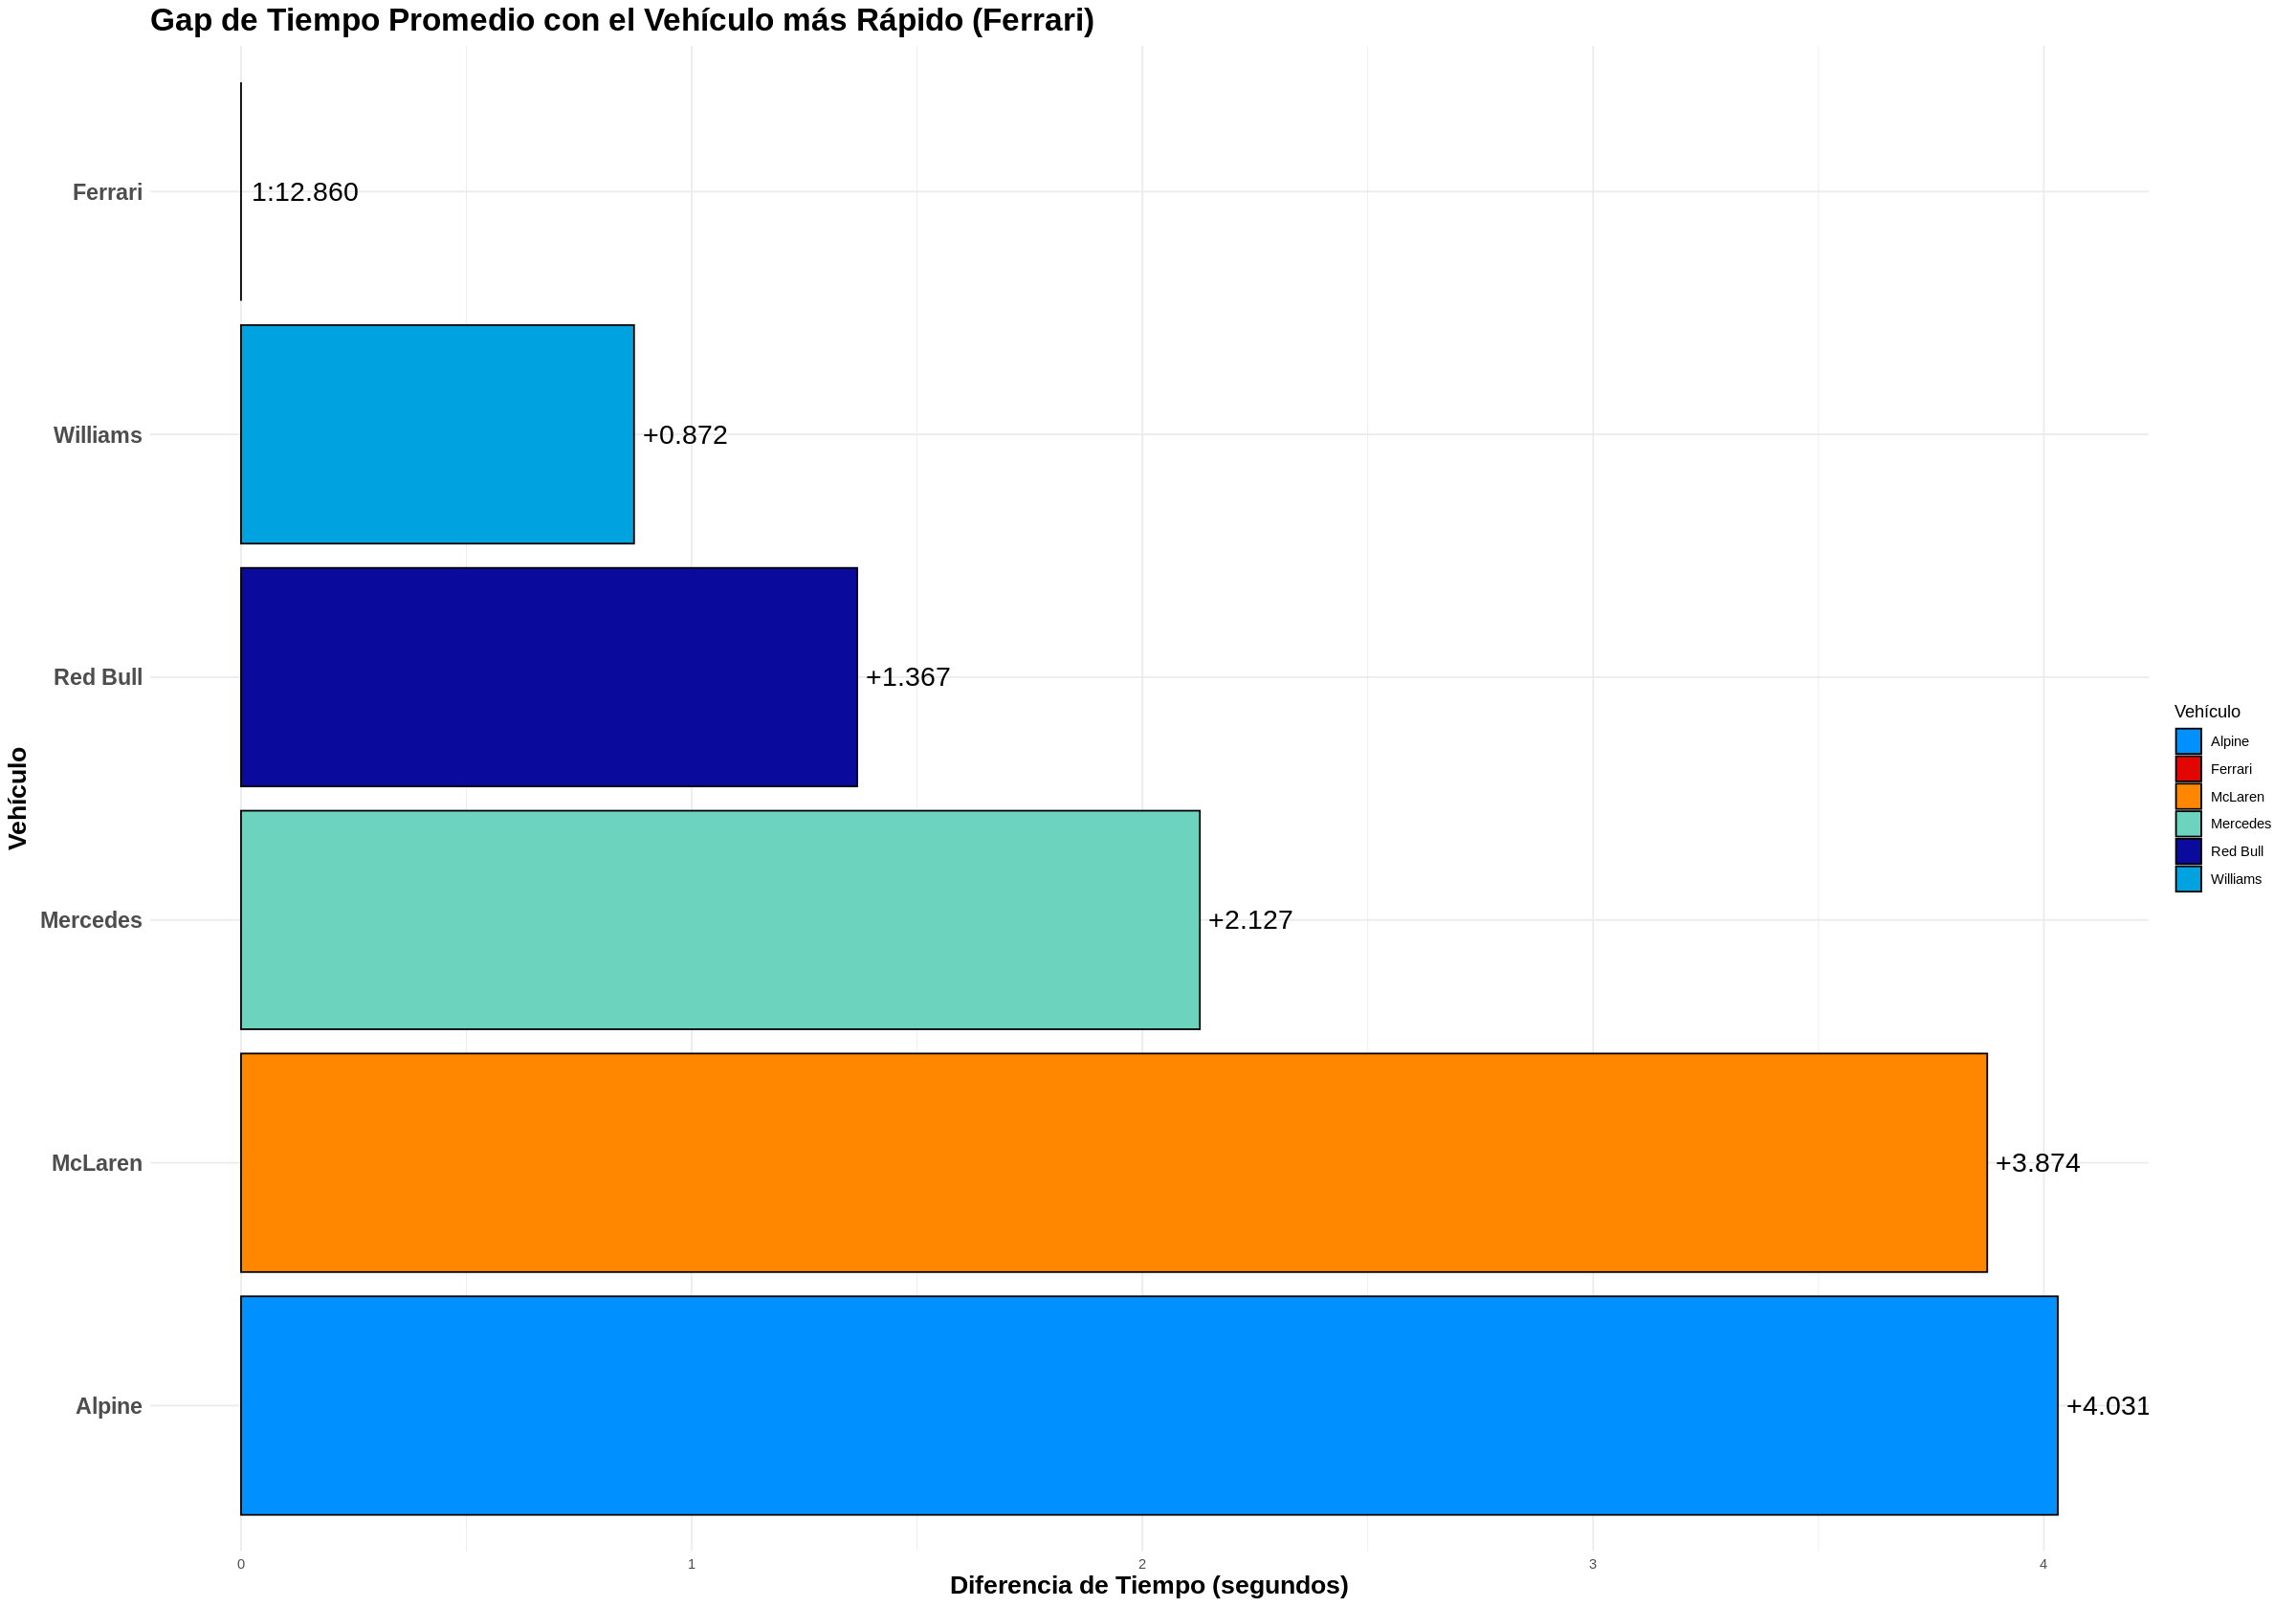

In [100]:
format_time_ms <- function(seconds) {
  minutes <- floor(seconds / 60)
  remaining_seconds <- seconds %% 60
  sprintf("%d:%06.3f", minutes, remaining_seconds)
}

average_lap_times <- telemetria_vueltas_invalidadas %>%
  group_by(carId, lap_number) %>%
  summarise(total_lap_time = max(lap_time, na.rm = TRUE), .groups = 'drop') %>%
  group_by(carId) %>%
  summarise(avg_lap_time = mean(total_lap_time, na.rm = TRUE), .groups = 'drop')

fastest_car_time <- min(average_lap_times$avg_lap_time, na.rm = TRUE)
fastest_car_id_abb <- average_lap_times %>%
  filter(avg_lap_time == fastest_car_time) %>%
  pull(carId) %>% head(1)
gap_data <- average_lap_times %>%
  mutate(gap_seconds = avg_lap_time - fastest_car_time) %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) %>%
  arrange(gap_seconds)

fastest_car_full_name <- full_team_names[fastest_car_id_abb]
fastest_car_time_formatted <- format_time_ms(fastest_car_time)

gap_data <- gap_data %>%
  mutate(display_label = ifelse(gap_seconds == 0,
                                fastest_car_time_formatted,
                                paste0("+", as.character(round(gap_seconds, 3)))))

ggplot(gap_data, aes(x = gap_seconds, y = reorder(full_carId, -gap_seconds), fill = carId)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = display_label), hjust = -0.1, size = 6) +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = paste0("Gap de Tiempo Promedio con el Vehículo más Rápido (", fastest_car_full_name, ")"),
    x = "Diferencia de Tiempo (segundos)",
    y = "Vehículo",
    fill = "Vehículo"
  ) +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 14, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title = element_text(size = 20, face = "bold")
  )


### Gap de Tiempo Promedio con el Vehículo más Rápido

In [87]:
display_gap_data <- gap_data %>%
  select(full_carId, avg_lap_time, gap_seconds, display_label) %>%
  arrange(gap_seconds)

print(display_gap_data)

# A tibble: 6 × 4
  full_carId avg_lap_time gap_seconds display_label
  <chr>             <dbl>       <dbl> <chr>        
1 Ferrari            72.9       0     1:12.860     
2 Williams           73.7       0.872 +0.872       
3 Red Bull           74.2       1.37  +1.367       
4 Mercedes           75.0       2.13  +2.127       
5 McLaren            76.7       3.87  +3.874       
6 Alpine             76.9       4.03  +4.031       


Como podemos observar en el grafico anterior, podemos definir que el auto mas rápido fue el de la escudería Ferrari(en un tiempo de 1:12:86) , seguido de Williams llegando en segundo lugar (0,872 segundos después), para cerrar el podio estaría el equipo de Red-Bull (a 1,367 segundos respecto al primero), en cuarta posición Mercedes (a 2,127 segundos), quinto el equipo de McLaren (a 3,874 segundos) y en ultimo lugar el equipo de Alpine (a 4,031 segundos del equipo de Ferrari)

 # Actividad 10

 Elabore un gráfico que muestre la velocidad máxima para cada uno de los vehículos, ordenado desde el más rápido al más lento SOLO TENIENDO EN CUENTA LAS VUELTAS VALIDAS. En el eje de las abscisas (X), se representarán los vehículos, mientras que en el eje de las ordenadas (Y) se plasmará la velocidad máxima por cada vehículo.

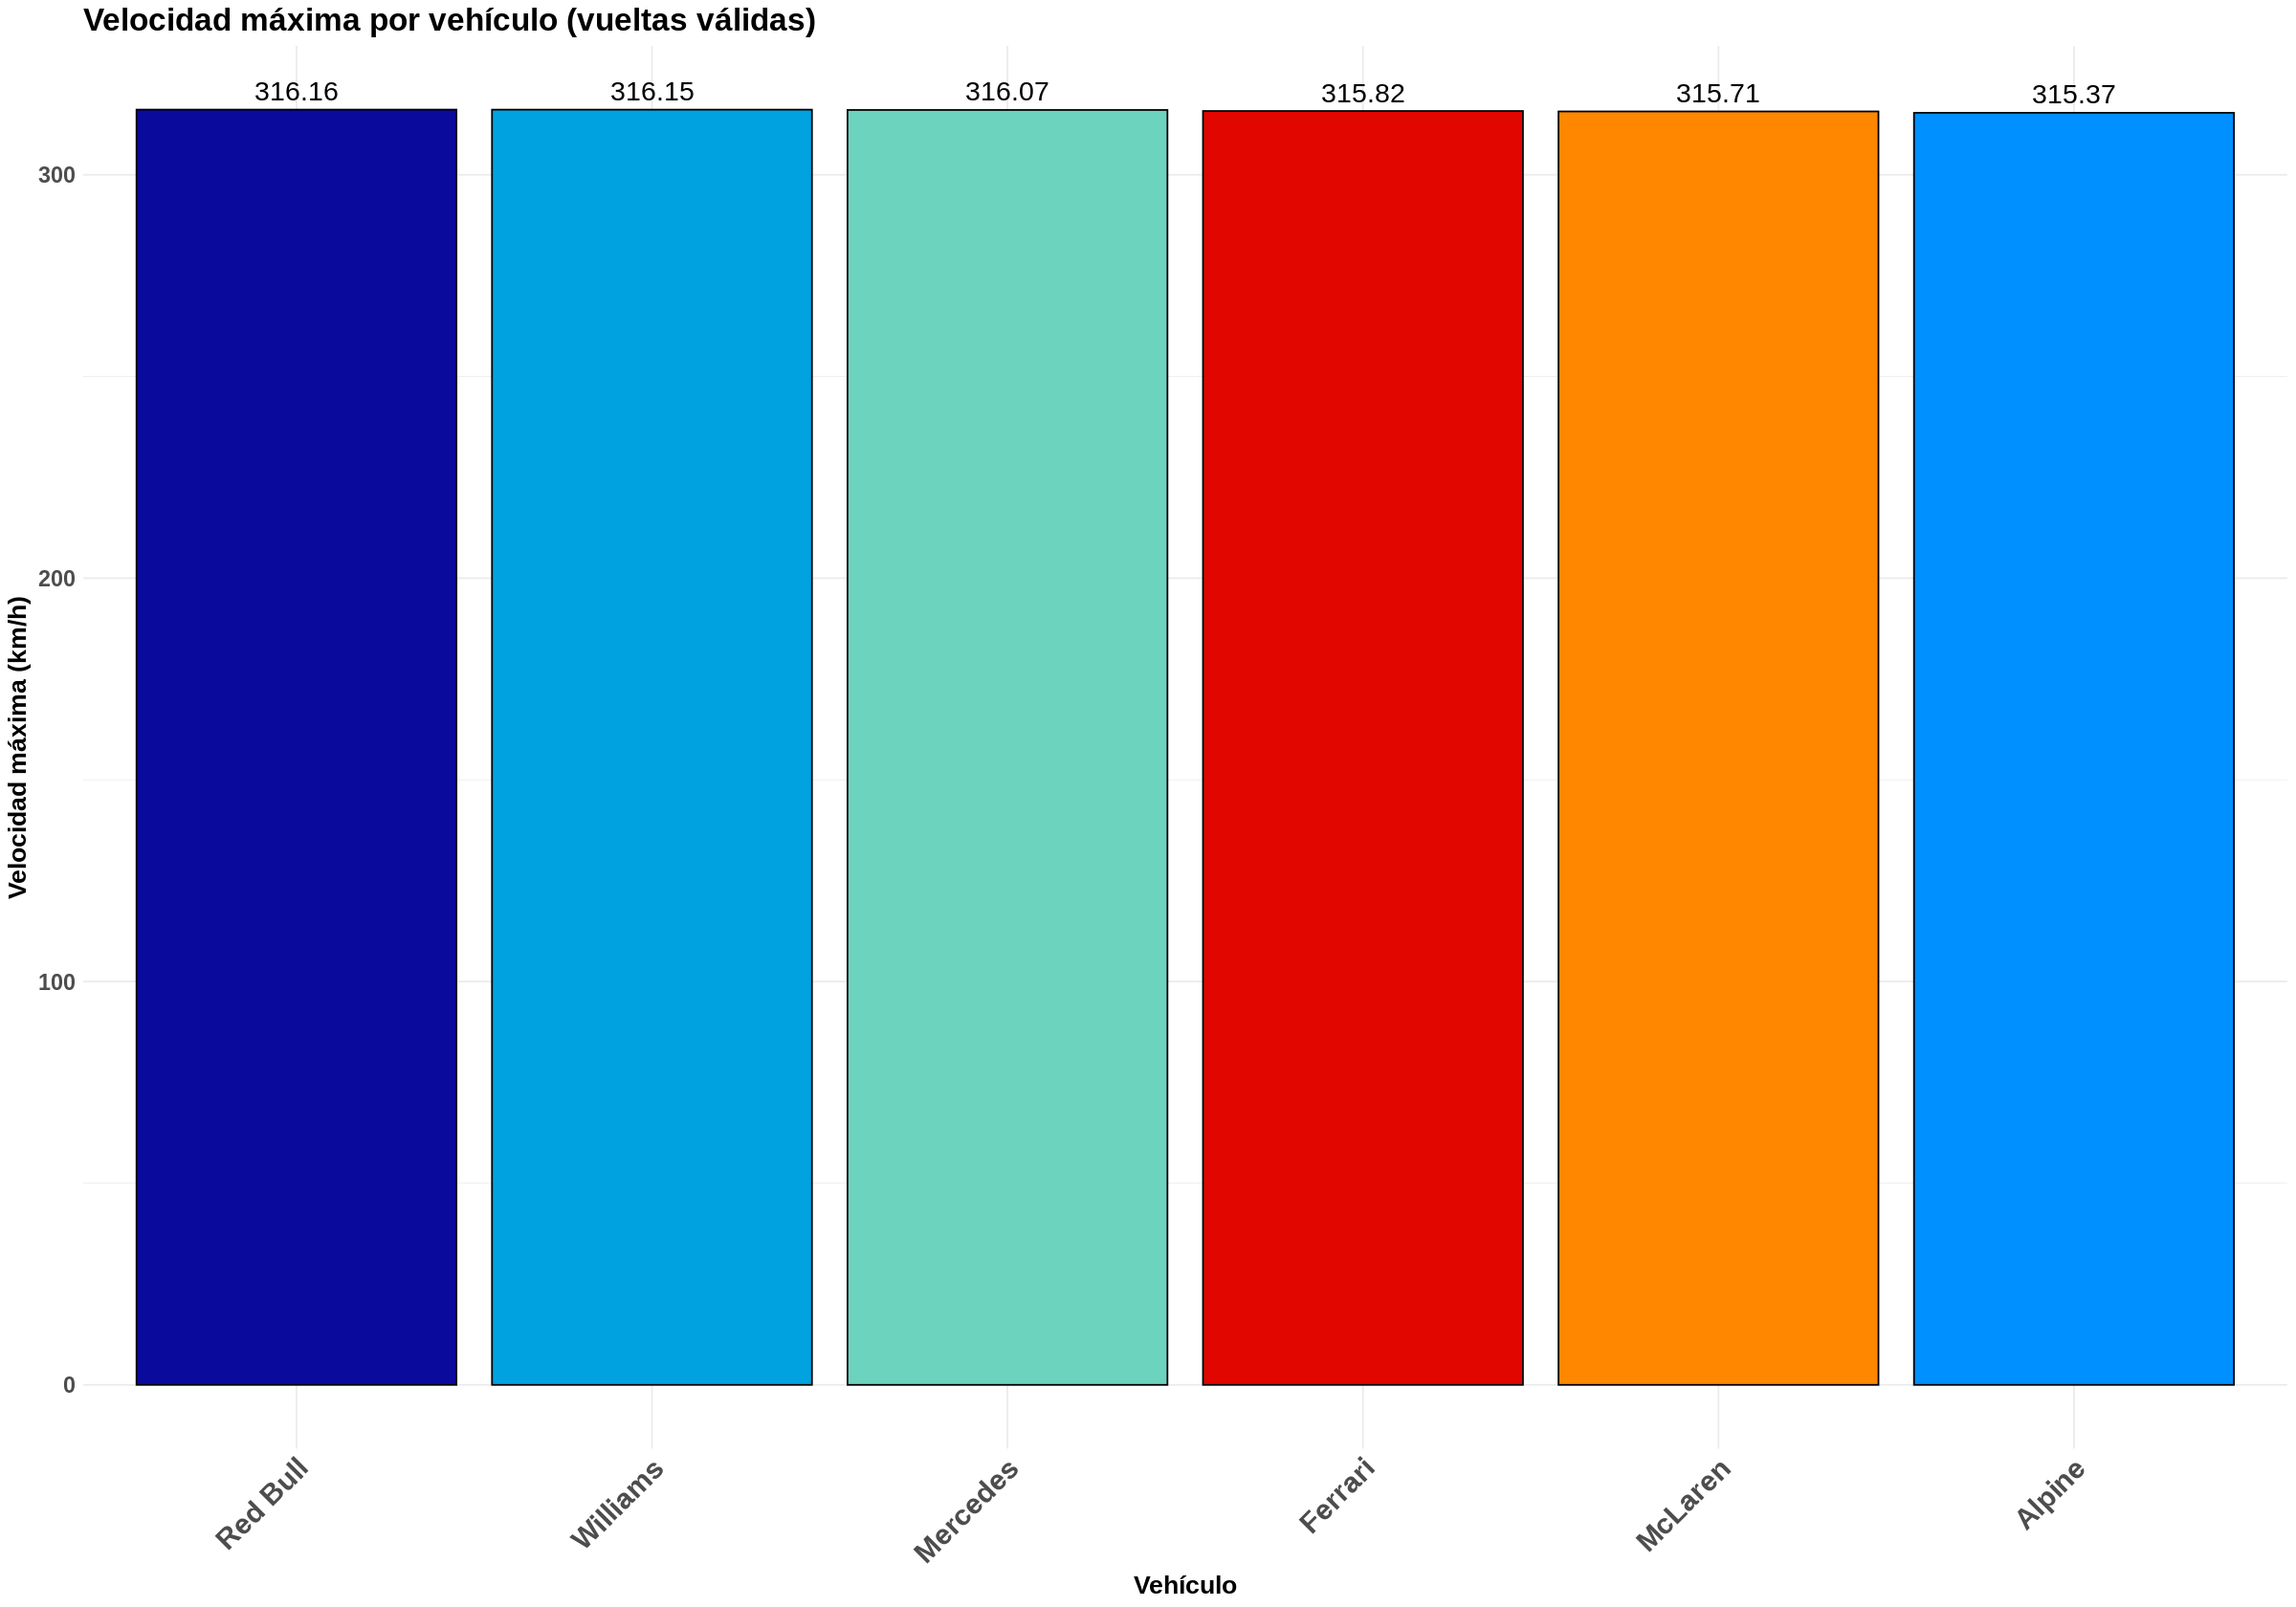

In [104]:
max_velocity_data1 <- telemetria_vueltas_invalidadas %>%
  filter(lap_time_invalid == 0) %>%
  group_by(carId) %>%
  summarise(max_velocidad = max(velocidad, na.rm = TRUE),
            .groups = "drop") %>%
  arrange(desc(max_velocidad))

max_velocity_data1 <- max_velocity_data1 %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) %>%
  mutate(full_carId = factor(full_carId, levels = full_carId))

ggplot(max_velocity_data, aes(x = full_carId, y = max_velocidad, fill = carId)) +
  geom_col(color = "black") +
  geom_text(aes(label = round(max_velocidad, 2)),
            vjust = -0.5, size = 6) +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Velocidad máxima por vehículo (vueltas válidas)",
    x = "Vehículo",
    y = "Velocidad máxima (km/h)"
  ) +
  theme_minimal() +
  theme(
    axis.text.x  = element_text(angle = 45, hjust = 1, size = 18, face = "bold"),
    axis.text.y  = element_text(size = 14, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title   = element_text(size = 20, face = "bold"),
    legend.position = "none"
  )


In [105]:
max_velocity_data1

carId,max_velocidad,full_carId
<chr>,<dbl>,<fct>
RED,316.1590,Red Bull
MER,316.0714,Mercedes
MCL,315.7055,McLaren
WIL,315.6451,Williams
FER,315.4023,Ferrari
ALP,315.3689,Alpine


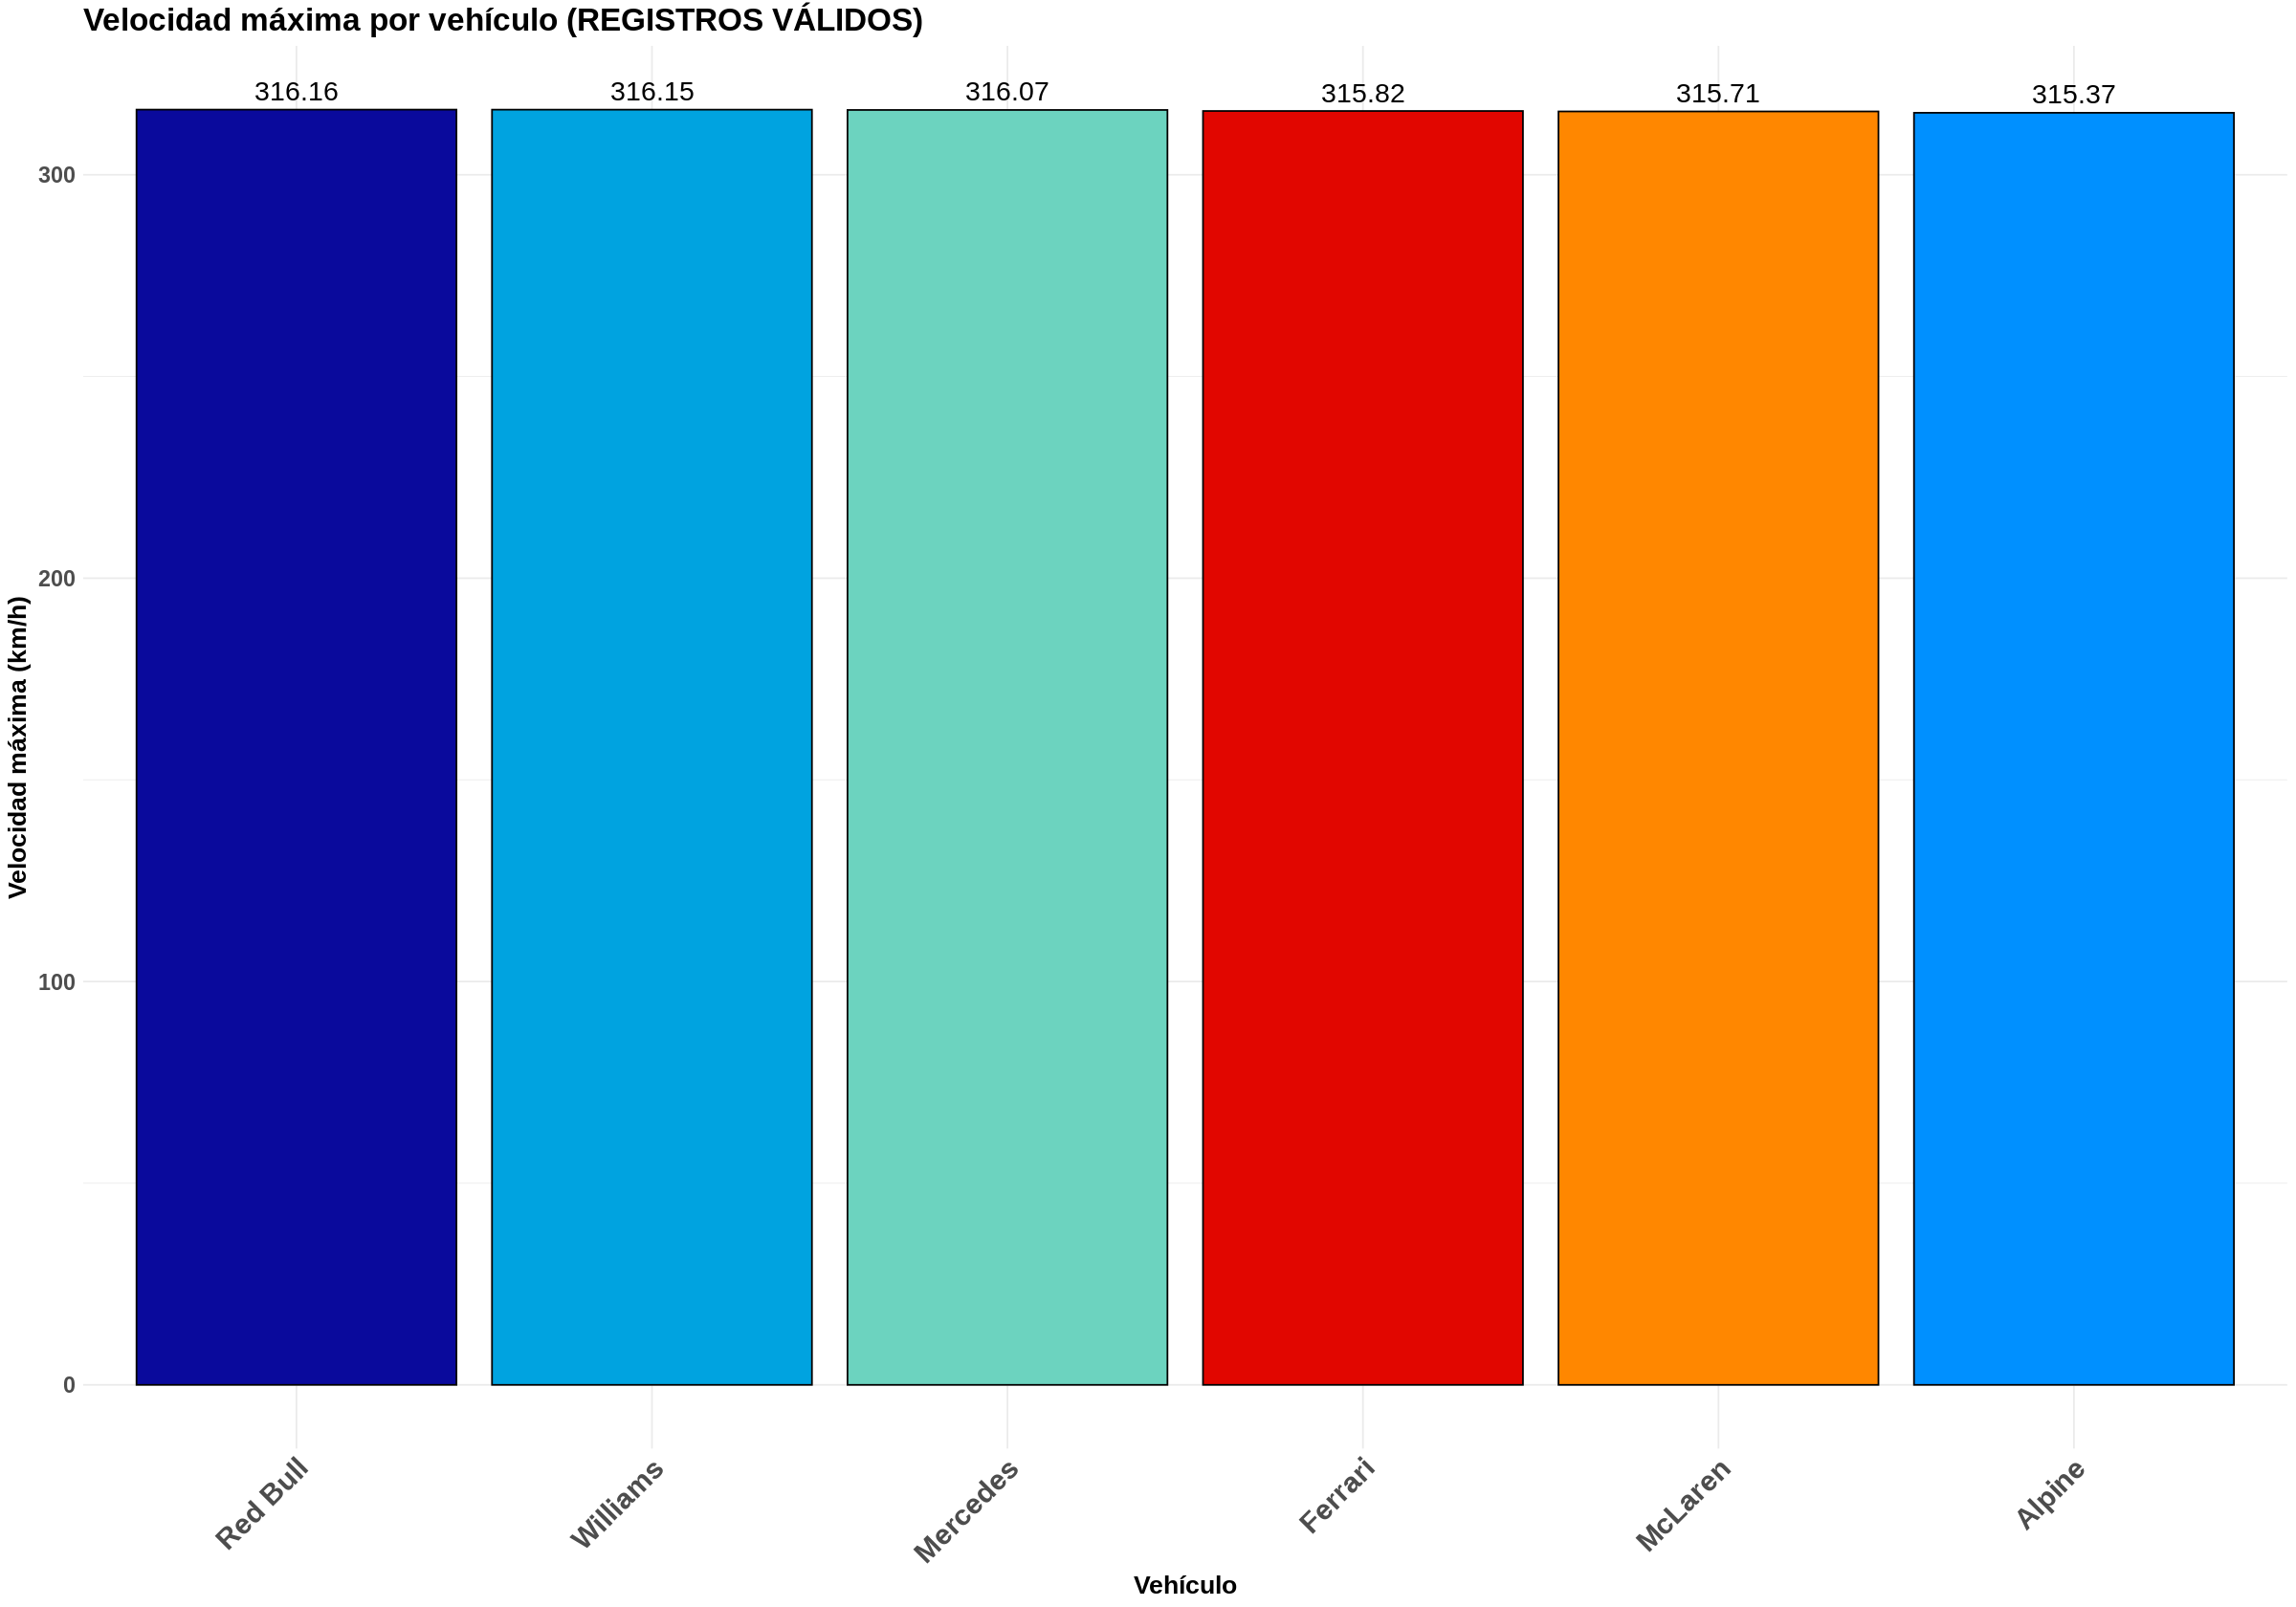

In [106]:
max_velocity_data2 <- telemetria %>%
  filter(lap_time_invalid == 0) %>%
  group_by(carId) %>%
  summarise(max_velocidad = max(velocidad, na.rm = TRUE),
            .groups = "drop") %>%
  arrange(desc(max_velocidad))

max_velocity_data2 <- max_velocity_data2 %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) %>%
  mutate(full_carId = factor(full_carId, levels = full_carId))

ggplot(max_velocity_data, aes(x = full_carId, y = max_velocidad, fill = carId)) +
  geom_col(color = "black") +
  geom_text(aes(label = round(max_velocidad, 2)),
            vjust = -0.5, size = 6) +
  scale_fill_manual(values = colores_f1, labels = full_team_names) +
  labs(
    title = "Velocidad máxima por vehículo (REGISTROS VÁLIDOS)",
    x = "Vehículo",
    y = "Velocidad máxima (km/h)"
  ) +
  theme_minimal() +
  theme(
    axis.text.x  = element_text(angle = 45, hjust = 1, size = 18, face = "bold"),
    axis.text.y  = element_text(size = 14, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    plot.title   = element_text(size = 20, face = "bold"),
    legend.position = "none"
  )

In [107]:
max_velocity_data2

carId,max_velocidad,full_carId
<chr>,<dbl>,<fct>
RED,316.1590,Red Bull
WIL,316.1489,Williams
MER,316.0714,Mercedes
FER,315.8166,Ferrari
MCL,315.7055,McLaren
ALP,315.3745,Alpine


En este grafico se puede observar las velocidades maximas de cada vehiculo que se lograron solo en las vueltas Validas (vueltas las cuales los corredores no se salieron de la pista)


